In [1]:
import pandas as pd
import os
import joblib 
from pathlib import Path
import numpy as np
import scipy.interpolate as interp
import warnings
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from src.eeg_analysis.analysis.power_spectral import TimeFrequencyRepresentation as TFR
from src.eeg_analysis.visualization.my_custom_style import set_custom_style
from src.eeg_analysis.utils.helpers import detect_and_interpolate_outliers, detect_and_interpolate_outliers_v2
from src.eeg_analysis.data_management import load_patient_group_labels

In [3]:
# Load the Excel file
main_dir = 'E:/Caffeine_data/'

file_path = 'E:/Caffeine_data/caffeine_labels.xlsx'
groups = load_patient_group_labels(file_path)

outlier_detection_window_size = 10
outlier_detection_std_factor = 0.5
iqr_factor = 15

# try:
#     df = pd.read_excel(file_path)
#     print("Excel file loaded successfully.")
# except FileNotFoundError:
#     warnings.warn(f"Warning: The file at {file_path} was not found.", UserWarning)
#     df = None
# except Exception as e:
#     warnings.warn(f"Warning: An error occurred while loading the Excel file: {e}", UserWarning)
#     df = None



# if df is not None:
#     # Print column names to verify
#     print(df.columns)

#     # Initialize the dictionary for groups
#     groups = {'A': [], 'B': []}

#     # Populate the dictionary based on the group label
#     for index, row in df.iterrows():
#         try:
#             label = row['Patient_Label'] 
#             group = row['Group_Number']
#             data_available = row['Preprocessed_Data_Available']

#             if group == 1 and data_available == 1:
#                 groups['A'].append(label)
#             elif group == 2 and data_available == 1:
#                 groups['B'].append(label)
#         except KeyError as e:
#             warnings.warn(f"Warning: The column {e} is missing from the Excel file.", UserWarning)
#         except Exception as e:
#             warnings.warn(f"Warning: An error occurred while processing the row {index}: {e}", UserWarning)

#     print(groups)
#     print(f"Group A: {len(groups['A'])} subjects, Group B: {len(groups['B'])} subjects")

if groups is not None:

    epoch_names = ['preop_rest', 'emergence', 'pacu_rest']
    region_names = ['prefrontal', 'frontal', 'parietal', 'central', 'temporal', 'occipital']
    fbands = {
        'delta': [0.5, 4], 
        'theta': [4, 7],
        'alpha': [7, 14] ,  
        'beta': [14, 20], 
        'gamma': [20, 35]
    } # Conventionally defind frequency bands

    # Initialize data structures
    win_center = {}
    psd = {}
    reg_fit_slope = {}
    fooof_fit_slope = {}
    # region_avg_tfr = {}
    # region_avg_tfr_whitened = {}
    fband_power_reg = {fband: {} for fband in fbands}
    fband_power_fooof = {fband: {} for fband in fbands}
    fband_power_abs = {fband: {} for fband in fbands}
    fband_central_freq = {fband: {} for fband in fbands}
    group_label = {}

    for p_id in range(1, 72):
        p_name = f'CA-{p_id:02}'
        base_results_dir = Path(f'E:/Caffeine_data/CA-{p_id:02}/analysis_results_v2')
        filename = base_results_dir / f'CA-{p_id:02}_power_spectral_wider_alpha_band.pkl'

        if not filename.exists():
            if p_name in groups['A']+groups['B']:
                warnings.warn(f"Warning: The file at {filename} was not found.", UserWarning)
            else:
                continue

        # if p_name == 'CA-26':
        #     print(p_name)

        loaded_power_spectral = joblib.load(filename)

        win_center[p_name] = {}
        psd[p_name] = {}
        reg_fit_slope[p_name] = {}
        fooof_fit_slope[p_name] = {}
        # region_avg_tfr[p_name] = {}
        # region_avg_tfr_whitened[p_name] = {}
        for region in region_names:
            win_center[p_name][region] = {}
            psd[p_name][region] = {}
            reg_fit_slope[p_name][region] = {}
            fooof_fit_slope[p_name][region] = {}
            # region_avg_tfr[p_name][region] = {}
            # region_avg_tfr_whitened[p_name][region] = {}
            for epoch in epoch_names:
                win_center[p_name][region][epoch] = loaded_power_spectral.window_average_tfr[region][epoch].times
                psd[p_name][region][epoch] = loaded_power_spectral.window_average_tfr[region][epoch].data

                # reg_fit_slope[p_name][region][epoch] = -loaded_power_spectral.regresssion_ap_fit_slope[region][epoch].flatten()
                # fooof_fit_slope[p_name][region][epoch] = loaded_power_spectral.fooof_aperiodic_fit_slope[region][epoch].flatten()

                # Processing the regression and FOOOF fit slopes
                reg_ap_fit = -loaded_power_spectral.regresssion_ap_fit_slope[region][epoch].flatten()
                if np.any(~np.isnan(reg_ap_fit)):
                    reg_fit_slope[p_name][region][epoch] = detect_and_interpolate_outliers(
                        reg_ap_fit, iqr_factor=iqr_factor
                    )
                else:
                    reg_fit_slope[p_name][region][epoch] = reg_ap_fit

                
                fooof_ap_fit = loaded_power_spectral.fooof_aperiodic_fit_slope[region][epoch].flatten() 
                if np.any(~np.isnan(fooof_ap_fit)):
                    fooof_fit_slope[p_name][region][epoch] = detect_and_interpolate_outliers(
                        fooof_ap_fit, iqr_factor=iqr_factor
                    )
                else:
                    fooof_fit_slope[p_name][region][epoch] = fooof_ap_fit

                # reg_fit_slope[p_name][region][epoch] = detect_and_interpolate_outliers_v2(
                #     detect_and_interpolate_outliers_v2(
                #         -loaded_power_spectral.regresssion_ap_fit_slope[region][epoch].flatten(), 
                #         window_size=outlier_detection_window_size, 
                #         std_factor=outlier_detection_std_factor
                #     ),
                #     window_size=outlier_detection_window_size, 
                #     std_factor=outlier_detection_std_factor
                # )

                # fooof_fit_slope[p_name][region][epoch] = detect_and_interpolate_outliers_v2(
                #     detect_and_interpolate_outliers_v2(
                #         loaded_power_spectral.fooof_aperiodic_fit_slope[region][epoch].flatten(), 
                #         window_size=outlier_detection_window_size, 
                #         std_factor=outlier_detection_std_factor
                #     ),
                #     window_size=outlier_detection_window_size, 
                #     std_factor=outlier_detection_std_factor
                # )

                # region_avg_tfr[p_name][region][epoch] = loaded_power_spectral.region_average_tfr[region][epoch]
                # region_avg_tfr_whitened[p_name][region][epoch] = loaded_power_spectral.whitened_tfr[region][epoch]

                for fband in fbands:
                    if p_name not in fband_power_reg[fband]:
                        fband_power_reg[fband][p_name] = {}
                    if p_name not in fband_power_fooof[fband]:
                        fband_power_fooof[fband][p_name] = {}
                    if p_name not in fband_power_abs[fband]:
                        fband_power_abs[fband][p_name] = {}
                    if p_name not in fband_central_freq[fband]:
                        fband_central_freq[fband][p_name] = {}

                    if region not in fband_power_reg[fband][p_name]:
                        fband_power_reg[fband][p_name][region] = {}
                    if region not in fband_power_fooof[fband][p_name]:
                        fband_power_fooof[fband][p_name][region] = {}
                    if region not in fband_power_abs[fband][p_name]:
                        fband_power_abs[fband][p_name][region] = {}
                    if region not in fband_central_freq[fband][p_name]:
                        fband_central_freq[fband][p_name][region] = {}

                    # freq band powers relative to the aperiodic component calculated using linear regression method
                    curr_fband_data_reg = loaded_power_spectral.fband_power_relative_reg_ap[region][epoch][fband].flatten()
                    # fband_power_reg[fband][p_name][region][epoch] = curr_fband_data_reg
                    if np.any(~np.isnan(curr_fband_data_reg)):
                        curr_fband_data_reg = detect_and_interpolate_outliers(curr_fband_data_reg, iqr_factor=iqr_factor)
                        curr_fband_data_reg[np.isnan(curr_fband_data_reg)] = 0
                        fband_power_reg[fband][p_name][region][epoch] = curr_fband_data_reg

                        # fband_power_reg[fband][p_name][region][epoch] = detect_and_interpolate_outliers_v2(
                        #     detect_and_interpolate_outliers_v2(
                        #         curr_fband_data_reg, 
                        #         window_size=outlier_detection_window_size, 
                        #         std_factor=outlier_detection_std_factor
                        #     ),
                        #     window_size=outlier_detection_window_size, 
                        #     std_factor=outlier_detection_std_factor
                        # )
                    else:
                        fband_power_reg[fband][p_name][region][epoch] = curr_fband_data_reg

                    # if fband not in fband_power_fooof:
                    #     fband_power_fooof[fband] = {}

                    # freq band powers extracted using FOOOF (relative to the FOOOF aperiodic component)
                    if fband == 'delta':
                        curr_fband_data_fooof = loaded_power_spectral.fooof_periodic_parameters[region][epoch][fband]['avg_power_relative'].flatten()
                    else:
                        curr_fband_data_fooof = loaded_power_spectral.fooof_periodic_parameters[region][epoch][fband]['amplitude'].flatten()

                    # fband_power_fooof[fband][p_name][region][epoch] = curr_fband_data_fooof 
                    if np.any(~np.isnan(curr_fband_data_fooof)):
                        curr_fband_data_fooof = detect_and_interpolate_outliers(curr_fband_data_fooof, iqr_factor=iqr_factor)
                        curr_fband_data_fooof[curr_fband_data_fooof==-1] = 0
                        fband_power_fooof[fband][p_name][region][epoch] = curr_fband_data_fooof

                        # fband_power_fooof[fband][p_name][region][epoch] = detect_and_interpolate_outliers_v2(
                        #     detect_and_interpolate_outliers_v2(
                        #         curr_fband_data_fooof, 
                        #         window_size=outlier_detection_window_size, 
                        #         std_factor=outlier_detection_std_factor    
                        #     ),
                        #     window_size=outlier_detection_window_size, 
                        #     std_factor=outlier_detection_std_factor
                        # )
                    else:
                        fband_power_fooof[fband][p_name][region][epoch] = curr_fband_data_fooof

                    # Absolute freq band powers (freq band boundaries calculated using FOOOF)
                    curr_fband_data_abs = loaded_power_spectral.fooof_periodic_parameters[region][epoch][fband]['avg_power_absolute'].flatten()
                    # fband_power_abs[fband][p_name][region][epoch] = curr_fband_data_abs
                    if np.any(~np.isnan(curr_fband_data_fooof)):
                        curr_fband_data_abs = detect_and_interpolate_outliers(curr_fband_data_abs, iqr_factor=iqr_factor)
                        # >>TODO: Check if in need to replace NaNs or -1 with 0 for the following line
                        curr_fband_data_abs[np.isnan(curr_fband_data_abs)] = 0
                        fband_power_abs[fband][p_name][region][epoch] = curr_fband_data_abs
                        
                        # fband_power_abs[fband][p_name][region][epoch] = detect_and_interpolate_outliers_v2(
                        #     detect_and_interpolate_outliers_v2(
                        #         curr_fband_data_abs, 
                        #         window_size=outlier_detection_window_size, 
                        #         std_factor=outlier_detection_std_factor    
                        #     ),
                        #     window_size=outlier_detection_window_size, 
                        #     std_factor=outlier_detection_std_factor
                        # )
                    else:
                        fband_power_abs[fband][p_name][region][epoch] = curr_fband_data_abs

                    # Central frequencies of the frequency bands
                    if fband != 'delta':
                        central_frequencies = loaded_power_spectral.fooof_periodic_parameters[region][epoch][fband]['cf'].flatten()
                        # fband_central_freq[fband][p_name][region][epoch] = central_frequencies
                        if np.any(~np.isnan(central_frequencies)):
                            central_frequencies = detect_and_interpolate_outliers(central_frequencies, iqr_factor=iqr_factor)
                            central_frequencies[central_frequencies == 0] = np.nan
                            fband_central_freq[fband][p_name][region][epoch] = central_frequencies
                            # fband_central_freq[fband][p_name][region][epoch] = detect_and_interpolate_outliers_v2(
                            #     detect_and_interpolate_outliers_v2(
                            #         central_frequencies, 
                            #         window_size=outlier_detection_window_size, 
                            #         std_factor=outlier_detection_std_factor   
                            #     ),
                            #     window_size=outlier_detection_window_size, 
                            #     std_factor=outlier_detection_std_factor
                            # )
                        else:
                            fband_central_freq[fband][p_name][region][epoch] = central_frequencies  

        if p_name in groups['A']:
            group_label[p_name] = 'A'
        elif p_name in groups['B']:
            group_label[p_name] = 'B'
        else:
            group_label[p_name] = np.nan 


Excel file loaded successfully.
Column names: Index(['Patient_Label', 'Group_Number', 'Raw_Data_Available',
       'Preprocessed_Data_Available', 'Valid MAC_and_normal_closure'],
      dtype='object')
{'A': ['CA-03', 'CA-05', 'CA-07', 'CA-10', 'CA-11', 'CA-13', 'CA-15', 'CA-18', 'CA-19', 'CA-26', 'CA-27', 'CA-38', 'CA-40', 'CA-42', 'CA-52', 'CA-55', 'CA-63', 'CA-64', 'CA-66', 'CA-71'], 'B': ['CA-01', 'CA-02', 'CA-04', 'CA-06', 'CA-09', 'CA-14', 'CA-21', 'CA-24', 'CA-25', 'CA-28', 'CA-29', 'CA-34', 'CA-36', 'CA-48', 'CA-49', 'CA-53', 'CA-54', 'CA-56', 'CA-65', 'CA-69', 'CA-70']}
Group A: 20 subjects, Group B: 21 subjects


In [4]:
array = loaded_power_spectral.region_average_tfr['prefrontal']['emergence']

In [5]:
array.times

array([0.0000e+00, 1.0000e-01, 2.0000e-01, ..., 4.3277e+03, 4.3278e+03,
       4.3279e+03])

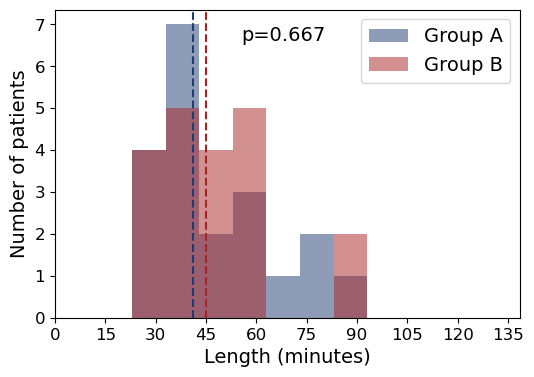

In [6]:
### plot the distribution of the total time of emergence across all patients in group A and B
total_emergence_time = {}
for group in ['A', 'B']:
    total_emergence_time[group] = []
    for p_name in groups[group]:
        total_emergence_time[group].append(len(win_center[p_name]['frontal']['emergence'])*60 - 600)

# one barplot with two groups in the same figure
BLUE = "#1f3b73"  # Dark Blue
RED = "#a82323"  # Dark Red

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
# use the same bins for both groups
# first calculate the min and max of the total emergence time
min_total_time = min(min(total_emergence_time['A']), min(total_emergence_time['B']))
max_total_time = max(max(total_emergence_time['A']), max(total_emergence_time['B']))
bins = np.arange(min_total_time, max_total_time, 600)
bin_centers = (bins[:-1] + bins[1:])/2
ax.hist(total_emergence_time['A'], bins=bins, color=BLUE, alpha=0.5, label='Group A')
ax.hist(total_emergence_time['B'], bins=bins, color=RED, alpha=0.5, label='Group B')
# perform a rank-sum test
from scipy.stats import ranksums
stat, p = ranksums(total_emergence_time['A'], total_emergence_time['B'])
# add dashed line showing the median for each group
ax.axvline(np.median(total_emergence_time['A']), color=BLUE, linestyle='--')
ax.axvline(np.median(total_emergence_time['B']), color=RED, linestyle='--')
# add p-value to the plot
ax.text(0.4, 0.9, f'p={p:.3f}', transform=ax.transAxes, fontsize=14)
xticks = np.arange(0, max_total_time, 900)
ax.set_xticks(xticks)
xtick_labels = [f'{x//60}' for x in xticks]
ax.set_xticklabels(xtick_labels)
ax.set_xlabel('Length (minutes)', fontsize=14)
ax.set_ylabel('Number of patients', fontsize=14)
ax.legend(fontsize=14)
ax.tick_params(axis='both', labelsize=12)
plt.show()


In [4]:

win_center['CA-02']['frontal']['emergence']

array([  60.,  120.,  180.,  240.,  300.,  360.,  420.,  480.,  540.,
        600.,  660.,  720.,  780.,  840.,  900.,  960., 1020., 1080.,
       1140., 1200., 1260., 1320., 1380., 1440., 1500., 1560., 1620.,
       1680., 1740., 1800., 1860., 1920., 1980., 2040., 2100., 2160.,
       2220., 2280., 2340., 2400., 2460., 2520., 2580., 2640., 2700.,
       2760., 2820., 2880., 2940., 3000., 3060., 3120., 3180., 3240.,
       3300., 3360., 3420.])

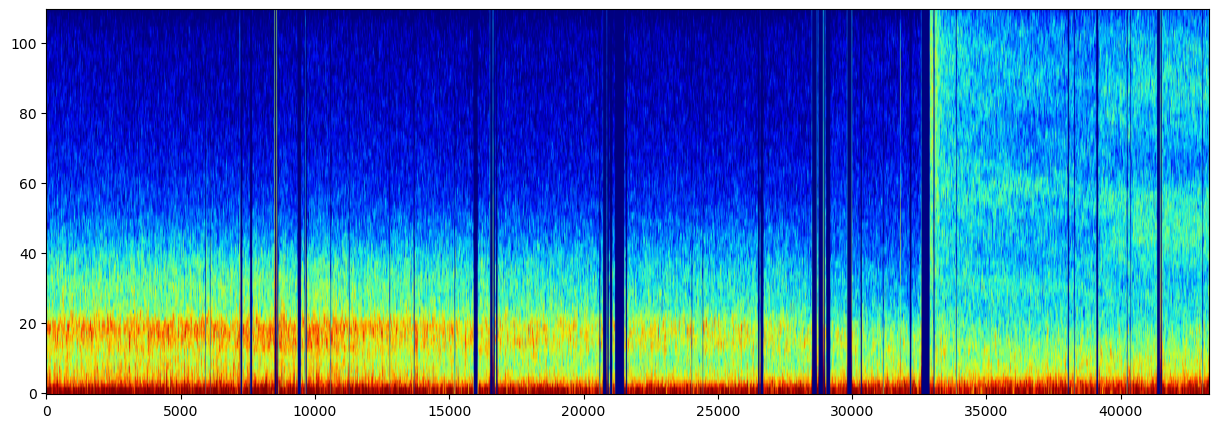

In [7]:
plt.figure(figsize=(15, 5))

plt.imshow(10*np.log10(loaded_power_spectral.region_average_tfr['prefrontal']['emergence'].data), aspect='auto', vmin=5, vmax= 40, cmap='jet', origin='lower')


##### Calculate the average Time-frequnecy representations and the power of conventional frequency bands for each patient group

In [8]:
AS_FRACTION_OF_POWER = False # set it to True to analyze frequency band powers as a fraction of total power 

def normalize_time(t, start_event, end_event):
    """ Normalize time to range [0, 1] relative to the event interval. """
    return (t - start_event) / (end_event - start_event)

def resample_tfr(tfr, original_time, target_time):
    """ Resample TFR to a common time grid (target_time). """
    # Interpolate each frequency across time
    resampled_tfr = np.zeros((tfr.shape[0], len(target_time)))
    tfr[np.isnan(tfr)] = 0

    for i in range(tfr.shape[0]):  # Iterate over frequencies
        try:
            resampled_tfr[i, :] = interp.interp1d(original_time, tfr[i, :], kind='linear', fill_value="extrapolate")(target_time)
        except:
            pass
    return resampled_tfr

# Function to calculate power in a specific frequency band
def calculate_band_power(tfr_data, freqs, band):
    band_mask = (freqs >= band[0]) & (freqs <= band[1])
    band_power = np.mean(tfr_data[band_mask, :], axis=0)
    return band_power

epoch = 'emergence'
regions = ['prefrontal', 'frontal', 'parietal', 'central', 'temporal', 'occipital']
number_target_time_points = 1000
target_time_points = np.linspace(0, 1, number_target_time_points)
freqs = loaded_power_spectral.frequencies 

tfr_step_sum = {} # Sum of TFRs for all patients in each group. Loading and adding each patient's TFRs at a time for memory efficiency
# tfr_step_sum_pre_drug_normalized = {}
tfr_db_step_sum = {}
# tfr_db_step_sum = {
#     group:{
#         region: np.zeros((len(freqs), number_target_time_points)) 
#         for region in regions
#     }
#     for group in ['Group A', 'Group B']
# }
valid_pixel_count = {} # To store the count of valid (non-zero, non-NaN) values


# The average power spectral density in the first and last part of the emergence phase
avg_emergence_start_psd = {
    p_name: {
        region: None for region in regions
    } for p_name in groups['A'] + groups['B']
}

avg_emergence_end_psd = {
    p_name: {
        region: None for region in regions
    } for p_name in groups['A'] + groups['B']
}

# The average power spectral density in equal divisions of the emergence phase
num_divisions = 5
avg_emergence_division_psd = {
    p_name: {
        region: np.full((len(freqs), num_divisions), np.nan) for region in regions
    } for p_name in groups['A'] + groups['B']
}

# The time course of power of conventional frequency bands
conv_band_powers = {fband: {
    p_name: {
        region: None for region in regions
    } for p_name in groups['A'] + groups['B']
} for fband in fbands} 


# The average power of conventional frequency bands in the first and last part of the emergence phase
avg_emergence_start_band_powers = {fband: {
    p_name: {
        region: None for region in regions
        } for p_name in groups['A'] + groups['B']
    } for fband in fbands
}

avg_emergence_end_band_powers = {fband: {
    p_name: {
        region: None for region in regions
        } for p_name in groups['A'] + groups['B']
} for fband in fbands}


# The average power of conventional frequency bands in equal divisions of the emergence phase
avg_emergence_division_band_powers = {fband: {
    p_name: {
        region: np.full((num_divisions, ), np.nan) for region in regions
        } for p_name in groups['A'] + groups['B']
} for fband in fbands}


for group, group_name in zip([groups['A'], groups['B']], ["Group A", "Group B"]):
    
    tfr_step_sum[group_name] = {} 
    # tfr_step_sum_pre_drug_normalized[group_name] = {}
    tfr_db_step_sum[group_name] = {}
    valid_pixel_count[group_name] = {}

    for patient_local_idx, p_name in enumerate(group):
        
        base_results_dir = Path(f'E:/Caffeine_data/{p_name}/analysis_results_v2')
        filename = base_results_dir / f'{p_name}_power_spectral.pkl'

        if not filename.exists():
            warnings.warn(f"Warning: The file at {filename} was not found.", UserWarning)
            continue

        # Load data
        loaded_power_spectral = joblib.load(filename)
        original_tfr = loaded_power_spectral.region_average_tfr

        for region in original_tfr.keys():

            # print(region)
            # Extract data
            region_avg_tfr = original_tfr[region][epoch]
            times = region_avg_tfr.times
            data = region_avg_tfr.data
            # data[data == 0] = 10^-16
            # data = 10*np.log10(data)

            # Separate pre-drug infusion and emergence phases
            # pre_drug_infusion_mask = times < 600
            emergence_mask = times >= 600

            # Pre_drug_infusion TFRs (no normalization, same for all sessions)
            # pre_drug_infusion_data = data[:, pre_drug_infusion_mask]

            # Emergence TFR
            emergence_data = data[:, emergence_mask]
            if AS_FRACTION_OF_POWER:
                emergence_data = emergence_data / np.sum(emergence_data, axis=0)

            emergence_times = times[emergence_mask]

            # # Calculate the average tfr in the first and last 10 seconds of the emergence phase
            # emergence_start_data = emergence_data[:, emergence_times < emergence_times[0] + 10]
            # emergence_end_data = emergence_data[:, emergence_times > emergence_times[-1] - 10] 
            
            # # Calculate the average start and end emergence tfr/psd
            # avg_emergence_start_psd[p_name][region][epoch] = np.nanmedian(emergence_start_data, axis=1)
            # avg_emergence_end_psd[p_name][region][epoch] = np.nanmedian(emergence_end_data, axis=1)


            # Normalize emergence time
            emergence_normalized_time = normalize_time(
                emergence_times, emergence_times[0], emergence_times[-1]
            )

            # Resample TFR to the target time grid
            resampled_emergence_tfr = resample_tfr(
                emergence_data, emergence_normalized_time, target_time_points
            )


            # non_outlier_indices = TFR._identify_non_outlier_time_indices(
            #     np.sum(resampled_emergence_tfr, axis=0)
            # )

            non_outlier_indices = ~np.isnan(np.sum(resampled_emergence_tfr, axis=0))

            resampled_emergence_tfr_no_outlier = np.zeros_like(resampled_emergence_tfr)
            resampled_emergence_tfr_no_outlier[:, non_outlier_indices] = resampled_emergence_tfr[:, non_outlier_indices]
            
            # Combined baseline and active phase and normalize
            combined_resampled_tfr = resampled_emergence_tfr_no_outlier
            # combined_resampled_tfr = np.hstack((
            #     pre_drug_infusion_data,
            #     resampled_emergence_tfr_no_outlier
            # ))

            # combined_resampled_tfr_pre_drug_normalized = combined_resampled_tfr/pre_drug_infusion_data.mean(axis=1, keepdims=True)

            if patient_local_idx == 0:
                tfr_step_sum[group_name][region] = combined_resampled_tfr
                # tfr_step_sum_pre_drug_normalized[group_name][region] = combined_resampled_tfr_pre_drug_normalized
                
                curr_tfr = combined_resampled_tfr.copy()
                curr_tfr[curr_tfr < 1] = np.nan
                curr_tfr = 10*np.log10(curr_tfr)
                curr_tfr[np.isnan(curr_tfr)] = 0
                tfr_db_step_sum[group_name][region] = curr_tfr
                
                valid_pixels = np.zeros_like(curr_tfr)
                valid_pixels[(curr_tfr != 0) & ~np.isnan(curr_tfr)] = 1
                valid_pixel_count[group_name][region] = valid_pixels
            else:    
                tfr_step_sum[group_name][region] += combined_resampled_tfr
                # tfr_step_sum_pre_drug_normalized[group_name][region] += combined_resampled_tfr_pre_drug_normalized

                curr_tfr = combined_resampled_tfr.copy()
                curr_tfr[curr_tfr < 1] = np.nan
                curr_tfr = 10*np.log10(curr_tfr)
                curr_tfr[np.isnan(curr_tfr)] = 0
                tfr_db_step_sum[group_name][region] += curr_tfr

                valid_pixels = np.zeros_like(curr_tfr)
                valid_pixels[(curr_tfr != 0) & ~np.isnan(curr_tfr)] = 1 
                valid_pixel_count[group_name][region] += valid_pixels

            # Calculate band powers
            for fband in fbands:
                #>> TODO: in the following lines, we might replace combined_resample_tfr with curr_tfr to use dB powers to calculate the band powers
                # >> NOTE: it might be fine, too
                band_power = calculate_band_power(combined_resampled_tfr, freqs, fbands[fband])
                conv_band_powers[fband][p_name][region] = band_power

                avg_emergence_start_band_powers[fband][p_name][region] = np.nanmedian(band_power[target_time_points < 0.2])
                avg_emergence_end_band_powers[fband][p_name][region] = np.nanmedian(band_power[target_time_points > 0.8])

                for i in range(num_divisions):
                    curr_band_power_time_course = band_power[(target_time_points > 0.2 * i) & (target_time_points < 0.2 * (i + 1))]
                    included_time_point_idx = curr_band_power_time_course > 0.01
                    avg_emergence_division_band_powers[fband][p_name][region][i] = np.nanmedian(curr_band_power_time_course[included_time_point_idx])

            # >> NOTE: The following section for calculationg the PSDs might be fine 

            # Calculate the average tfr in the first and last 10 percent of the emergence phase
            emergence_start_data = combined_resampled_tfr[:, target_time_points < 0.2]
            emergence_end_data = combined_resampled_tfr[:, target_time_points > 0.8]
                        
            # Calculate the average start and end emergence psd
            avg_emergence_start_psd[p_name][region] = np.nanmedian(emergence_start_data, axis=1)
            avg_emergence_end_psd[p_name][region] = np.nanmedian(emergence_end_data, axis=1)

            # Calculate the average psd in equal divisions of the emergence phase
            for i in range(num_divisions):
                curr_psds = combined_resampled_tfr[:, (target_time_points > 0.2 * i) & (target_time_points < 0.2 * (i + 1))]
                included_time_points_idx = np.sum(curr_psds, axis=0) > 0.01
                avg_emergence_division_psd[p_name][region][:, i] = np.nanmedian(curr_psds[:, included_time_points_idx], axis=1)


# combined_time_points = np.concatenate((times[emergence_mask], target_time_points), axis = 0)
combined_time_points = target_time_points

c:\Users\Kourosh\.conda\envs\capachinos_env\Lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


#### Refactoring the code above to calculate the average time frequency maps and conventional band powers for both regions and individual channels

In [ ]:
# def process_tfr(data, times, freqs, target_time_points, fbands, num_divisions, as_fraction_of_power=False):
#     """
#     Core function to process TFR data for a given EEG channel or region.

#     Parameters:
#         data (ndarray): TFR data (frequencies x time points).
#         times (ndarray): Time points corresponding to the TFR data.
#         freqs (ndarray): Frequency values corresponding to the TFR data.
#         target_time_points (ndarray): Resampled time grid for normalization.
#         fbands (dict): Frequency bands for calculating band powers.
#         num_divisions (int): Number of time divisions for averaging.
#         as_fraction_of_power (bool): Whether to normalize frequency band powers as a fraction of total power.

#     Returns:
#         dict: Processed TFR, band powers, and PSDs.
#     """
#     results = {
#         "resampled_tfr": None,
#         "band_powers": {fband: None for fband in fbands},
#         "avg_start_psd": None,
#         "avg_end_psd": None,
#         "division_psds": None,
#     }

#     # Normalize time
#     normalized_time = normalize_time(times, times[0], times[-1])

#     # Resample TFR to the target time grid
#     resampled_tfr = resample_tfr(data, normalized_time, target_time_points)
#     results["resampled_tfr"] = resampled_tfr

#     # Convert to dB if required
#     if as_fraction_of_power:
#         resampled_tfr = resampled_tfr / np.sum(resampled_tfr, axis=0)
#     else:
#         resampled_tfr = 10 * np.log10(np.clip(resampled_tfr, a_min=1e-16, a_max=None))

#     # Calculate band powers
#     for fband, band_range in fbands.items():
#         band_power = calculate_band_power(resampled_tfr, freqs, band_range)
#         results["band_powers"][fband] = band_power

#     # Average PSD in start and end time intervals
#     start_mask = target_time_points < 0.2
#     end_mask = target_time_points > 0.8
#     results["avg_start_psd"] = np.nanmedian(resampled_tfr[:, start_mask], axis=1)
#     results["avg_end_psd"] = np.nanmedian(resampled_tfr[:, end_mask], axis=1)

#     # Average PSD for time divisions
#     division_psds = np.full((len(freqs), num_divisions), np.nan)
#     for i in range(num_divisions):
#         division_mask = (target_time_points > 0.2 * i) & (target_time_points < 0.2 * (i + 1))
#         division_psds[:, i] = np.nanmedian(resampled_tfr[:, division_mask], axis=1)
#     results["division_psds"] = division_psds

#     return results

# for patient_local_idx, p_name in enumerate(group):
#     # Load data
#     filename = Path(f'E:/Caffeine_data/{p_name}/analysis_results_v2/{p_name}_power_spectral.pkl')
#     if not filename.exists():
#         warnings.warn(f"File not found: {filename}", UserWarning)
#         continue

#     loaded_power_spectral = joblib.load(filename)
    
#     # Process regions
#     for region, region_data in loaded_power_spectral.region_average_tfr.items():
#         result = process_tfr(
#             data=region_data[epoch].data,
#             times=region_data[epoch].times,
#             freqs=freqs,
#             target_time_points=target_time_points,
#             fbands=fbands,
#             num_divisions=num_divisions,
#             as_fraction_of_power=AS_FRACTION_OF_POWER,
#         )
#         # Aggregate region results (e.g., summing TFRs, storing band powers, etc.)

#     # Process individual EEG channels
#     for channel, channel_data in loaded_power_spectral.tfr.items():
#         result = process_tfr(
#             data=channel_data[epoch].data,
#             times=channel_data[epoch].times,
#             freqs=freqs,
#             target_time_points=target_time_points,
#             fbands=fbands,
#             num_divisions=num_divisions,
#             as_fraction_of_power=AS_FRACTION_OF_POWER,
#         )
#         # Aggregate channel results (similar logic as for regions)

In [ ]:
# # plotting topomaps
# import mne

# # Create dummy data (e.g., power values at each sensor)
# n_channels = 32
# data = np.random.rand(n_channels)

# # Use a standard montage for sensor positions
# montage = mne.channels.make_standard_montage('standard_1020')

# # Create an info object
# info = mne.create_info(ch_names=montage.ch_names[:n_channels], sfreq=100, ch_types='eeg')
# info.set_montage(montage)``

# # Plot the topomap
# mne.viz.plot_topomap(data, info, show=True, names=info.ch_names, show_names=True)

##### Calculate the averages

In [6]:
from scipy.ndimage import uniform_filter1d

def bootstrap_sem(data, num_bootstrap=1000, axis=0):
    boot_medians = np.zeros((num_bootstrap, data.shape[1]))
    for i in range(num_bootstrap):
        samples = np.random.choice(data.shape[0], size=data.shape[0], replace=True)
        boot_medians[i, :] = np.nanmedian(data[samples, :], axis=axis)
    return np.nanstd(boot_medians, axis=0, ddof=1)

# def calculate_statistics(data):
#     return np.nanmedian(data, axis=0), bootstrap_sem(data)


# Calculate the average tfr for each group
group_avg_tfr = {group_name: {} for group_name in ["Group A", "Group B"]}
group_avg_tfr_db = {group_name: {} for group_name in ["Group A", "Group B"]}

# Calculate the set of start and end emergence PSDs for each patient group
group_start_emergence_psd = {group_name:{region: None for region in regions} for group_name in ["Group A", "Group B"]}
group_end_emergence_psd = {group_name:{region: None for region in regions} for group_name in ["Group A", "Group B"]}

group_emergnece_division_psd = {group_name:{region: None for region in regions} for group_name in ["Group A", "Group B"]}
excluded_patients_ids = {group_name:{region: None for region in regions} for group_name in ["Group A", "Group B"]}

# Calculate the conventional band powers for each group
conv_band_powers_smoothed = {fband: {
    p_name: {
        region: None for region in regions
    } for p_name in groups['A'] + groups['B']
} for fband in fbands}

conv_band_powers_stats = {
    fband: {
        group: {region: None for region in regions} 
        for group in ["Group A", "Group B"]
    } 
    for fband in fbands
}

# Calculate the set of start and end emergence band powers for each patient group
group_emergence_start_band_powers = {fband: {
    group_name: {
        region: None for region in regions
    } for group_name in ["Group A", "Group B"]
} for fband in fbands}

group_emergence_end_band_powers = {fband: {
    group_name: {
        region: None for region in regions
    } for group_name in ["Group A", "Group B"]
} for fband in fbands}

# Calculate the average band powers in equal divisions of the emergence for each patient group
group_emergence_division_band_powers = {fband: {
    group_name: {
        region: None for region in regions
    } for group_name in ["Group A", "Group B"]
} for fband in fbands}

smoothing_window_size = 10

for group, group_name in zip([groups['A'], groups['B']], ["Group A", "Group B"]):
    for region in regions:
        
        # calculate the average tfr for each group
        group_avg_tfr[group_name][region] = TFR(
            data=tfr_step_sum[group_name][region] / len(group), 
            times=combined_time_points, 
            frequencies=freqs
        )

        group_avg_tfr_db[group_name][region] = TFR(
            data=tfr_db_step_sum[group_name][region]/valid_pixel_count[group_name][region],
            times=combined_time_points, 
            frequencies=freqs
        )

        # Calculate the set of start and end emergence PSDs for each patient group
        group_start_emergence_psd[group_name][region] = np.array([
            avg_emergence_start_psd[p_name][region]
            for p_name in group 
            if avg_emergence_start_psd[p_name][region] is not None and np.any(avg_emergence_start_psd[p_name][region] > 0.01) 
        ])  

        group_end_emergence_psd[group_name][region] = np.array([
            avg_emergence_end_psd[p_name][region] 
            for p_name in group 
            if avg_emergence_end_psd[p_name][region] is not None and np.any(avg_emergence_end_psd[p_name][region] > 0.01) 
        ])

        # Calculate the average psds in equal divisions of the emergence for each patient group
        group_emergnece_division_psd[group_name][region] = {}
        excluded_patients_ids[group_name][region] = {}
        for i in range(num_divisions):
            group_emergnece_division_psd[group_name][region][i] = np.array([
                avg_emergence_division_psd[p_name][region][:, i]
                for p_name in group 
                if avg_emergence_division_psd[p_name][region] is not None and np.any(avg_emergence_division_psd[p_name][region][:, i] > 0.01) 
            ])

            excluded_patients_ids[group_name][region][i] = [
                p_name for p_name in group
                if avg_emergence_division_psd[p_name][region] is None or not np.any(avg_emergence_division_psd[p_name][region][:, i] > 0.01)
            ]

        # Calculate statistics for each frequency band
        for fband in fbands:
            # Smooth the data
            for p_name in group:
                for epoch in epoch_names:
                    if conv_band_powers[fband][p_name][region] is not None:
                        conv_band_powers_smoothed[fband][p_name][region] = uniform_filter1d(
                            conv_band_powers[fband][p_name][region], size=smoothing_window_size, axis=0
                        )
            # data = np.array([
            #     conv_band_powers_smoothed[fband][p_name][region] 
            #     for p_name in group 
            #     if conv_band_powers_smoothed[fband][p_name][region] is not None and np.any(conv_band_powers_smoothed[fband][p_name][region] > 0.01) 
            # ])

            # if data.size > 0:
            #     data[data == 0] = 10^-16
            #     data = 10*np.log10(data)
            #     median, sem = calculate_statistics(data)
            #     conv_band_powers_stats[fband][group_name][region] = {'median': median, 'sem': sem}

        # Calculate the set of start and end emergence band powers for each patient group
        for fband in fbands:
            group_emergence_start_band_powers[fband][group_name][region] = np.full((len(group), ), np.nan)
            for p_idx, p_name in enumerate(group):
                if avg_emergence_start_band_powers[fband][p_name][region] is not None and not np.isnan(avg_emergence_start_band_powers[fband][p_name][region]):
                    group_emergence_start_band_powers[fband][group_name][region][p_idx] = avg_emergence_start_band_powers[fband][p_name][region]
                else:
                    print(p_name, region, fband)
                    group_emergence_start_band_powers[fband][group_name][region][p_idx] = np.nan

            group_emergence_end_band_powers[fband][group_name][region] = np.full((len(group), ), np.nan)
            for p_idx, p_name in enumerate(group):
                if avg_emergence_end_band_powers[fband][p_name][region] is not None and not np.isnan(avg_emergence_end_band_powers[fband][p_name][region]):
                    group_emergence_end_band_powers[fband][group_name][region][p_idx] = avg_emergence_end_band_powers[fband][p_name][region]
                else:
                    group_emergence_end_band_powers[fband][group_name][region][p_idx] = np.nan
            
            # Calculate the average band powers in equal divisions of the emergence for each patient group
            group_emergence_division_band_powers[fband][group_name][region] = np.full((len(group), num_divisions), np.nan)
            for i in range(num_divisions):
                for p_idx, p_name in enumerate(group):
                    if avg_emergence_division_band_powers[fband][p_name][region][i] is not None and not np.isnan(avg_emergence_division_band_powers[fband][p_name][region][i]):
                        group_emergence_division_band_powers[fband][group_name][region][p_idx, i] = avg_emergence_division_band_powers[fband][p_name][region][i]
                    else:
                        group_emergence_division_band_powers[fband][group_name][region][p_idx, i] = np.nan


##### Plot a figure of average time frequency maps together with the time courses of power in conventional frequency bands for each patient group

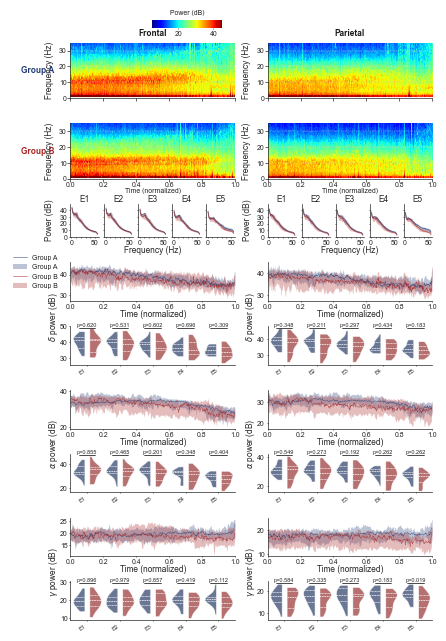

In [ ]:
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from src.eeg_analysis.visualization.plots import plot_continuous_epochs
import seaborn as sns
from scipy.stats import ranksums, ks_2samp


def calculate_statistics(data):
    return np.nanmedian(data, axis=0), (np.nanpercentile(data, 25, axis=0), np.nanpercentile(data, 75, axis=0))

def gen_significance_string(p_value):
    if p_value < 0.001:
        return '***'
    elif p_value < 0.01:
        return '**'
    elif p_value < 0.05:
        return '*'
    else:
        return 'n.s.'

set_custom_style()

DB_BEFORE_AVG = False

BLUE = "#1f3b73"  # Dark Blue
RED = "#a82323"  # Dark Red

curr_regions = ['frontal', 'parietal'] #'prefrontal',

fbands = {
        'delta': [0.5, 4], 
        'theta': [4, 7],
        'alpha': [7, 14] ,  
        'beta': [14, 20], 
        'gamma': [20, 35]
}

fband_names = [
    'delta', 
    # 'theta', 
    'alpha', 
    # 'beta', 
    'gamma'
]

# color = {'delta': 'c',
#          'alpha': 'gray',
#          'beta': 'm'}

# yrange_time_courses = {
#     'delta': [25, 47],
#     'theta': [20, 50],
#     'alpha': [18, 40],
#     'beta': [10, 27],
#     'gamma': [5, 25]
# }

# yrange_violin = {
#     'delta': [25, 55],
#     'theta': [20, 50],             
#     'alpha': [15, 50], 
#     'beta':  [5, 30],
#     'gamma': [5, 25]
# }


rows = 3 + 2*len(fband_names)
cols = len(curr_regions)
fig = plt.figure(figsize=(7*2/3, 10*3/4))
gs = GridSpec(rows, cols, figure=fig, hspace=0.6, wspace=0.2, height_ratios=[1]*2 + [0.6] + [0.7]*2*len(fband_names))

for region_idx , region in enumerate(curr_regions):
    for group_idx, (group, group_name) in enumerate(zip([groups['A'], groups['B']], ["Group A", "Group B"])):
            
        ax_tfr = fig.add_subplot(gs[group_idx, region_idx])

        if DB_BEFORE_AVG:
            curr_tfr = group_avg_tfr_db[group_name][region]
            db_plot = False # avoid further transformation to dB inside the plot function
        else:
            curr_tfr = group_avg_tfr[group_name][region]
            db_plot = True
        
        times = curr_tfr.times
        
        im = plot_continuous_epochs(
            curr_tfr, 
            ax=ax_tfr,
            db = db_plot,
            vmin=5, 
            vmax=45,
            # vmin=-5, 
            # vmax=8, 
            cmap="jet", 
            # title=f"{p_name} TFR"
        ) 
         
        ax_tfr.set_ylabel("Frequency (Hz)", fontsize=6)

        ax_tfr.set_xlim([times[0], times[-1]])
        ax_tfr.set_xticks(np.arange(0, 1.01, 0.2))
        if group_idx == 0:
            ax_tfr.set_xticklabels([])

        if group_idx == 1:
            ax_tfr.set_xlabel('Time (normalized)', labelpad=0)
        
        for spine in ax_tfr.spines.values():
            spine.set_linewidth(0.5)
        # 
        ax_tfr.grid(False)
        ax_tfr.set_ylim([0.5, 35])
        ax_tfr.set_yticks(np.arange(0, 35, 10))
        
        if group_idx == 0:
            ax_tfr.set_title(region.capitalize(), pad = 5, fontsize=6, color='k', fontweight='bold', loc='center')

        if region_idx == 0:
            current_ax_pos = ax_tfr.get_position().bounds
            region_label_pos = [current_ax_pos[0]-0.07, current_ax_pos[1]+current_ax_pos[3]/2, 0.1, 0.1]
            ax_tfr.text(
                region_label_pos[0], region_label_pos[1], group_name, 
                fontsize=6, color=BLUE if 'A' in group_name else RED, fontweight='bold', ha='center', va='center', transform=fig.transFigure
            )

        ax_tfr.tick_params(axis='both', which='major', labelsize=5, length=2, width=0.5, pad=0.5)

        ax_tfr.yaxis.grid(True, which='both', linestyle='--', linewidth=0.3)


    ## Plot for each emergence division the median and bootstrap_sem of the PSD for each group
    ax_psd = fig.add_subplot(gs[2, region_idx])
    # partition the ax_psd into num_divisions subplots
    gs_psd = GridSpecFromSubplotSpec(1, num_divisions, subplot_spec=ax_psd.get_subplotspec(), hspace=0.1)
    ax_psd.set_axis_off()
    for i in range(num_divisions):
        div_ax_psd = fig.add_subplot(gs_psd[0, i])

        if DB_BEFORE_AVG:
            median_A, (q1_A, q3_A) = calculate_statistics(10*np.log10(group_emergnece_division_psd['Group A'][region][i]))
            median_B, (q1_B, q3_B) = calculate_statistics(10*np.log10(group_emergnece_division_psd['Group B'][region][i]))
        else:
            median_A, (q1_A, q3_A) = calculate_statistics(group_emergnece_division_psd['Group A'][region][i])
            median_B, (q1_B, q3_B) = calculate_statistics(group_emergnece_division_psd['Group B'][region][i])

            median_A = 10*np.log10(median_A)
            q1_A = 10*np.log10(q1_A)
            q3_A = 10*np.log10(q3_A)

            median_B = 10*np.log10(median_B)
            q1_B = 10*np.log10(q1_B)
            q3_B = 10*np.log10(q3_B)


        div_ax_psd.plot(freqs, median_A, color=BLUE, label = 'Group A', linewidth=0.5, alpha = 0.7)
        div_ax_psd.fill_between(freqs, q1_A, q3_A, color=BLUE, label='Group A', alpha=0.3, linewidth=0)
        
        div_ax_psd.plot(freqs, median_B, color=RED, label='Group B', linewidth=0.5, alpha = 0.7)
        div_ax_psd.fill_between(freqs, q1_B, q3_B, color=RED, label= 'Group B', alpha=0.3, linewidth=0)

        if i == num_divisions//2:
            div_ax_psd.set_xlabel('Frequency (Hz)', fontsize=6, labelpad=0)
        
        div_ax_psd.set_xticks(np.arange(0, 51, 10))
        
        xtls = div_ax_psd.get_xticklabels()
        xtls_new = ['']*len(xtls)
        xtls_new[0] = xtls[0]
        xtls_new[-1] = xtls[-1]
        div_ax_psd.set_xticklabels(xtls_new)

        div_ax_psd.set_ylim([0, 50])
        div_ax_psd.set_yticks(np.arange(0, 45, 10))
        if i == 0:
            div_ax_psd.set_ylabel('Power (dB)', fontsize=6)
        else:
            div_ax_psd.set_yticklabels([])
        
        if i ==0 and region_idx == 0:
            legend_lines, legend_labels = div_ax_psd.get_legend_handles_labels()

        div_ax_psd.set_title(f'E{i+1}', pad=0, fontsize=6)

        # div_ax_psd.grid(True, which='both', linestyle='--', linewidth=0.3, color='gray')
    

    # frequency band power
    for fband_idx, fband in enumerate(fband_names):

        ax_band_power = fig.add_subplot(gs[3+2*fband_idx, region_idx])
        
        # Plot the time courses of the frequency band powers
        for group_idx, (group, group_name) in enumerate(zip([groups['A'], groups['B']], ["Group A", "Group B"])):
            
            data = np.array([
                    conv_band_powers_smoothed[fband][p_name][region] 
                    for p_name in group 
                    if conv_band_powers_smoothed[fband][p_name][region] is not None and np.any(conv_band_powers_smoothed[fband][p_name][region] > 0.01) 
                ])

            if data.size > 0:
                if DB_BEFORE_AVG:
                    data[data == 0] = 10^-16
                    data = 10*np.log10(data)
                    median, (q1, q3) = calculate_statistics(data)
                else:
                    median, (q1, q3) = calculate_statistics(data)
                    median = 10*np.log10(median)
                    q1 = 10*np.log10(q1)
                    q3 = 10*np.log10(q3)

                conv_band_powers_stats[fband][group_name][region] = {'median': median, 'q1': q1, 'q3': q3}

            ax_band_power.plot(times, conv_band_powers_stats[fband][group_name][region]['median'], color=BLUE if 'A' in group_name else RED, linewidth=0.3, alpha=0.7, label=rf'$\{fband}$ power ' + f'({fbands[fband][0]} - {fbands[fband][1]} Hz)')
            ax_band_power.fill_between(
                times,
                conv_band_powers_stats[fband][group_name][region]['q1'],
                conv_band_powers_stats[fband][group_name][region]['q3'],
                color=BLUE if 'A' in group_name else RED, alpha=0.3, linewidth=0
            )
            ax_band_power.set_xlim([times[0], times[-1]])
            # ax_band_power.set_ylim([yrange_time_courses[fband][0], yrange_time_courses[fband][1]])

            ax_band_power.set_xlabel('Time (normalized)', fontsize=6, labelpad=0)


        # Plot the distribution of average frequency band powers in equal dividsions of the emergence period
        ax_band_power_div = fig.add_subplot(gs[3+2*fband_idx+1, region_idx])

        # emergence division band powers for each group
        # A
        group_A_division_band_powers = group_emergence_division_band_powers[fband]['Group A'][region]
        accepted_A_group_patients = [np.all(patients_div_values > 0.1) for patients_div_values in group_A_division_band_powers]
        
        group_A_division_band_powers = 10*np.log10(group_A_division_band_powers[accepted_A_group_patients])
        # if DB_BEFORE_AVG: 
        #     group_A_division_band_powers = 10*np.log10(group_A_division_band_powers[accepted_A_group_patients])
        # else:
        #     group_A_division_band_powers = group_A_division_band_powers[accepted_A_group_patients]

        # B
        group_B_division_band_powers = group_emergence_division_band_powers[fband]['Group B'][region]
        accepted_B_group_patients = [np.all(patients_div_values > 0.1) for patients_div_values in group_B_division_band_powers]

        group_B_division_band_powers = 10*np.log10(group_B_division_band_powers[accepted_B_group_patients])
        # if DB_BEFORE_AVG:
        #     group_B_division_band_powers = 10*np.log10(group_B_division_band_powers[accepted_B_group_patients])
        # else:
        #     group_B_division_band_powers = group_B_division_band_powers[accepted_B_group_patients]


        data = []
        for i in range(num_divisions):
            data.append(group_A_division_band_powers[:, i])
            data.append(group_B_division_band_powers[:, i])


        sns.violinplot(
            data = data,
            split=True,
            cut=0,
            inner='quart',
            palette = [BLUE, RED]*num_divisions,
            alpha=0.7,
            linewidth=0.5,
            ax=ax_band_power_div,
            edgecolor='white',
            width=0.7
        )

        # if DB_BEFORE_AVG == False:
        #     ax_band_power_div.set_yscale('log')
        #     ax_band_power_div.minorticks_off()


        ylabel = ax_band_power_div.set_ylabel(rf'$\{fband}$ power (dB)', fontsize=6, labelpad=0)
        ylabel_position = ylabel.get_position()
        ylabel.set_position([ylabel_position[0], ylabel_position[1]+0.75])

        ax_band_power_div.set_xticks(np.arange(0, 10, 2)+0.5)
        ax_band_power_div.set_xticklabels(['E1', 'E2', 'E3', 'E4', 'E5'], fontsize=4, rotation=35, va = 'top', ha='right')
        # if fband_idx == len(fband_names)-1:  
        #     ax_band_power_div.set_xticklabels(['E1', 'E2', 'E3', 'E4', 'E5'], fontsize=4, rotation=35, va = 'top', ha='right')
        # else:
        #     ax_band_power_div.set_xticklabels([])

        ax_band_power_div.set_xlim([-0.5, len(data)-0.5])
        # ax_band_power_div.set_ylim([yrange_violin[fband][0], yrange_violin[fband][1]])

        # Perform statistical tests
        yl = ax_band_power_div.get_ylim()
        y = yl[1] - 0.03*(yl[1] - yl[0])
        for i in range(num_divisions):
            # A_vs_B_comparison_stat, A_vs_B_comparison_pval = ks_2samp(group_A_division_band_powers[:, i], group_B_division_band_powers[:, i])
            A_vs_B_comparison_stat, A_vs_B_comparison_pval = ranksums(group_A_division_band_powers[:, i], group_B_division_band_powers[:, i])
            
            ax_band_power_div.plot([i*2, i*2+1], [y, y], color='black', linewidth=0.5)
            ax_band_power_div.text(i*2+0.5, y+0.04*(yl[1]- yl[0]), f'p={A_vs_B_comparison_pval:.3f}', ha='center', fontsize=4)

ax_legend = fig.add_subplot([0, 0.55, 0.1, 0.05])
ax_legend.legend(legend_lines, legend_labels, loc='center', fontsize=5, facecolor = 'black')
ax_legend.spines['bottom'].set_visible(False)
ax_legend.spines['left'].set_visible(False)
ax_legend.set_xticks([])
ax_legend.set_yticks([])
ax_legend.tick_params(bottom=False, left=False)


# Add colorbar
cax = fig.add_subplot([0.3, 0.9, 0.15, 0.01])
cbar = plt.colorbar(im, cax=cax, orientation='horizontal')
cbar.set_label('Power (dB)', fontsize=5)
cbar.ax.xaxis.set_label_position('top')
cbar.outline.set_visible(False)
cbar.ax.tick_params(labelsize=5)

main_dir = 'D:/Anesthesia_Research_Fellow/analysis_results'
filename = 'tfr_avg_groupA_vs_groupB_three_regions_separate_band_power_panels_normalized_power'
if AS_FRACTION_OF_POWER:
    filename += '_fraction_of_power'
if DB_BEFORE_AVG:
    filename += 'db_before_average'
filename += '_all_bands.pdf'

file_path = os.path.join(main_dir, filename)
plt.savefig(file_path, format='pdf', dpi=300)

plt.show()

#### Calculate if each spectral property follows a bimodal distribution

Text(0, 0.5, 'slope')

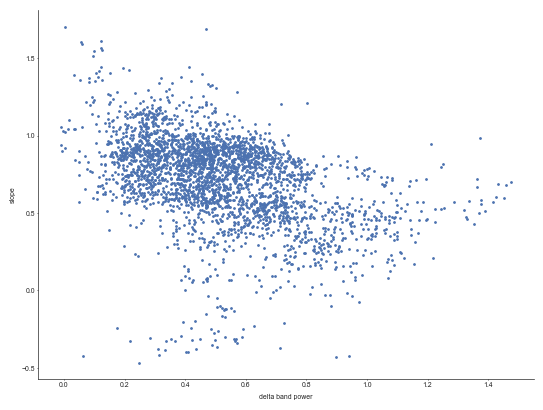

In [14]:
spectral_slope_pooled = [reg_fit_slope[p]['prefrontal']['emergence'] for p in reg_fit_slope]
# spectral_slope_pooled = [reg_fit_slope['CA-04']['prefrontal'][epoch] for epoch in reg_fit_slope['CA-01']['prefrontal']] 
spectral_slope_pooled = np.concatenate(spectral_slope_pooled, axis = 0)

alpha_power_pooled = [fband_power_fooof['alpha'][p]['prefrontal']['emergence'] for p in fband_power_fooof['alpha']]
alpha_power_pooled = np.concatenate(alpha_power_pooled, axis = 0)
alpha_power_pooled[np.isnan(alpha_power_pooled)] = 0

delta_power_pooled = [fband_power_fooof['delta'][p]['prefrontal']['emergence'] for p in fband_power_fooof['delta']]
delta_power_pooled = np.concatenate(delta_power_pooled, axis = 0)

fig=plt.figure()
ax = fig.add_subplot(111)
# ax = fig.add_subplot(111, projection='3d')
ax.scatter(delta_power_pooled, spectral_slope_pooled, s=1) # , alpha_power_pooled, 
ax.set_xlabel('delta band power')
ax.set_ylabel('slope')


##### Store the extracted spectral properties

In [15]:
bands = ['alpha', 'delta', 'beta', 'gamma']
power_categories = {
    "power_reg": fband_power_reg,
    "power_fooof": fband_power_fooof,
    "power_abs": fband_power_abs,
    "central_freq": fband_central_freq
}

patients_pooled_data = {
    "groups": groups,
    "win_center": win_center,
    "psd": psd,
    "reg_fit_slope": reg_fit_slope,
    "fooof_fit_slope": fooof_fit_slope,
    "group_label": group_label
}

# Add the power values to the dictionary dynamically
for category, data in power_categories.items():
    for band in bands:
        key = f"fband_{category}_{band}" if category != "central_freq" else f"fband_central_freq_{band}"
        patients_pooled_data[key] = data[band]



# Save to a file
save_path = "D:/Anesthesia_Research_Fellow/patients_pooled_data.pkl"
joblib.dump(patients_pooled_data, save_path)
print(f"Variables saved to {save_path}")


# patients_pooled_data = joblib.load(save_path)

Variables saved to D:/Anesthesia_Research_Fellow/patients_pooled_data.pkl


#### Temporal evolution of FOOOF-deriven spectral properties during emergence 

In [16]:
import os
import warnings
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
from scipy.stats import ranksums
from matplotlib.gridspec import GridSpec
from scipy.stats import wilcoxon


# Set the normalization flags
NORMALIZE_AMP = False
NORMALIZE_TIME = True
MIN_ACCEPTABLE_VALUE = 0.01
BLUE = "#1f3b73"  # Dark Blue
RED = "#a82323"  # Dark Red

# BLUE = "#28509C"
# RED = "#C53232"

# Spectral property to analyze
spectral_prop_labels = {
    'reg_fit_slope': 'Spectral slope',
    'fband_power_abs_delta': r'$\delta$ abs power',
    # 'fband_power_fooof_delta': r'$\delta$ power',
    'fband_power_fooof_alpha': r'$\alpha$ power',
    'fband_central_freq_alpha': r'$\alpha$ central freq.',
    'fband_power_fooof_beta': r'$\beta$ power',
    'fband_central_freq_beta': r'$\beta$ central freq.',
    # 'fband_power_fooof_gamma': r'$\gamma$ power',
}

def calculate_normalization_factor(win_center_dic, spectral_prop_dict):
    """
    Calculate normalization factor based on pre_infusion values
    """
    pre_infusion_mean_std = {}
    for p, times in win_center_dic.items():
        times = np.asarray(times).flatten()
        curr_vals_spectral_prop = np.asarray(spectral_prop_dict[p]).flatten()
        if np.nansum(curr_vals_spectral_prop) > MIN_ACCEPTABLE_VALUE:  
            pre_infusion_values = curr_vals_spectral_prop#[times < 600]
            pre_infusion_mean_std[p] = (np.nanmean(pre_infusion_values), np.nanstd(pre_infusion_values))
        else:
            pre_infusion_mean_std[p] = (np.nan, np.nan)
            
    return pre_infusion_mean_std

def normalize_time(win_center_dict, spectral_prop_dict, number_target_time_points=1000):
    """
    Normalize time across patients to the same scale for post-event data,
    while keeping pre-event data unchanged.
    
    Args:
        win_center_dict (dict): Dictionary of time windows per patient.
        spectral_prop_dict (dict): Dictionary of spectral properties per patient.
        number_target_time_points (int): The number of target time points (default: 1000).
    
    Returns:
        tuple: Normalized win_center and spectral_prop dictionaries.
    """
    target_time_points = np.linspace(0, 1, number_target_time_points)
    
    spectral_prop_normalized_time = {}
    win_center_normalized_time = {}
    
    for p, times in win_center_dict.items():
        times = np.asarray(times).flatten()
        curr_vals_spectral_prop = np.asarray(spectral_prop_dict[p]).flatten()

        # Normalize original time points to the range [0, 1]
        orig_time_range = times - times.min()
        orig_time_range = orig_time_range / orig_time_range.max()
        
        # Interpolate spectral property values to match target time points
        normalized_vals = np.interp(target_time_points, orig_time_range, curr_vals_spectral_prop)
        
        # Store normalized times and values
        win_center_normalized_time[p] = target_time_points
        spectral_prop_normalized_time[p] = normalized_vals
    
    return win_center_normalized_time, spectral_prop_normalized_time

# def normalize_time(win_center_dict, spectral_prop_dict, event_time=600):
#     """
#     Normalize time across patients to the same scale for post-event data,
#     while keeping pre-event data unchanged.
    
#     Args:
#         win_center_dict (dict): Dictionary of time windows per patient.
#         spectral_prop_dict (dict): Dictionary of spectral properties per patient.
#         event_time (float): The time of the event in seconds (default: 600 seconds).
    
#     Returns:
#         tuple: Normalized win_center and spectral_prop dictionaries.
#     """
#     # Determine the number of post-event time points based on the patient with the longest post-event time
#     max_patient = max(win_center_dict, key=lambda k: np.sum(np.array(win_center_dict[k]) > event_time))
#     num_post_event_points = np.sum(np.array(win_center_dict[max_patient]) > event_time)
#     max_post_event_time = win_center_dict[max_patient][-1]
    
#     # Create a normalized time scale for the post-event segment
#     all_win_centers_post_event = np.linspace(event_time, max_post_event_time, num_post_event_points)

#     spectral_prop_normalized_time = {}
#     win_center_normalized_time = {}
    
#     for p, times in win_center_dict.items():
#         times = np.asarray(times).flatten()
#         curr_vals_spectral_prop = np.asarray(spectral_prop_dict[p]).flatten()
        
#         # Split pre-event and post-event data
#         pre_event_mask = times <= event_time
#         post_event_mask = times > event_time
        
#         pre_event_times = times[pre_event_mask]
#         post_event_times = times[post_event_mask]
        
#         pre_event_vals = curr_vals_spectral_prop[pre_event_mask]
#         post_event_vals = curr_vals_spectral_prop[post_event_mask]
        
#         # Interpolate post-event values to match normalized time points
#         if len(post_event_times) > 0:
#             new_post_event_times = np.linspace(post_event_times[0], post_event_times[-1], num_post_event_points)
#             normalized_post_event_vals = np.interp(new_post_event_times, post_event_times, post_event_vals)
#         else:
#             new_post_event_times = []
#             normalized_post_event_vals = []
        
#         # Combine pre-event and post-event data
#         combined_times = np.concatenate((pre_event_times, all_win_centers_post_event))
#         combined_vals = np.concatenate((pre_event_vals, normalized_post_event_vals))
        
#         win_center_normalized_time[p] = combined_times
#         spectral_prop_normalized_time[p] = combined_vals

#     return win_center_normalized_time, spectral_prop_normalized_time

def bootstrap_sem(data, num_bootstrap=1000, axis=0):
    n = data.shape[1]
    boot_medians = np.zeros((num_bootstrap, n))
    for i in range(num_bootstrap):
        samples = np.random.choice(data.shape[0], size=data.shape[0], replace=True)
        boot_medians[i, :] = np.nanmedian(data[samples, :], axis=axis)
    return np.nanstd(boot_medians, axis=0, ddof=1)

def align_and_average(win_center_dict, spectral_prop_dict, normalize_factor):

    # This function calculates the averages regardless of whether the time was normalized.

    all_win_centers = sorted(set().union(*win_center_dict.values()))
        
    avg_dict = {}
    for p, times in win_center_dict.items():
        try:
            times = np.asarray(times).flatten()
            curr_vals_spectral_prop = np.asarray(spectral_prop_dict[p]).flatten()
            if np.nansum(curr_vals_spectral_prop) > MIN_ACCEPTABLE_VALUE:  # Ensure the current values of the spectral prop are not entirely zero

                interpolated_spectral_prop_values = np.interp(all_win_centers, times, curr_vals_spectral_prop)
                interpolated_spectral_prop_values[all_win_centers > times[-1]] = np.nan
                
                if NORMALIZE_AMP:
                    interpolated_spectral_prop_values = apply_normalization(interpolated_spectral_prop_values, normalize_factor[p])
                    # mean, _ = normalize_factor[p]
                    # interpolated_spectral_prop_values = interpolated_spectral_prop_values - mean
                    
                avg_dict[p] = interpolated_spectral_prop_values
        except Exception as e:
            warnings.warn(f"Warning: An error occurred while aligning and averaging for patient {p}: {e}", UserWarning)
    
    # Stack all patient data together
    data = np.vstack(list(avg_dict.values()))
    
    # Non-parametric median
    median_all = np.nanmedian(data, axis=0)
    
    # Bootstrapped SEM
    sem_all = bootstrap_sem(data, axis=0)

    # lower and upper quartiles
    q1_all = np.nanpercentile(data, 25, axis=0)
    q3_all = np.nanpercentile(data, 75, axis=0)
    
    return np.array(all_win_centers), median_all, sem_all, q1_all, q3_all

def flatten_and_filter(data):
    flatten_data = []
    for sublist in data:
        if isinstance(sublist, (list, np.ndarray)):
            for item in sublist:
                if item is not None: 
                    flatten_data.append(item)
        elif isinstance(sublist, (float, int, np.float64, np.int64)):  
            flatten_data.append(sublist)
    return flatten_data

def z_score(data, mean_std):
    mean, std = mean_std
    return (data - mean) / std

def apply_normalization(data, mean_std):
    if NORMALIZE_AMP:
        # mean, _ = mean_std
        return z_score(data, mean_std)
        # return data - mean
    return data

def calculate_quartiles(data_dict, num_divisions):
    quartile_data = {}
    for p, data in data_dict.items():
        if len(data) >= num_divisions:
            quartiles = np.array_split(data, num_divisions)
            quartile_avg = [np.nanmean(q) for q in quartiles]
        else:
            quartile_avg = [np.nan] * num_divisions
        quartile_data[p] = quartile_avg
    return quartile_data


region_names = ['prefrontal', 'frontal', 'parietal']

# Calculate the y-axis lower and upper bound for the plots
win_center_emergence_all_regions = {}
spectral_prop_time_course_emergence_all_regions = {}
norm_spectral_prop_post_drug_all_regions = {}
time_coureses_stats = {} # Stores median, sem, q1, and q3 for both groups A and B

num_divisions = 5


# Y-axis bounds
ylim_lower_bound = {}
ylim_upper_bound = {}

for spectral_prop_name in spectral_prop_labels:
    spectral_prop = patients_pooled_data[spectral_prop_name]

    win_center_emergence_all_regions[spectral_prop_name] = {}
    spectral_prop_time_course_emergence_all_regions[spectral_prop_name] = {}
    norm_spectral_prop_post_drug_all_regions[spectral_prop_name] = {}
    time_coureses_stats[spectral_prop_name] = {}
    
    region_ylim = {}
    for region in region_names:
         
        win_center_emergence = {
            p: win_center[p][region]['emergence']
            for p in win_center
            if np.nansum(spectral_prop[p][region]['emergence']) > MIN_ACCEPTABLE_VALUE
        }

        spectral_prop_time_course_emergence = {
            p: spectral_prop[p][region]['emergence']
            for p in spectral_prop
            if np.nansum(spectral_prop[p][region]['emergence']) > MIN_ACCEPTABLE_VALUE
        }

        ###
        # Split data into pre_drug_infusion and emergence periods
        win_center_pre_drug = {p: times[times < 600] for p, times in win_center_emergence.items()}
        win_center_post_drug = {p: times[times >= 600] for p, times in win_center_emergence.items()}
        spectral_prop_pre_drug = {p: props[:len(win_center_pre_drug[p])] for p, props in spectral_prop_time_course_emergence.items()}
        spectral_prop_post_drug = {p: props[len(win_center_pre_drug[p]):] for p, props in spectral_prop_time_course_emergence.items()}
        ###

        if NORMALIZE_TIME:
            # win_center_emergence, spectral_prop_time_course_emergence = normalize_time(
            #     win_center_emergence, spectral_prop_time_course_emergence
            # )
            win_center_pre_drug, spectral_prop_pre_drug = normalize_time(win_center_pre_drug, spectral_prop_pre_drug)
            win_center_post_drug, spectral_prop_post_drug = normalize_time(win_center_post_drug, spectral_prop_post_drug)


        # Calculate normalization factor for each patient
        normalize_factor = calculate_normalization_factor(win_center_pre_drug, spectral_prop_pre_drug)
        norm_spectral_prop_post_drug = {
            p: apply_normalization(
                spectral_prop_post_drug[p],
                normalize_factor[p]
            )
            for p in win_center_post_drug
        }
        # normalize_factor = calculate_normalization_factor(win_center_emergence, spectral_prop_time_course_emergence)
        # norm_spectral_prop_post_drug = {
        #     p: apply_normalization(
        #         spectral_prop_time_course_emergence[p],
        #         normalize_factor[p]
        #     )
        #     for p in win_center_emergence
        # }

        # Split data by group
        groupA_win_centers = {p: win_center_post_drug[p] for p in group_label if group_label[p] == 'A' and p in win_center_post_drug}
        groupB_win_centers = {p: win_center_post_drug[p] for p in group_label if group_label[p] == 'B' and p in win_center_post_drug}
        groupA_spectral_prop_data = {p: spectral_prop_post_drug[p] for p in group_label if group_label[p] == 'A' and p in spectral_prop_post_drug}
        groupB_spectral_prop_data = {p: spectral_prop_post_drug[p] for p in group_label if group_label[p] == 'B' and p in spectral_prop_post_drug}

        (
            avg_win_centers_A,
            median_spectral_prop_groupA,
            sem_spectral_prop_groupA,
            q1_spectral_prop_groupA,
            q3_spectral_prop_groupA
        ) = align_and_average(
            groupA_win_centers,
            groupA_spectral_prop_data,
            normalize_factor
        )
        
        (
            avg_win_centers_B, 
            median_spectral_prop_groupB, 
            sem_spectral_prop_groupB, 
            q1_spectral_prop_groupB, 
            q3_spectral_prop_groupB
        )= align_and_average(
            groupB_win_centers, 
            groupB_spectral_prop_data, 
            normalize_factor
        )

        # Determine the region bounds based on the calculated percentiles
        lower_percentiles = np.concatenate([q1_spectral_prop_groupA, q1_spectral_prop_groupB], axis = 0)
        upper_percentiles = np.concatenate([q3_spectral_prop_groupA, q3_spectral_prop_groupB], axis = 0)
        
        region_ylim[region] = [np.nanmin(lower_percentiles), np.nanmax(upper_percentiles)]

        win_center_emergence_all_regions[spectral_prop_name][region] = win_center_post_drug

        # spectral_prop_time_course_emergence_all_regions[spectral_prop_name][region] = spectral_prop_time_course_emergence
        norm_spectral_prop_post_drug_all_regions[spectral_prop_name][region] = norm_spectral_prop_post_drug


        # Statistical analysis

        # (1) Compare the distribution of spectral property values at each post-drug infusion time point against the average during the pre-drug infusion period, separately for groups A and B
        groupA_p_values_agaisnt_pre_drug = []
        groupB_p_values_agaisnt_pre_drug = []

        # Perform signed-rank test for each time point and add significance asterisks
        for i, time_point in enumerate(avg_win_centers_A):
            groupA_pre_drug_values = [
                np.nanmean(spectral_prop_pre_drug[p])
                for p in group_label if group_label[p] == 'A' and p in spectral_prop_pre_drug
            ]
            groupB_pre_drug_values = [
                np.nanmean(spectral_prop_pre_drug[p])
                for p in group_label if group_label[p] == 'B' and p in spectral_prop_pre_drug
            ]
            
            groupA_post_drug_values = [
                norm_spectral_prop_post_drug[p][i]
                for p in group_label if group_label[p] == 'A' and p in norm_spectral_prop_post_drug
            ]
            groupB_post_drug_values = [
                norm_spectral_prop_post_drug[p][i]
                for p in group_label if group_label[p] == 'B' and p in norm_spectral_prop_post_drug
            ]
            
            valid_groupA_indices = [j for j in range(len(groupA_pre_drug_values)) if not np.isnan(groupA_pre_drug_values[j]) and not np.isnan(groupA_post_drug_values[j])]
            valid_groupB_indices = [j for j in range(len(groupB_pre_drug_values)) if not np.isnan(groupB_pre_drug_values[j]) and not np.isnan(groupB_post_drug_values[j])]
            
            valid_groupA_pre_drug_values = [groupA_pre_drug_values[j] for j in valid_groupA_indices]
            valid_groupA_post_drug_values = [groupA_post_drug_values[j] for j in valid_groupA_indices]
            valid_groupB_pre_drug_values = [groupB_pre_drug_values[j] for j in valid_groupB_indices]
            valid_groupB_post_drug_values = [groupB_post_drug_values[j] for j in valid_groupB_indices]
            
            if valid_groupA_pre_drug_values and valid_groupA_post_drug_values:
                groupA_p_value = wilcoxon(valid_groupA_post_drug_values, valid_groupA_pre_drug_values).pvalue
                groupA_p_values_agaisnt_pre_drug.append(groupA_p_value)
            else:
                groupA_p_values_agaisnt_pre_drug.append(np.nan)
            
            if valid_groupB_pre_drug_values and valid_groupB_post_drug_values:
                groupB_p_value = wilcoxon(valid_groupB_post_drug_values, valid_groupB_pre_drug_values).pvalue
                groupB_p_values_agaisnt_pre_drug.append(groupB_p_value)
            else:
                groupB_p_values_agaisnt_pre_drug.append(np.nan)

        # (2) Compare the distribution of spectral property values between groups A and B at each post-drug infusion time point
        groupA_p_values_agaisnt_groupB = []
        for i, time_point in enumerate(avg_win_centers_A):
            groupA_values = [
                norm_spectral_prop_post_drug[p][i]
                for p in group_label if group_label[p] == 'A' and p in norm_spectral_prop_post_drug
            ]
            groupB_values = [
                norm_spectral_prop_post_drug[p][i]
                for p in group_label if group_label[p] == 'B' and p in norm_spectral_prop_post_drug
            ]
            
            valid_groupA_values = [j for j in groupA_values if not np.isnan(j)]
            valid_groupB_values = [j for j in groupB_values if not np.isnan(j)]

            if valid_groupA_values and valid_groupB_values:
                curr_p_value = ranksums(valid_groupA_values, valid_groupB_values).pvalue
                groupA_p_values_agaisnt_groupB.append(curr_p_value)
            else:
                groupA_p_values_agaisnt_groupB.append(np.nan)

        # Calculate the distribution of spectral property values in equal divisions of the emergence period
        group_A_emergence_division_spectral_prop = calculate_quartiles(
            {
                p: norm_spectral_prop_post_drug[p] 
                for p in group_label if group_label[p] == 'A' 
                and p in norm_spectral_prop_post_drug
            }, num_divisions)
        
        group_B_emergence_division_spectral_prop = calculate_quartiles(
            {
                p: norm_spectral_prop_post_drug[p] 
                for p in group_label if group_label[p] == 'B' 
                and p in norm_spectral_prop_post_drug
            }, num_divisions)

        # Store the average, median, sem, q1, and q3, and comparsion stats for groups A and B
        time_coureses_stats[spectral_prop_name][region] = {
            'A': (
                avg_win_centers_A, 
                median_spectral_prop_groupA, 
                sem_spectral_prop_groupA, 
                q1_spectral_prop_groupA, 
                q3_spectral_prop_groupA, 
                groupA_p_values_agaisnt_pre_drug,
                group_A_emergence_division_spectral_prop
            ),
            'B': (
                avg_win_centers_B, 
                median_spectral_prop_groupB, 
                sem_spectral_prop_groupB, 
                q1_spectral_prop_groupB, 
                q3_spectral_prop_groupB, 
                groupB_p_values_agaisnt_pre_drug,
                group_B_emergence_division_spectral_prop
            ),
            'A vs B': groupA_p_values_agaisnt_groupB
        }
    
    ylims_all_regions = np.vstack(list(region_ylim.values()))
    ylim_lower_bound[spectral_prop_name] = np.nanmin(ylims_all_regions[:, 0])
    ylim_upper_bound[spectral_prop_name] = np.nanmax(ylims_all_regions[:, 1])

C:\Users\Kourosh\AppData\Local\Temp\ipykernel_5268\1293548490.py:215: RuntimeWarning: Mean of empty slice
  quartile_avg = [np.nanmean(q) for q in quartiles]
C:\Users\Kourosh\AppData\Local\Temp\ipykernel_5268\1293548490.py:349: RuntimeWarning: Mean of empty slice
  np.nanmean(spectral_prop_pre_drug[p])
C:\Users\Kourosh\AppData\Local\Temp\ipykernel_5268\1293548490.py:145: RuntimeWarning: All-NaN slice encountered
  boot_medians[i, :] = np.nanmedian(data[samples, :], axis=axis)
C:\Users\Kourosh\AppData\Local\Temp\ipykernel_5268\1293548490.py:345: RuntimeWarning: Mean of empty slice
  np.nanmean(spectral_prop_pre_drug[p])


#### Plot

C:\Users\Kourosh\AppData\Local\Temp\ipykernel_5268\4024785057.py:281: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


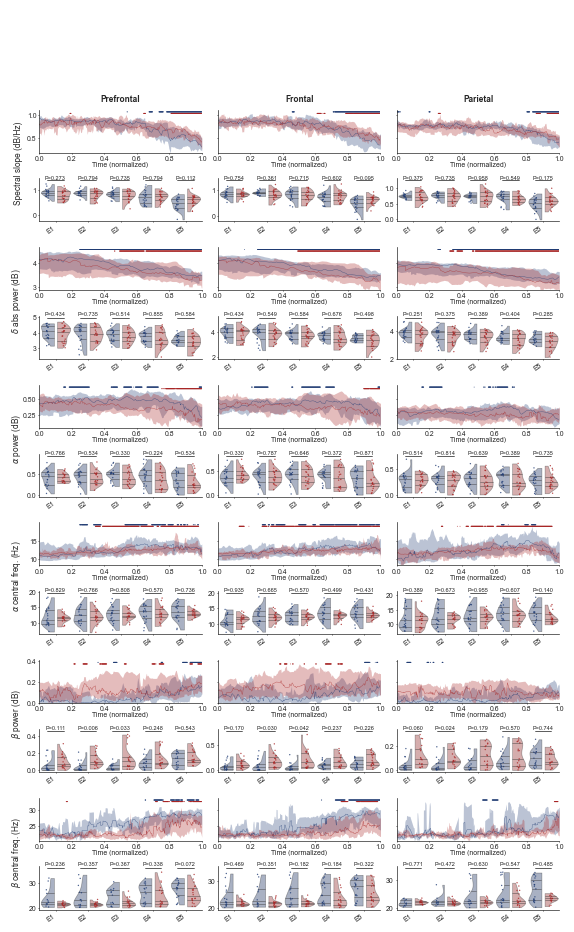

In [18]:
# Convert HEX to RGB
def hex_to_rgb(hex_color):
    hex_color = hex_color.lstrip('#')
    return tuple(int(hex_color[i:i+2], 16) / 255.0 for i in (0, 2, 4))

def remove_outliers(data, method='iqr', threshold=1.5):
    """
    Remove outliers from a list of data using the specified method.
    Supports 'iqr' (Interquartile Range) or 'std' (Standard Deviation).
    """
    data = np.array(data)
    if method == 'iqr':
        # IQR method
        q1, q3 = np.nanpercentile(data, [25, 75])
        iqr = q3 - q1
        lower_bound = q1 - threshold * iqr
        upper_bound = q3 + threshold * iqr
    elif method == 'std':
        # Standard Deviation method
        mean = np.nanmean(data)
        std_dev = np.nanstd(data)
        lower_bound = mean - threshold * std_dev
        upper_bound = mean + threshold * std_dev
    else:
        raise ValueError("Invalid method. Choose 'iqr' or 'std'.")
    
    # Filter data
    return data[(data >= lower_bound) & (data <= upper_bound)]

def bootstrap_p_value(sample1, sample2, num_resamples=1000):
    """
    Calculate the bootstrap p-value for the difference in medians between two samples.

    Parameters:
        sample1 (array-like): First sample data.
        sample2 (array-like): Second sample data.
        num_resamples (int): Number of bootstrap resamples.

    Returns:
        p_value (float): The bootstrap p-value for the difference in medians.
    """
    # Combine the two samples under the null hypothesis
    combined = np.concatenate([sample1, sample2])
    
    # Compute the observed median difference
    observed_diff = np.median(sample1) - np.median(sample2)
    
    # Initialize bootstrap resamples
    bootstrap_diffs = []
    
    for _ in range(num_resamples):
        # Resample with replacement from the combined dataset
        resample1 = np.random.choice(combined, size=len(sample1), replace=True)
        resample2 = np.random.choice(combined, size=len(sample2), replace=True)
        
        # Compute the median difference for the resample
        bootstrap_diffs.append(np.median(resample1) - np.median(resample2))
    
    # Convert to a NumPy array
    bootstrap_diffs = np.array(bootstrap_diffs)
    
    # Calculate the p-value as the proportion of resamples with |difference| >= |observed_diff|
    p_value = np.mean(np.abs(bootstrap_diffs) >= np.abs(observed_diff))
    
    return p_value


# Define figure properties
# Modify the style of the plots. Adding an extra row for each spectral property for the violin plots for the division of the emergence period
ncols = 3
nrows = len(spectral_prop_labels)*2 #int(np.ceil(len(region_names) / ncols)) * (len(spectral_prop_labels)+1)
plot_width = 6.5*72 
plot_height = 60 * nrows

set_custom_style()  # Assuming this is defined separately

fig, axs = plt.subplots(
    nrows=nrows, 
    ncols=ncols, 
    figsize=(plot_width / 72, plot_height / 72), 
    # sharex=True, 
    height_ratios = [1]*len(spectral_prop_labels)*2 #+ [0.25] + [1]*len(spectral_prop_labels)*2 + [0.25]
)
axs = axs.flatten()  # Flatten the axes for easier indexing

# Loop over each region to plot emergence data
for region_idx, region in enumerate(region_names):
    for sp_idx, spectral_prop_name in enumerate(spectral_prop_labels):
        
        col = region_idx % ncols  # Column index
        row = (region_idx // ncols) * (len(spectral_prop_labels)+1) + 2*sp_idx   # Row index
        curr_ax = axs[row * ncols + col]  # Access the subplot

        groupA_data = time_coureses_stats[spectral_prop_name][region]['A']
        groupB_data = time_coureses_stats[spectral_prop_name][region]['B']
        
        (
            avg_win_centers_A, 
            median_spectral_prop_groupA, 
            sem_spectral_prop_groupA, 
            q1_spectral_prop_groupA, 
            q3_spectral_prop_groupA, 
            groupA_p_values_agaisnt_pre_drug,
            groupA_division_spectral_prop
        ) = groupA_data

        (
            avg_win_centers_B, 
            median_spectral_prop_groupB, 
            sem_spectral_prop_groupB, 
            q1_spectral_prop_groupB, 
            q3_spectral_prop_groupB, 
            groupB_p_values_agaisnt_pre_drug,
            groupB_division_spectral_prop
        ) = groupB_data

        # Plot the median time courses
        curr_ax.plot(avg_win_centers_A, 
                     median_spectral_prop_groupA, 
                     '-', 
                     color=BLUE, 
                     linewidth=0.3, 
                     alpha=0.7,
                     label='Group A'
                    )
        
        curr_ax.fill_between(avg_win_centers_A, 
                             q1_spectral_prop_groupA, 
                             q3_spectral_prop_groupA, 
                             color=BLUE,
                             linewidth=0, 
                             alpha=0.3)
        
        curr_ax.plot(avg_win_centers_B, 
                     median_spectral_prop_groupB, 
                     '-', 
                     color=RED, 
                     linewidth=0.3,
                     alpha=0.7, 
                     label='Group B'
                    )
        
        curr_ax.fill_between(avg_win_centers_B, 
                             q1_spectral_prop_groupB, 
                             q3_spectral_prop_groupB, 
                             color=RED,
                             linewidth=0, 
                             alpha=0.3)
        
        if sp_idx == 0:
            curr_ax.set_title(f"{region.capitalize()}", loc='center', fontweight='bold')
        
        if region_idx == 0:
            curr_ax.yaxis.set_label_coords(-0.1, 0.5)
            if NORMALIZE_AMP:
                ylabel=curr_ax.set_ylabel(f'{spectral_prop_labels[spectral_prop_name]} (normalized)', labelpad=0, fontsize=6)
            else:
                if spectral_prop_name == 'reg_fit_slope':
                    ylabel=curr_ax.set_ylabel(f'{spectral_prop_labels[spectral_prop_name]} (dB/Hz)', labelpad=0, fontsize=6)
                elif 'power' in spectral_prop_name:
                    ylabel=curr_ax.set_ylabel(f'{spectral_prop_labels[spectral_prop_name]} (dB)', labelpad=0, fontsize=6)
                elif 'freq' in spectral_prop_name:
                    ylabel=curr_ax.set_ylabel(f'{spectral_prop_labels[spectral_prop_name]} (Hz)', labelpad=0, fontsize=6)
            
            ylabel_position = ylabel.get_position()
            ylabel.set_position([ylabel_position[0], ylabel_position[1]-0.75])


        # curr_ax.set_xticks(np.arange(0, win_center_emergence['CA-01'][-1], 1000))
        curr_ax.set_xticks(np.arange(0, 1.01, .2))
        curr_ax.set_xlim([0, 1])
        # if sp_idx == len(spectral_prop_labels)-1:
        curr_ax.set_xlabel('Time (normalized)', labelpad=0)

        curr_ax.set_ylim([ylim_lower_bound[spectral_prop_name], ylim_upper_bound[spectral_prop_name]])
        if region_idx != 0:
            curr_ax.set_yticklabels([])

        curr_ax.spines['top'].set_visible(False)
        curr_ax.spines['right'].set_visible(False)
        
        # plot the significance lines
        # increase the ylim a bit to afford the significance lines
        yl_old = curr_ax.get_ylim()
        curr_ax.set_ylim([yl_old[0], yl_old[1] + 0.1*(yl_old[1] - yl_old[0])])
        yl = curr_ax.get_ylim()

        # (1) Group A vs Pre-drug infusion
        significance_line_y = 1.04*(yl_old[1] - yl_old[0]) + yl_old[0]
        diff_time = avg_win_centers_A[1] - avg_win_centers_A[0]
        significant_points = np.array([time_point for i, time_point in enumerate(avg_win_centers_A) if groupA_p_values_agaisnt_pre_drug[i] < 0.05])
        color_intensities = 1 - (np.array([groupA_p_values_agaisnt_pre_drug[i] for i in range(len(avg_win_centers_A)) if groupA_p_values_agaisnt_pre_drug[i] < 0.05]) / 0.05)
        curr_ax.scatter(significant_points, [significance_line_y]*len(significant_points), color=[(*hex_to_rgb(BLUE)[:3], ci) for ci in color_intensities], s=0.5, linewidths=0, alpha=0.7)

        # (2) Group B vs Pre-drug infusion

        significance_line_y = 1*(yl_old[1] - yl_old[0]) + yl_old[0]
        significant_points = np.array([time_point for i, time_point in enumerate(avg_win_centers_B) if groupB_p_values_agaisnt_pre_drug[i] < 0.05])
        color_intensities = 1 - (np.array([groupB_p_values_agaisnt_pre_drug[i] for i in range(len(avg_win_centers_B)) if groupB_p_values_agaisnt_pre_drug[i] < 0.05]) / 0.05)
        curr_ax.scatter(significant_points, [significance_line_y]*len(significant_points), color=[(*hex_to_rgb(RED)[:3], ci) for ci in color_intensities], s=0.5, linewidths=0, alpha=0.7)

        # (3) Group A vs Group B
        groupA_p_values_agaisnt_groupB = time_coureses_stats[spectral_prop_name][region]['A vs B']

        significance_line_y = 1.08*(yl_old[1] - yl_old[0]) + yl_old[0]
        significant_points = np.array([time_point for i, time_point in enumerate(avg_win_centers_A) if groupA_p_values_agaisnt_groupB[i] < 0.05])
        color_intensities = 1 - (np.array([groupA_p_values_agaisnt_groupB[i] for i in range(len(avg_win_centers_A)) if groupA_p_values_agaisnt_groupB[i] < 0.05]) / 0.05)
        # curr_ax.scatter(significant_points, [significance_line_y]*len(significant_points), color='k', s=0.5, linewidths=0, alpha=0.7)



        # Add the violin plots for the division of the emergence period
        row = (region_idx // ncols) * (len(spectral_prop_labels)+1) + 2*sp_idx + 1
        curr_ax = axs[row * ncols + col]  # Access the subplot


        # Prepare data for violinplot: Div1 A and B, Div2 A and B, etc.
        combined_group_division_data = []
        colors = []
        for div in range(num_divisions):
            div_data_A = [groupA_division_spectral_prop[p][div] for p in groupA_division_spectral_prop]
            div_data_B = [groupB_division_spectral_prop[p][div] for p in groupB_division_spectral_prop]
            div_data_A = remove_outliers(div_data_A)
            div_data_B = remove_outliers(div_data_B)
            combined_group_division_data.append(div_data_A)
            combined_group_division_data.append(div_data_B)
            colors.extend([BLUE, RED])
          

        # Plot quartile emergence data
        sns.violinplot(data=combined_group_division_data, ax=curr_ax, cut=0, inner='quart', density_norm='area', palette=colors, linewidth=0.5, alpha=0.4, split=True)
        sns.stripplot(data=combined_group_division_data, ax=curr_ax, jitter=True, edgecolor='auto', size=1, palette=colors, alpha=0.8)
        # curr_ax.set_xticks(np.arange(0.5, 2*num_divisions+0.6, 2))
        # if sp_idx == len(spectral_prop_labels)-1:
        #     curr_ax.set_xticklabels([f'E{x+1}' for x in range(num_divisions)])
        # else:
        #     curr_ax.set_xticklabels('')

        for line in curr_ax.lines:
            line.set_linestyle('-')
            line.set_linewidth(0.4)
            line.set_alpha(0.7)

        # curr_ax.set_xticklabels([f'E{div}' for div in range(num_divisions)])

        # Perform ranksum test and add significance line for each division
        yl = curr_ax.get_ylim()
        significance_line_y = 1.05*(yl[1] - yl[0]) + yl[0] 
        for i in range(num_divisions):
            div_data_A = [groupA_division_spectral_prop[p][i] for p in groupA_division_spectral_prop]
            div_data_B = [groupB_division_spectral_prop[p][i] for p in groupB_division_spectral_prop]
            try:
                div_data_A = [x for x in div_data_A if ~np.isnan(x)]
                div_data_B = [x for x in div_data_B if ~np.isnan(x)]
                # div_p_value = bootstrap_p_value(div_data_A, div_data_B, num_resamples=10000)
                div_p_value = ranksums(div_data_A, div_data_B).pvalue
                curr_ax.plot([i * 2, (i * 2) + 1], [significance_line_y, significance_line_y], color='k', lw=0.5)
                curr_ax.text(i * 2 + 0.5, significance_line_y * 1.03, f'P={div_p_value:.3f}', ha='center', fontsize=4)
            except ValueError:
                continue

        curr_ax.set_xticks(np.arange(0, 2*num_divisions, 2)+0.5)
        curr_ax.set_xticklabels([f'E{x+1}' for x in range(num_divisions)], fontsize=5, rotation=35, va = 'top', ha='right')
        curr_ax.set_xlim([-0.5, 2*num_divisions-0.5])

    if region_idx == 0:
        ax_legend = fig.add_subplot([0.7, 0.95, 0.1, 0.05])
        legend_lines, legend_labels = curr_ax.get_legend_handles_labels()
        ax_legend.legend(legend_lines, legend_labels, loc='center', fontsize=5)
        ax_legend.spines['bottom'].set_visible(False)
        ax_legend.spines['left'].set_visible(False)
        ax_legend.set_xticks([])
        ax_legend.set_yticks([])
        ax_legend.tick_params(bottom=False, left=False)
        ax_legend.set_facecolor('none')

    # row = (region_idx // ncols) * (len(spectral_prop_labels)+1) + len(spectral_prop_labels) 
    # curr_ax = axs[row * ncols + col]  
    # curr_ax.remove()

plt.tight_layout()
plt.subplots_adjust(left=0.15, right= 0.95, bottom=0.1, top=0.9, wspace=0.1, hspace=0.6)

main_dir = 'D:/Anesthesia_Research_Fellow/analysis_results'

filename = 'emergence_trajectory_groupA_vs_groupB'
if NORMALIZE_AMP:
    filename += '_normalized_to_pre_infusion'
if NORMALIZE_TIME:
    filename += '_time_normalized'
filename += '_delta_abs_v2.pdf'
# filename += '_delta_actual_power.pdf'

file_path = os.path.join(main_dir, filename)
plt.savefig(file_path, format='pdf', dpi=300)

plt.show()

##### Plot PSDs without any normalization for the pre_drug_infusion and each emergence quartile 
* This can come before the above analysis to give us a hint about the shape of the power spectral densities without any further processings 

NameError: name 'patients_pooled_data' is not defined

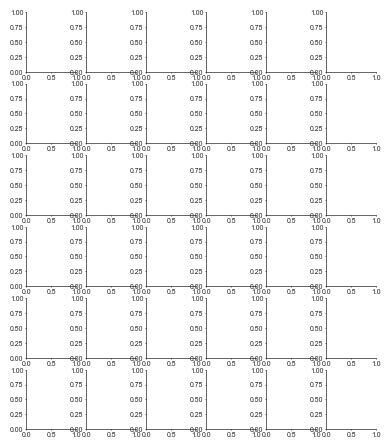

In [13]:
# Function to calculate quartiles
def cal_psd_quartiles(psd_dict, times_dict, num_quartiles=4, start_time=600):
    pre_drug_infusion_psds = {}
    emergence_quartile_psds = {}
    for p, psds in psd_dict.items():
        times = np.asarray(times_dict[p])

        # Processing pre drug infusion PSDs
        pre_drug_psds = psds[:, times < start_time, 0]
        pre_drug_psds[pre_drug_psds == 0] = 1e-16
        pre_drug_psds = 10*np.log10(pre_drug_psds)

        pre_drug_infusion_psds[p] = np.nanmedian(pre_drug_psds, axis=1)

        # Processing emergence PSDs
        emergence_psds = psds[:, times > start_time, 0]
        emergence_psds[emergence_psds == 0] = 1e-16
        emergence_psds = 10*np.log10(emergence_psds)

        if len(emergence_psds) >= num_quartiles:
            quartiles = np.array_split(emergence_psds, num_quartiles, axis=1)
            emergence_quartile_psds[p] = [np.nanmedian(q, axis=1) for q in quartiles]
        else:
            emergence_quartile_psds[p] = [np.nan] * num_quartiles
    
    # Calculating the median and sem of PSD across all patients
    # Pre-drug infusion
    pre_drug_data = np.vstack(list(pre_drug_infusion_psds.values()))
    pre_drug_median_psd = np.nanmedian(pre_drug_data, axis=0)
    pre_drug_sem_psd = bootstrap_sem(pre_drug_data, num_bootstrap=1000, axis=0)
    pre_drug_q1_psd = np.nanpercentile(pre_drug_data, 25, axis=0)
    pre_drug_q3_psd = np.nanpercentile(pre_drug_data, 75, axis=0)

    emergence_quartile_median_psd = [None] * num_quartiles
    emergence_quartile_sem_psd = [None] * num_quartiles
    emergence_quartile_q1_psd = [None] * num_quartiles
    emergence_quartile_q3_psd = [None] * num_quartiles
    for q in range(num_quartiles):
        quartile_data = np.vstack([emergence_quartile_psds[p][q] for p in emergence_quartile_psds])
        
        emergence_quartile_median_psd[q] = np.nanmedian(quartile_data, axis=0)
        emergence_quartile_sem_psd[q] = bootstrap_sem(quartile_data, num_bootstrap=1000, axis=0)
        emergence_quartile_q1_psd[q] = np.nanpercentile(quartile_data, 25, axis=0)
        emergence_quartile_q3_psd[q] = np.nanpercentile(quartile_data, 75, axis=0)
    
    return (
        pre_drug_infusion_psds, 
        pre_drug_median_psd, 
        pre_drug_sem_psd,
        pre_drug_q1_psd,
        pre_drug_q3_psd,
        emergence_quartile_psds, 
        emergence_quartile_median_psd, 
        emergence_quartile_sem_psd, 
        emergence_quartile_q1_psd, 
        emergence_quartile_q3_psd
    )

freqs = loaded_power_spectral.frequencies
num_emergence_divisions = 5
BLUE = "#1f3b73"  # Dark Blue
RED = "#a82323"  # Dark Red

# Create a new figure for violin plots
plot_width = 65*num_emergence_divisions
plot_height = 65 * len(region_names)
fig, axs = plt.subplots(len(region_names), 1+num_emergence_divisions, figsize=(plot_width/72, plot_height/72))

psd = patients_pooled_data['psd']
yl = [0, 50]
shift = 0

for region_idx, region in enumerate(region_names):
    win_center_emergence = {p: win_center[p][region]['emergence'] for p in win_center if np.sum(psd[p][region]['emergence']) > MIN_ACCEPTABLE_VALUE}
    psd_emergence = {p: psd[p][region]['emergence'] for p in psd if np.sum(psd[p][region]['emergence']) > MIN_ACCEPTABLE_VALUE}

    # Calculate quartile data
    (
        pre_drug_psds_A, 
        pre_drug_median_psd_A, 
        pre_drug_sem_psd_A,
        pre_drug_q1_psd_A,
        pre_drug_q3_psd_A,
        emergence_quartile_psds_A, 
        emergence_quartile_median_psd_A, 
        emergence_quartile_sem_psd_A,
        emergence_quartile_q1_psd_A,
        emergence_quartile_q3_psd_A
    ) = cal_psd_quartiles(
        {
            p: psd_emergence[p] 
            for p in group_label if group_label[p] == 'A' and p in psd_emergence
        },
        win_center_emergence,
        num_quartiles=num_emergence_divisions
    )

    (
        pre_drug_psds_B, 
        pre_drug_median_psd_B, 
        pre_drug_sem_psd_B,
        pre_drug_q1_psd_B,
        pre_drug_q3_psd_B, 
        emergence_quartile_psds_B, 
        emergence_quartile_median_psd_B, 
        emergence_quartile_sem_psd_B,
        emergence_quartile_q1_psd_B,
        emergence_quartile_q3_psd_B
    ) = cal_psd_quartiles(
        {
            p: psd_emergence[p] 
            for p in group_label if group_label[p] == 'B' and p in psd_emergence
        },
        win_center_emergence,
        num_quartiles=num_emergence_divisions,
    )

    # Plot the pre-drug infusion PSDs for groups A and B
    ax = axs[region_idx, 0]

    # group A:
    # for p, p_psd in pre_drug_psds_A.items():
        # ax.plot(freqs, p_psd, BLUE, alpha=0.1, linewidth=0.3, label= 'Group A')

    # group B:
    # for p, p_psd in pre_drug_psds_B.items():
        # ax.plot(freqs, p_psd + shift, RED, alpha=0.1, linewidth=0.3, label= 'Group B')
    
    ax.plot(freqs, pre_drug_median_psd_A, BLUE, linewidth=0.4, alpha=0.7, label='Group A')
    ax.fill_between(freqs, pre_drug_q1_psd_A, pre_drug_q3_psd_A, color=BLUE, alpha=0.3)
    # ax.fill_between(freqs, pre_drug_median_psd_A - pre_drug_sem_psd_A, pre_drug_median_psd_A + pre_drug_sem_psd_A, color=BLUE, alpha=0.3)

    ax.plot(freqs, pre_drug_median_psd_B+shift, RED, linewidth=0.4, alpha=0.7, label='Group B')
    ax.fill_between(freqs, pre_drug_q1_psd_B+shift, pre_drug_q3_psd_B+shift, color=RED, alpha=0.3)
    # ax.fill_between(freqs, pre_drug_median_psd_B - pre_drug_sem_psd_B + shift, pre_drug_median_psd_B + pre_drug_sem_psd_B + shift, color=RED, alpha=0.3)
    
    ax.set_xticks(np.arange(0, 55, 10))
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

    if region_idx != len(region_names)-1:
        ax.set_xticklabels('')

    ax.set_ylim(yl)
    ax.set_yticks(np.arange(yl[0], yl[1], 10))
    if region_idx == 0:
        ax.set_title(f'Pre-Drug\n\n{region.capitalize()}', fontweight='bold', va = 'bottom', ha = 'left', loc='left', y=0.9)
    else:
        ax.set_title(f'{region.capitalize()}', fontweight='bold', va = 'bottom', ha = 'left', loc = 'left', y=0.9)
    
    if region_idx== len(region_names)-1:
        ax.set_xlabel('Frequency (Hz)')
    
    ax.set_ylabel('Power (dB)')

    if shift != 0:
        ax.spines['left'].set_visible(False)
        ax.yaxis.set_ticks([])
    ax.grid(axis='both', linestyle='-', alpha=0.7, linewidth=0.4)  # Add x-grid only


    # Plot the emergence PSDs for groups A and B
    for q in range(num_emergence_divisions):
        ax = axs[region_idx, q+1]

        # group A
        # for p, p_psd in emergence_quartile_psds_A.items():
            # ax.plot(freqs, p_psd[q], BLUE, alpha=0.1, linewidth=0.1, label= 'Group A')

        # group B
        # for p, p_psd in emergence_quartile_psds_B.items():
        #     ax.plot(freqs, p_psd[q] + shift, RED, alpha=0.1, linewidth=0.1, label = 'Group B')

        ax.plot(freqs, emergence_quartile_median_psd_A[q], BLUE, linewidth=0.4, alpha=0.7, label='Group A')
        ax.fill_between(freqs, emergence_quartile_q1_psd_A[q], emergence_quartile_q3_psd_A[q], color=BLUE, alpha=0.3)
        # ax.fill_between(freqs, emergence_quartile_median_psd_A[q] - emergence_quartile_sem_psd_A[q], emergence_quartile_median_psd_A[q] + emergence_quartile_sem_psd_A[q], color=BLUE, alpha=0.3)

        ax.plot(freqs, emergence_quartile_median_psd_B[q] + shift, RED, linewidth=0.4, alpha=0.7, label='Group B')
        ax.fill_between(freqs, emergence_quartile_q1_psd_B[q] + shift, emergence_quartile_q3_psd_B[q] + shift, color=RED, alpha=0.3)

        ax.set_xticks(np.arange(0, 55, 10))
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
        
        if region_idx != len(region_names)-1:
            ax.set_xticklabels('')

        ax.set_ylim(yl)
        ax.set_yticks(np.arange(yl[0], yl[1], 10))    
        if region_idx== len(region_names)-1:
            ax.set_xlabel('Frequency (Hz)')

        ax.set_yticklabels("")

        if region_idx == 0:
            ax.set_title(f'E{q+1}\n\n ', fontweight='bold', va = 'bottom', ha = 'center', loc='center', y=0.9)

        if shift != 0:
            ax.spines['left'].set_visible(False)
            ax.yaxis.set_ticks([])

        ax.grid(axis='both', linestyle='-', alpha=0.8, linewidth=0.4)  # Add x-grid only

        if region_idx == 0 and q == num_emergence_divisions-1:
            ax_legend = fig.add_subplot([0.8, 0.93, 0.1, 0.05])
            legend_lines, legend_labels = ax.get_legend_handles_labels()
            ax_legend.legend(legend_lines, legend_labels, loc='center', fontsize=5)
            ax_legend.spines['bottom'].set_visible(False)
            ax_legend.spines['left'].set_visible(False)
            ax_legend.set_xticks([])
            ax_legend.set_yticks([])
            ax_legend.tick_params(bottom=False, left=False)
            ax_legend.set_facecolor('none')


plt.tight_layout()
plt.subplots_adjust(left=0.15, right= 0.9, bottom=0.1, top=0.8, wspace=0.1, hspace=0.3)

main_dir = 'D:/Anesthesia_Research_Fellow/analysis_results'

filename = 'PSDs_emergence_quartiles_groupA_vs_groupB'
# if NORMALIZE_AMP:
#     filename += '_normalized_to_pre_infusion'
# if NORMALIZE_TIME:
#     filename += '_time_normalized'
filename += '.pdf'

file_path = os.path.join(main_dir, filename)
plt.savefig(file_path, format='pdf', dpi=300)

plt.show()

#### Quantify the increase/ decrease rate for each spectral property and compare it between patient groups

In [37]:
region_names = ['prefrontal', 'frontal', 'parietal'] # 
MIN_ACCEPTABLE_VALUE = 0.01

In [38]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ranksums, chi2_contingency, t
from sklearn.linear_model import LinearRegression

# Function to calculate linear regression slopes using scikit-learn
# def calculate_slopes(data_dict, times_dict, start_time=600, alpha=0.05):
#     slope_data = {}
#     significance = {}
#     for p, data in data_dict.items():
#         times = np.asarray(times_dict[p])
#         relevant_data = data[times > start_time]
#         relevant_times = times[times > start_time].reshape(-1, 1)

#         # Replacing the Nans (when no significant power was detected) with zeros
#         if any(np.isnan(relevant_data)):
#             relevant_data[np.isnan(relevant_data)] = 0

#         if len(relevant_data) > 1:
#             model = LinearRegression().fit(relevant_times, relevant_data)
#             slope = model.coef_[0]

#             # Calculate t-statistic
#             predict = model.predict(relevant_times)
#             residuals = relevant_data - predict
#             residual_std_error = np.sqrt(np.sum(residuals ** 2) / (len(relevant_data) - 2))
#             x_std = np.std(relevant_times, ddof=1)
#             t_stat = slope / (residual_std_error / x_std)
#             p_value = 2 * (1 - t.cdf(np.abs(t_stat), df=len(relevant_data) - 2))
#             significance[p] = p_value < alpha
#         else:
#             slope = np.nan
#             significance[p] = False
#         slope_data[p] = slope
#     return slope_data, significance

# Function to calculate linear regression slopes using scikit-learn
def calculate_slope(data, times, start_time=0, replace_nans_with_zeros=False, num_permutations=500):
    relevant_data = data[times >= start_time]
    relevant_times = times[times >= start_time].reshape(-1, 1)

    # # Replacing the Nans (when no significant power was detected) with zeros
    if any(np.isnan(relevant_data)):
        if replace_nans_with_zeros:
            relevant_data[np.isnan(relevant_data)] = 0
        else:
            valid_data_idx = ~np.isnan(relevant_data)
            relevant_data = relevant_data[valid_data_idx]
            relevant_times = relevant_times[valid_data_idx]

    if len(relevant_data) > 1:
        model = LinearRegression().fit(relevant_times, relevant_data)
        slope = model.coef_[0]
        normal_time_slope = slope*(relevant_times[-1]-relevant_times[0])

        # Monte Carlo significance testing
        shuffled_slopes = []
        for _ in range(num_permutations):
            shuffled_data = np.random.permutation(relevant_data)
            shuffled_model = LinearRegression().fit(relevant_times, shuffled_data)
            shuffled_slope = shuffled_model.coef_[0]
            shuffled_slopes.append(shuffled_slope)
        
        shuffled_slopes = np.array(shuffled_slopes)
        p_value = np.mean(np.abs(shuffled_slopes) >= np.abs(slope))
    else:
        slope = np.nan
        p_value = np.nan
        normal_time_slope = np.nan

    return {'val': slope, 'p_value': p_value, 'normal_time_val': normal_time_slope}

# Define a function to check if the slope is significant in any five equal divisions of the emergence period
def check_slope_significance_in_divisions(data, times, start_time=0, num_divisions=5, num_permutations=500):
    relevant_data = data[times >= start_time]
    relevant_times = times[times >= start_time]
    division_points = np.linspace(relevant_times[0], relevant_times[-1], num_divisions+1)
    division_data = np.array_split(relevant_data, [np.where(relevant_times >= dp)[0][0] for dp in division_points[1:]])
    division_times = np.array_split(relevant_times, [np.where(relevant_times >= dp)[0][0] for dp in division_points[1:]])

    division_slopes = []
    division_p_values = []
    for i in range(num_divisions):
        slope_info = calculate_slope(division_data[i], division_times[i], replace_nans_with_zeros=False, num_permutations=num_permutations)
        division_slopes.append(slope_info['val'])
        division_p_values.append(slope_info['p_value'])
    
    return division_slopes, division_p_values


spectral_prop_labels = {
    'reg_fit_slope': 'Spectral slope',
    # 'fband_power_fooof_delta': r'$\delta$ power',
    'fband_power_abs_delta': r'$\delta$ abs power',
    'fband_power_fooof_alpha': r'$\alpha$ power',
    'fband_central_freq_alpha': r'$\alpha$ central freq.',
    'fband_power_fooof_beta': r'$\beta$ power',
    'fband_central_freq_beta': r'$\beta$ central freq.',
}


# Extract emergence time courese of spectral properties
win_center_emergence_all_regions_no_normalization = {}
spectral_prop_time_course_emergence_all_regions_no_normalization = {}
for spectral_prop_name in spectral_prop_labels:
    spectral_prop = patients_pooled_data[spectral_prop_name]

    win_center_emergence_all_regions_no_normalization[spectral_prop_name] = {}
    spectral_prop_time_course_emergence_all_regions_no_normalization[spectral_prop_name] = {}
    
    for region in region_names:

        win_center_emergence = {
            p: win_center[p][region]['emergence']
            for p in win_center
            if np.nansum(spectral_prop[p][region]['emergence']) > MIN_ACCEPTABLE_VALUE
        }
        spectral_prop_time_course_emergence = {
            p: spectral_prop[p][region]['emergence']
            for p in spectral_prop
            if np.nansum(spectral_prop[p][region]['emergence']) > MIN_ACCEPTABLE_VALUE
        }        
        win_center_emergence_all_regions_no_normalization[spectral_prop_name][region] = win_center_emergence
        spectral_prop_time_course_emergence_all_regions_no_normalization[spectral_prop_name][region] = spectral_prop_time_course_emergence


# Store slopes
all_slopes = {}

# Store slopes in divisions
num_divisions = 5
all_slope_divisions = {}

num_permutations = 100

# Calculate slopes for all patients first
for region_idx, region in enumerate(region_names):
    print(region)
    for sp_idx, spectral_prop_name in enumerate(spectral_prop_labels):
        win_center_emergence = win_center_emergence_all_regions_no_normalization[spectral_prop_name][region]
        spectral_prop_time_course_emergence = spectral_prop_time_course_emergence_all_regions_no_normalization[spectral_prop_name][region]

        slopes = {}
        if 'central_freq' in spectral_prop_name:
            replace_nans_with_zeros = False
        else:
            replace_nans_with_zeros = True
        for p in win_center_emergence:
            slope_info = calculate_slope(spectral_prop_time_course_emergence[p], win_center_emergence[p], replace_nans_with_zeros=replace_nans_with_zeros)
            if p not in all_slopes:
                all_slopes[p] = {}
            if region not in all_slopes[p]:
                all_slopes[p][region] = {}
            all_slopes[p][region][spectral_prop_name] = slope_info
            slopes[p] = slope_info

        # Calculate the significance of the slope in each of the five equal divisions of the emergence period
        for p in win_center_emergence:
            division_slopes, division_p_values = check_slope_significance_in_divisions(spectral_prop_time_course_emergence[p], win_center_emergence[p], num_divisions=num_divisions)
            if p not in all_slope_divisions:
                all_slope_divisions[p] = {}
            if region not in all_slope_divisions[p]:
                all_slope_divisions[p][region] = {}
            if spectral_prop_name not in all_slope_divisions[p][region]:
                all_slope_divisions[p][region][spectral_prop_name] = {}
            for div in range(num_divisions):
                all_slope_divisions[p][region][spectral_prop_name][f'div_{div}'] = {
                    'val': division_slopes[div],
                    'p_value': division_p_values[div]
                }

prefrontal
frontal
parietal


C:\Users\Kourosh\AppData\Local\Temp\ipykernel_1676\1505190272.py:236: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


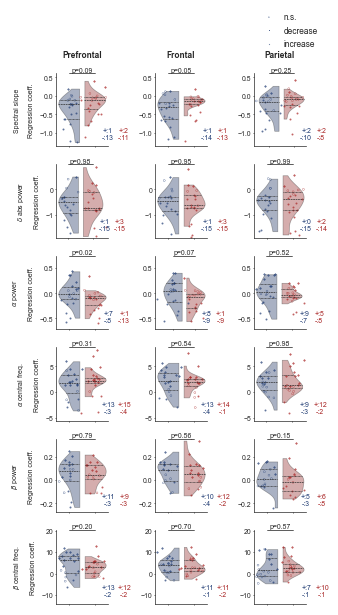

In [40]:
def remove_outliers(data, method='iqr', threshold=1.5):
    """
    Remove outliers from a list of data using the specified method.
    Supports 'iqr' (Interquartile Range) or 'std' (Standard Deviation).
    """
    # remove Nans before turning to numpy array
    valid_data = []
    for i in range(len(data)):
        if ~np.isnan(data[i]):
            valid_data.append(data[i])
    
    data = np.array(valid_data)
    if method == 'iqr':
        # IQR method
        q1, q3 = np.nanpercentile(data, [25, 75])
        iqr = q3 - q1
        lower_bound = q1 - threshold * iqr
        upper_bound = q3 + threshold * iqr
    elif method == 'std':
        # Standard Deviation method
        mean = np.nanmean(data)
        std_dev = np.nanstd(data)
        lower_bound = mean - threshold * std_dev
        upper_bound = mean + threshold * std_dev
    else:
        raise ValueError("Invalid method. Choose 'iqr' or 'std'.")
    
    # Filter data
    return data[(data >= lower_bound) & (data <= upper_bound)]


slope_value = 'normal_time_val' # Choose between 'val' and 'normal_time_val'

ncols = len(region_names)
nrows = int(np.ceil(len(region_names) / ncols)) * (len(spectral_prop_labels) + 1)
plot_width = 80 * ncols
plot_height = 80 * nrows

# Scatters
markersize=2
jitter_strength = 0.2

# P-value of linear regresssion
alpha = 0.05

set_custom_style() 

fig, axs = plt.subplots(
    nrows=nrows, 
    ncols=ncols, 
    figsize=(plot_width / 72, plot_height / 72), 
)
axs = axs.flatten()  # Flatten the axes for easier indexing

row_y_limits = {}
p_ranksum = np.full((len(region_names), len(spectral_prop_labels)), np.nan)
num_positive_A = np.full((len(region_names), len(spectral_prop_labels)), np.nan)
num_negative_A = np.full((len(region_names), len(spectral_prop_labels)), np.nan)
num_positive_B = np.full((len(region_names), len(spectral_prop_labels)), np.nan)
num_negative_B = np.full((len(region_names), len(spectral_prop_labels)), np.nan)
chi2 = np.full((len(region_names), len(spectral_prop_labels)), np.nan)
p_chi2 = np.full((len(region_names), len(spectral_prop_labels)), np.nan)

for region_idx, region in enumerate(region_names):
    for sp_idx, spectral_prop_name in enumerate(spectral_prop_labels):
        col = region_idx % ncols
        row = (region_idx // ncols) * (len(spectral_prop_labels) + 1) + sp_idx 
        curr_ax = axs[row * ncols + col]  

        win_center_emergence = win_center_emergence_all_regions_no_normalization[spectral_prop_name][region]
        spectral_prop_time_course_emergence = spectral_prop_time_course_emergence_all_regions_no_normalization[spectral_prop_name][region]

        slopes = {p: all_slopes[p][region][spectral_prop_name] for p in win_center_emergence}

        # Split slopes into groups
        slopes_A = {p: slope_info for p, slope_info in slopes.items() if group_label[p] == 'A'}
        slopes_B = {p: slope_info for p, slope_info in slopes.items() if group_label[p] == 'B'}

        # Combine data
        combined_slopes = []
        colors = []
        slopes_A_clean = remove_outliers([info[slope_value] for info in slopes_A.values()])
        slopes_B_clean = remove_outliers([info[slope_value] for info in slopes_B.values()])
        # slopes_A_clean = [info[slope_value] for info in slopes_A.values()]
        # slopes_B_clean = [info[slope_value] for info in slopes_B.values()]
        combined_slopes.append(slopes_A_clean)
        combined_slopes.append(slopes_B_clean)
        colors.extend([BLUE, RED])

        # Plot slope data
        sns.violinplot(data=combined_slopes, ax=curr_ax, cut=0, inner='quart', density_norm='area', palette=colors, linewidth=0.5, alpha=0.4, split=True)
        
        # Initialize flags for legend labels
        legend_flags = {'increase': False, 'decrease': False, 'n.s.': False}

        # Add strip plot with different markers for significance
        for group_idx, (color, group) in enumerate(zip([BLUE, RED], [slopes_A, slopes_B])):
            for p_idx, (p, slope_info) in enumerate(group.items()):
                if np.isnan(slope_info[slope_value]):
                    continue
                jittered_x = group_idx + np.random.normal(0, jitter_strength)
                if slope_info['p_value'] < alpha:
                    if slope_info[slope_value] > 0:
                        label = 'increase' if not legend_flags['increase'] else None
                        curr_ax.scatter(
                            jittered_x, slope_info[slope_value], color=color, marker='D', 
                            s=markersize, linewidths=0, alpha=0.7, label=label
                        )
                        legend_flags['increase'] = True  # Mark 'increase' as added
                    else:
                        label = 'decrease' if not legend_flags['decrease'] else None
                        curr_ax.scatter(
                            jittered_x, slope_info[slope_value], color=color, marker='o', 
                            s=markersize, linewidths=0, alpha=0.7, label=label
                        )
                        legend_flags['decrease'] = True  # Mark 'decrease' as added
                else:
                    label = 'n.s.' if not legend_flags['n.s.'] else None
                    curr_ax.scatter(
                        jittered_x, slope_info[slope_value], facecolors='none', edgecolors=color, 
                        marker='o', s=markersize, linewidths=0.2, label=label
                    )
                    legend_flags['n.s.'] = True  # Mark 'n.s.' as added

        # Extract legend handles and labels after the first group (if needed)
        if region_idx == 0 and sp_idx == 0:
            legend_markers, legend_labels = curr_ax.get_legend_handles_labels()

        # # Add strip plot with different markers for significance
        # for group_idx, (color, group) in enumerate(zip([BLUE, RED], [slopes_A, slopes_B])):
        #     for p_idx, (p, slope_info) in enumerate(group.items()):
        #         if np.isnan(slope_info[slope_value]):
        #             continue
        #         jittered_x = group_idx + np.random.normal(0, jitter_strength)
        #         if slope_info['p_value'] < alpha:
        #             if slope_info[slope_value] > 0:
        #                 curr_ax.scatter(jittered_x, slope_info[slope_value], color=color, marker='D', s=markersize, linewidths=0, alpha=0.7, label='increase')  # Diamond for significant positive
        #             else:
        #                 curr_ax.scatter(jittered_x, slope_info[slope_value], color=color, marker='o', s=markersize, linewidths=0, alpha=0.7, label='decrease')  # Solid dot for significant negative
        #         else:
        #             curr_ax.scatter(jittered_x, slope_info[slope_value], facecolors='none', edgecolors=color, marker='o', s=markersize, linewidths=0.2, label='n.s.')  # Hollow circle for non-significant

        #     if region_idx == 0 and sp_idx == 0 and group_idx == 0:
        #         legend_markers, legend_labels = curr_ax.get_legend_handles_labels()

        # Set y-limits to the global y-limits
        q1_A = np.nanpercentile(slopes_A_clean, 25)
        q3_A = np.nanpercentile(slopes_A_clean, 75)
        iqr_A = q3_A - q1_A 
        range_A = [q1_A-1.5*iqr_A, q3_A+1.5*iqr_A]

        q1_B = np.nanpercentile(slopes_B_clean, 25)
        q3_B = np.nanpercentile(slopes_B_clean, 75)
        iqr_B = q3_B - q1_B 
        range_B = [q1_B-1.5*iqr_B, q3_B+1.5*iqr_B]
        
        curr_ax.set_ylim([min(range_A[0], range_B[0]), max(range_A[1], range_B[1])])
        
        # Adjust y-axis to scientific notation
        curr_ax.ticklabel_format(style='scientific', axis='y', scilimits=(0, 0))

        if sp_idx == 0:
            curr_ax.set_title(f"{region.capitalize()}", loc='center', fontweight='bold', y=1.1)
        
        if region_idx == 0:
            curr_ax.set_ylabel(f'{spectral_prop_labels[spectral_prop_name]}\n\nRegression coeff.')

        curr_ax.set_xticklabels('')

        # Perform ranksum test and add significance line
        p_ranksum[region_idx][sp_idx] = ranksums(slopes_A_clean, slopes_B_clean).pvalue

        # Count significant positive and negative slopes
        num_positive_A[region_idx][sp_idx] = sum(1 for info in slopes_A.values() if info['p_value'] < alpha and info[slope_value] > 0)
        num_negative_A[region_idx][sp_idx] = sum(1 for info in slopes_A.values() if info['p_value'] < alpha and info[slope_value] < 0)
        num_positive_B[region_idx][sp_idx] = sum(1 for info in slopes_B.values() if info['p_value'] < alpha and info[slope_value] > 0)
        num_negative_B[region_idx][sp_idx] = sum(1 for info in slopes_B.values() if info['p_value'] < alpha and info[slope_value] < 0)
        
        # Create the contingency table for the chi-square test
        contingency_table = np.array([[num_negative_A[region_idx][sp_idx], len(slopes_A) - num_negative_A[region_idx][sp_idx]],
                                      [num_negative_B[region_idx][sp_idx], len(slopes_B) - num_negative_B[region_idx][sp_idx]]])
        
        # Perform the chi-square test
        chi2[region_idx][sp_idx], p_chi2[region_idx][sp_idx], _, _ = chi2_contingency(contingency_table)

        # Track the current y-limits
        curr_y_limits = curr_ax.get_ylim()
        if row not in row_y_limits:
            row_y_limits[row] = [curr_y_limits[0], curr_y_limits[1]]
        else:
            row_y_limits[row][0] = min(row_y_limits[row][0], curr_y_limits[0])
            row_y_limits[row][1] = max(row_y_limits[row][1], curr_y_limits[1])

    row = (region_idx // ncols) * (len(spectral_prop_labels) + 1) + len(spectral_prop_labels)  # Row index
    curr_ax = axs[row * ncols + col]  # Access the subplot
    curr_ax.remove()

# Apply the same y-limits to all axes in the same row
for region_idx, region in enumerate(region_names):
    for sp_idx, spectral_prop_name in enumerate(spectral_prop_labels):
        col = region_idx % ncols  # Column index
        row = (region_idx // ncols) * (len(spectral_prop_labels) + 1) + sp_idx   # Row index
        curr_ax = axs[row * ncols + col]  # Access the subplot

        # Set the y-limits to the global limits for this row
        curr_ax.set_ylim(row_y_limits[row])

        yl = curr_ax.get_ylim()
        significance_line_y = 1 * (yl[1] - yl[0]) + yl[0]
        curr_ax.plot([0, 1], [significance_line_y, significance_line_y], color='k', lw=0.5)
        curr_ax.text(0.5, significance_line_y * 1.05, f'p={p_ranksum[region_idx][sp_idx]:.2f}', ha='center', fontsize=5)

        curr_ax.text(1.5, 
                     .1 * (yl[1] - yl[0]) + yl[0], 
                     f'+:{int(num_positive_A[region_idx][sp_idx])}\n-:{int(num_negative_A[region_idx][sp_idx])}', 
                     ha='center', color=BLUE, fontsize=5)
        
        curr_ax.text(2.10, 
                     .1 * (yl[1] - yl[0]) + yl[0], 
                     f'+:{int(num_positive_B[region_idx][sp_idx])}\n-:{int(num_negative_B[region_idx][sp_idx])}', 
                     ha='center', color=RED, fontsize=5)
        
        # curr_ax.text(1.75, .02 * (yl[1] - yl[0]) + yl[0], f'Chi2 p={p_chi2[region_idx][sp_idx]:.2f}', ha='right', fontsize=4, color='gray')
        curr_ax.ticklabel_format(style='plain', axis='y')

ax_legend = fig.add_subplot([0.8, 0.83, 0.1, 0.05])
ax_legend.legend(legend_markers, legend_labels, loc='center', fontsize=6)
ax_legend.spines['bottom'].set_visible(False)
ax_legend.spines['left'].set_visible(False)
ax_legend.set_xticks([])
ax_legend.set_yticks([])
ax_legend.tick_params(bottom=False, left=False)
ax_legend.set_facecolor('none')


plt.tight_layout()
plt.subplots_adjust(left=0.15, right=0.9, bottom=0, top=0.8, wspace=.9, hspace=0.25)

main_dir = 'D:/Anesthesia_Research_Fellow/analysis_results'
filename = 'spectral_props_regression_slopes_groupA_vs_groupB'
# if NORMALIZE_AMP:
#     filename += '_normalized_to_pre_infusion'
filename += '_abs_delta_power_v2.pdf'
# filename += '_actual_delta_power.pdf'

file_path = os.path.join(main_dir, filename)
plt.savefig(file_path, format='pdf', dpi=300)

plt.show()

#### Parse the emergence epoch to various states

In [41]:
from scipy.ndimage import uniform_filter1d

def calculate_range(data):
    q1 = np.percentile(data, 25)  # 25th percentile
    q3 = np.percentile(data, 75)  # 75th percentile
    iqr = q3 - q1                 # Interquartile range
    lower_bound = q1 - 1.5 * iqr  # Lower bound
    upper_bound = q3 + 1.5 * iqr  # Upper bound
    return lower_bound, upper_bound

def schmitt_trigger_classification(data, hard_threshold, threshold_factor):
    """
    Apply Schmitt Trigger Classification on the data.
    
    Parameters:
    data (numpy.ndarray): Input data array.
    hard_threshold (float): Central threshold value.
    threshold_factor (float): Factor to adjust threshold based on standard deviation.
    
    Returns:
    numpy.ndarray: State classification array (0 or 1).
    """
    low_threshold = hard_threshold - threshold_factor * np.std(data)
    high_threshold = hard_threshold + threshold_factor * np.std(data)
    
    state = np.zeros_like(data, dtype=int)
    current_state = 1 if data[0] > hard_threshold else 0
    state[0] = current_state

    for i in range(1, len(data)):
        if current_state == 0 and data[i] > high_threshold:
            current_state = 1
        elif current_state == 1 and data[i] < low_threshold:
            current_state = 0
        state[i] = current_state

    return state

# another version of schmitt trigger classification where when the high threshold in crossed, it finds the last point where the high threshold was crossed and set the state to 1 from that point. The same for the low threshold.
def schmitt_trigger_classification_v2(data, hard_threshold, threshold_factor):
    """
    Apply Schmitt Trigger Classification on the data.
    
    Parameters:
    data (numpy.ndarray): Input data array.
    hard_threshold (float): Central threshold value.
    threshold_factor (float): Factor to adjust threshold based on standard deviation.
    
    Returns:
    numpy.ndarray: State classification array (0 or 1).
    """
    low_threshold = hard_threshold - threshold_factor * np.std(data)
    high_threshold = hard_threshold + threshold_factor * np.std(data)
    
    state = np.zeros_like(data, dtype=int)
    current_state = 1 if data[0] > hard_threshold else 0
    state[0] = current_state

    for i in range(1, len(data)):
        if current_state == 0 and data[i] > high_threshold:
            last_thresh_crossing = np.where(data[:i] > hard_threshold)[0]
            if len(last_thresh_crossing) > 0:
                last_thresh_crossing = last_thresh_crossing[-1]
                state[last_thresh_crossing:i] = 1
            current_state = 1
        elif current_state == 1 and data[i] < low_threshold:
            last_thresh_crossing = np.where(data[:i] < hard_threshold)[0]
            if len(last_thresh_crossing) > 0:
                last_thresh_crossing = last_thresh_crossing[-1]
                state[last_thresh_crossing:i] = 0
            current_state = 0
        state[i] = current_state

    return state

def classify_time_points(all_slopes, patient_data, alpha_threshold, smooth_window_size, preset_spectral_slope_threshold=0.6, threshold_factor=0.2, p_value_threshold=0.001, method='emergence'):
    """
    Classify time points based on spectral properties and their slope during the emergence.
    
    Parameters:
    all_slopes (dict): Dictionary containing slope information for different patients and regions.
    patient_data (dict): Dictionary containing the values of spectral proerties for all patients.
    alpha_threshold (float): Threshold for alpha spectral power.
    smooth_window_size (int): Window size for moving average filter.
    preset_spectral_slope_threshold (float, optional): Threshold for spectral slope classification. Default is 0.7.
    threshold_factor (float, optional): Factor to adjust threshold based on standard deviation. Default is 0.2.
    p_value_threshold (float, optional): p-value threshold for significance. Default is 0.001.
    method (String, optional): method for calculation of threshold

    Returns:
    dict: Classification results for each patient, region, and spectral property.
    """
    classification_results = {}

    for patient_id, regions_info in all_slopes.items():

        if patient_id == 'CA-01':
            print(patient_id)

        classification_results[patient_id] = {}

        for region, spectral_properties in regions_info.items():
            classification_results[patient_id][region] = {}

            win_center_emergence = spectral_prop[patient_id][region]['emergence']
            curr_spectral_slope_thresh = None

            for property_name, slope_info in spectral_properties.items():
                
                current_method = method

                storing_prop_name = None
                if 'slope' in property_name:
                    storing_prop_name = 'slope'
                elif 'alpha' in property_name and 'power' in property_name:
                    storing_prop_name = 'alpha'
                elif 'delta' in property_name and 'power' in property_name:
                    storing_prop_name = 'delta'
                else:
                    continue

                spectral_prop_emergence = patient_data[property_name][patient_id][region]['emergence']
                
                if 'alpha' in property_name:
                    spectral_prop_emergence[np.isnan(spectral_prop_emergence)] = 0
                    spectral_prop_emergence[spectral_prop_emergence < alpha_threshold] = 0
                
                spectral_prop_preop = patient_data[property_name][patient_id][region]['preop_rest']
                spectral_prop_pacu = patient_data[property_name][patient_id][region]['pacu_rest']

                # Determine pre_drug_infusion period data
                pre_drug_infusion_idx = win_center_emergence < 600
                spectral_prop_pre_drug_infusion = spectral_prop_emergence[pre_drug_infusion_idx]

                # Apply moving average filter
                spectral_prop_emergence = uniform_filter1d(spectral_prop_emergence, size=smooth_window_size)

                if 'slope' in property_name:
                    mean_pre_drug_infusion = np.nanmean(spectral_prop_pre_drug_infusion)

                    if (~np.isnan(spectral_prop_preop)) and (~np.isnan(spectral_prop_pacu)) and (~np.isnan(mean_pre_drug_infusion)):
                        min_rest = np.nanmin([spectral_prop_preop, spectral_prop_pacu])
                        threshold = (min_rest + mean_pre_drug_infusion)/2
                    else:
                        threshold = preset_spectral_slope_threshold

                    curr_spectral_slope_thresh = threshold
                        
                    state = schmitt_trigger_classification(spectral_prop_emergence, threshold, threshold_factor)
                    classification_results[patient_id][region][storing_prop_name] = state

                else: # For power in delta, alpha, beta, etc

                    if current_method == 'pre_drug_infusion':
                        mean_pre_drug_infusion = np.nanmean(spectral_prop_pre_drug_infusion)

                        if (~np.isnan(spectral_prop_preop)) and (~np.isnan(spectral_prop_pacu)) and (~np.isnan(mean_pre_drug_infusion)):
                            min_rest = np.nanmin([spectral_prop_preop, spectral_prop_pacu])
                            threshold = (min_rest + mean_pre_drug_infusion)/2

                            state = schmitt_trigger_classification(spectral_prop_emergence, threshold, threshold_factor)
                            classification_results[patient_id][region][storing_prop_name] = state
                        else:
                            current_method = 'emergence' # Fall back to emergence method if calculation fails

                    if current_method == 'emergence':
                        # if np.any([slope_info[f'div_{div}']['p_value']< p_value_threshold for div in range(5)]):  # Significant slope present
                        if slope_info['p_value'] < p_value_threshold:
                            # threshold = np.nanmedian(spectral_prop_emergence)
                            lower_bound, upper_bound = calculate_range(spectral_prop_emergence)
                            threshold = (lower_bound + upper_bound)/2

                            state = schmitt_trigger_classification(spectral_prop_emergence, threshold, threshold_factor)
                            classification_results[patient_id][region][storing_prop_name] = state
                        else:
                            if 'delta' in property_name:
                                matching_slope = patient_data['reg_fit_slope'][patient_id][region]['emergence']
                                median_spectral_slope = np.median(matching_slope)

                                if curr_spectral_slope_thresh is None:
                                    curr_spectral_slope_thresh = preset_spectral_slope_threshold
                                state = np.full_like(spectral_prop_emergence, 1 if median_spectral_slope > curr_spectral_slope_thresh else 0)
                                classification_results[patient_id][region][storing_prop_name] = state
                                continue

                            elif 'alpha' in property_name:
                                if np.all(spectral_prop_emergence > 0):
                                    state = np.ones_like(spectral_prop_emergence)
                                    classification_results[patient_id][region][storing_prop_name] = state
                                    continue
                                elif np.sum(spectral_prop_emergence > 0) > len(spectral_prop_emergence) / 4:
                                    threshold = alpha_threshold # np.nanmedian(spectral_prop_emergence)
                                    state = schmitt_trigger_classification(spectral_prop_emergence, threshold, threshold_factor=0)
                                    classification_results[patient_id][region][storing_prop_name] = state
                                    continue
                                else:
                                    state = np.zeros_like(spectral_prop_emergence)
                                    classification_results[patient_id][region][storing_prop_name] = state
                                    continue
                            else:
                                state = np.full_like(spectral_prop_emergence, -1)
                                classification_results[patient_id][region][storing_prop_name] = state
                                continue
                        
                    # state = schmitt_trigger_classification(spectral_prop_emergence, threshold, threshold_factor)
                    # classification_results[patient_id][region][storing_prop_name] = state
                        
    return classification_results

def classify_SWA_states(classification_results, patient_data, alpha_threshold=0.1, swa_detection_method='delta_high_alpha_present'):
    """
    Classify time points to different SWA states based on the states of individual spectral properties.

    Parameters:
    swa_detection_method (String): The method used for detecting the SWA states. It can be set to 'delta_high_alpha_present', 'delta_high_alpha_high', or 'spectral_slope'

    """
    SWA_classification = {}

    for patient_id , regions_info in classification_results.items():
        SWA_classification[patient_id] = {}

        # if patient_id == 'CA-21':
        #     print(patient_id)
        
        for region, spectral_states in regions_info.items():
            
            alpha_power_emergence = patient_data['fband_power_fooof_alpha'][patient_id][region]['emergence']

            SWA_classification[patient_id][region] = {}

            delta_state = spectral_states.get('delta', np.zeros_like(next(iter(spectral_states.values()))))
            alpha_state = spectral_states.get('alpha', np.zeros_like(next(iter(spectral_states.values()))))
            slope_state = spectral_states.get('slope', np.zeros_like(next(iter(spectral_states.values()))))

            combined_state = np.zeros_like(delta_state, dtype=int)

            if swa_detection_method == 'delta_high_alpha_high':
                for i in range(len(delta_state)):
                    if delta_state[i] == 1 and alpha_state[i] == 1:
                    # if delta_state[i] == 1 or alpha_state[i] == 1:
                        combined_state[i] = 1    # SWA
            elif swa_detection_method == 'delta_high_alpha_present':
                for i in range(len(delta_state)):
                    if delta_state[i] == 1 and alpha_power_emergence[i] > alpha_threshold:
                    # if delta_state[i] == 1 or alpha_power_emergence[i] > alpha_threshold:
                        combined_state[i] = 1    # SWA
            elif swa_detection_method == 'spectral_slope':
                for i in range(len(delta_state)):
                    if slope_state[i] == 1:
                        combined_state[i] = 1    # SWA

            # Identify ddSWA, sdSWA, weak_sdSWA, non_SWA state
            SWA_classification[patient_id][region]['ddSWA'] = np.zeros_like(delta_state, dtype=int)
            SWA_classification[patient_id][region]['sdSWA'] = np.zeros_like(delta_state, dtype=int)
            SWA_classification[patient_id][region]['weak_sdSWA'] = np.zeros_like(delta_state, dtype=int)
            SWA_classification[patient_id][region]['non_SWA'] = np.zeros_like(delta_state, dtype=int)
            ##
            # SWA_classification[patient_id][region]['uncertain'] = np.zeros_like(delta_state, dtype=int)
            ##

            for i in range(len(delta_state)):
                if combined_state[i] == 1:
                    if delta_state[i] == 1:
                        SWA_classification[patient_id][region]['ddSWA'][i] = 1
                    elif alpha_state[i] == 1: # and delta state is low
                        SWA_classification[patient_id][region]['sdSWA'][i] = 1

                # # consulting the spectral slope if only alpha or delta are in high state
                # if delta_state[i] == 0 or alpha_state[i] == 0:
                #     if slope_state[i] == 1:
                #         if delta_state[i] == 1:
                #             # pass
                #             SWA_classification[patient_id][region]['ddSWA'][i] = 1
                #         elif alpha_state[i] == 1:
                #             # pass
                #             SWA_classification[patient_id][region]['sdSWA'][i] = 1
                #         elif alpha_power_emergence[i] > alpha_threshold:
                #             SWA_classification[patient_id][region]['weak_sdSWA'][i] = 1

                # ### Recently modified 
                # if combined_state[i] == 0:
                #     SWA_classification[patient_id][region]['non_SWA'][i] = 1

                # # if (SWA_classification[patient_id][region]['ddSWA'][i] == 0) & (SWA_classification[patient_id][region]['sdSWA'][i] == 0) & (SWA_classification[patient_id][region]['weak_sdSWA'][i] == 0) & (SWA_classification[patient_id][region]['non_SWA'][i] == 0):
                # #     SWA_classification[patient_id][region]['uncertain'][i] = 1
                ###
                    
                if (SWA_classification[patient_id][region]['ddSWA'][i] == 0) & (SWA_classification[patient_id][region]['sdSWA'][i] == 0) & (SWA_classification[patient_id][region]['weak_sdSWA'][i] == 0):
                    SWA_classification[patient_id][region]['non_SWA'][i] = 1

    return SWA_classification

# Example usage
spectral_slope_threshold = 0.6
smooth_window_size = 5
threshold_factor = 0.5
p_value_threshold = 0.05
alpha_threshold = 0.1

state_classification_results = classify_time_points(
    all_slopes, 
    patients_pooled_data, 
    alpha_threshold, 
    smooth_window_size, 
    spectral_slope_threshold, 
    threshold_factor, 
    p_value_threshold,
    method = 'emergence'#
)

# Calculate the SWA - nonSWA states
# method = 'delta_high_alpha_high'
method = 'spectral_slope'

SWA_states = classify_SWA_states(
    state_classification_results, 
    patients_pooled_data, 
    alpha_threshold, 
    method)

CA-01


#### Plot the TFRs for each region and time courses of the corresponding spectral properties 

In [ ]:
import math
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.gridspec import GridSpec
from scipy.ndimage import gaussian_filter
from src.eeg_analysis.visualization.plots import plot_continuous_epochs

num_patients = 72
patients_per_page = num_patients // 2  # Half of the patients per page
cols = 5  # Number of columns per page
rows = math.ceil((patients_per_page * 4) / cols)  # Double the rows since each patient has two axes


main_dir = 'D:/Anesthesia_Research_Fellow/analysis_results'
filename = 'spectral_state_trajectories_individual_patients_spectral_slope_wide_wide_spectral_power.pdf'
output_pdf_path = os.path.join(main_dir, filename)


# Define a color map for the frequency bands
fbands = ['delta', 'theta', 'alpha', 'beta', 'gamma']
greek_band_names = {
    'delta': r'$\delta$',
    'theta': r'$\theta$',
    'alpha': r'$\alpha$',
    'beta': r'$\beta$',
    'gamma': r'$\gamma$'
}

BLUE = "#1f3b73"  # Dark Blue
RED = "#a82323"  # Dark Red


# Create a sequential colormap, 'viridis' for example, excluding the broadband
sequential_cmap = plt.cm.YlOrRd(np.linspace(0.35, 1, len(fbands) - 1))
color_map = {band: sequential_cmap[i] for i, band in enumerate(fbands[:-1])}


# Open a PDF for saving
with PdfPages(output_pdf_path) as pdf:
    for group, group_name in zip([groups['A'], groups['B']], ["Group A", "Group B"]):

        set_custom_style() 

        fig = plt.figure(figsize=(8.27, 11.69))
        gs = GridSpec(rows, cols, figure=fig, hspace=0.2, wspace=0.05)
        
        patient_local_idx = 0
        for p_name in group:
            
            base_results_dir = Path(f'E:/Caffeine_data/{p_name}/analysis_results_v2')
            filename = base_results_dir / f'{p_name}_power_spectral.pkl'

            if not filename.exists():
                # warnings.warn(f"Warning: The file at {filename} was not found.", UserWarning)
                continue

            # Load data
            loaded_power_spectral = joblib.load(filename)
            region = "prefrontal"
            epoch = "emergence"

            # Extract data
            region_avg_tfr = loaded_power_spectral.region_average_tfr[region][epoch] # whitened_tfr

            # Apply a 2D Gaussian filter
            sigma = 1  # Standard deviation for the Gaussian kernel
            region_avg_tfr.data = gaussian_filter(region_avg_tfr.data, sigma=sigma)

            # Normalization to pre_drug_infusion
            # pre_drug_infusion_mask = region_avg_tfr.times < 600
            # pre_drug_infusion_data = region_avg_tfr.data[:, pre_drug_infusion_mask]
            # region_avg_tfr.data = region_avg_tfr.data/pre_drug_infusion_data.mean(axis=1, keepdims=True)

            window_centers = loaded_power_spectral.window_average_tfr[region][epoch].times

            # TFR Plot
            col_idx = patient_local_idx % cols
            row_idx = (patient_local_idx // cols)*4
            ax_tfr = fig.add_subplot(gs[row_idx, col_idx])
            im = plot_continuous_epochs(
                region_avg_tfr, ax=ax_tfr, vmin=0, vmax=50, cmap="jet", title=f"{p_name} TFR"
            ) # vmin=-10, vmax=20
            if col_idx == 0:
                ax_tfr.set_ylabel("Freq (Hz)", fontsize=5)
            ax_tfr.set_title(p_name, pad = 0.5, fontsize=6, fontweight='bold', loc='left')
            ax_tfr.set_xticks(range(0, int(region_avg_tfr.times[-1]), 1000))
            ax_tfr.set_xticklabels([])
            ax_tfr.set_ylim([0, 35])
            ax_tfr.set_yticks(np.arange(0, 35, 10))
            # ax_tfr.set_yticks(np.arange(0, region_avg_tfr.frequencies[-1], 10))
            if col_idx != 0:
                ax_tfr.set_yticklabels('')

            ax_tfr.tick_params(axis='both', which='major', labelsize=5, length=2, width=0.5, pad=0.5)

            for spine in ax_tfr.spines.values():
                spine.set_linewidth(0.5)

            ax_tfr.grid(False)
        
            # Time Series Plot
            ax_spec_prop_time_courses = fig.add_subplot(gs[row_idx + 1, col_idx], sharex=ax_tfr)

            for fband in ["delta", "alpha", "beta"]:
                if fband == 'delta':
                    parameter_data = fband_power_abs[fband][p_name][region][epoch]
                else:
                    parameter_data = fband_power_fooof[fband][p_name][region][epoch] # fband_power_reg
                    
                # feature = "avg_power_relative" if fband == "delta" else "amplitude"
                # parameter_data = loaded_power_spectral.fooof_periodic_parameters[region][epoch][fband][feature][0]
                parameter_data = (parameter_data - np.nanmean(parameter_data)) / np.nanstd(parameter_data)

                if not np.all(np.isnan(parameter_data)):
                    ax_spec_prop_time_courses.plot(window_centers, np.ma.masked_invalid(parameter_data), linewidth=0.5, color=color_map[fband], 
                                 marker='none', label=greek_band_names[fband], markersize=.5) #epoch_colors[epoch_idx]
            
            spectral_slope = reg_fit_slope[p_name][region][epoch]
            spectral_slope = (spectral_slope - np.nanmean(spectral_slope)) / np.nanstd(spectral_slope)
            if not np.all(np.isnan(spectral_slope)):
                ax_spec_prop_time_courses.plot(window_centers, np.ma.masked_invalid(spectral_slope), linewidth=0.5, color='magenta', 
                             marker='none', label='slope', markersize=.5)
            
            if col_idx == 0: 
                ax_spec_prop_time_courses.set_ylabel("Power (norm)", fontsize=5)
            # ax_spec_prop_time_courses.set_xlabel("Time (s)", fontsize=5, labelpad=0.5)
            ax_spec_prop_time_courses.tick_params(axis="both", which="major", labelsize=5, length=2, width=0.5, pad=0.5)
            # ax_spec_prop_time_courses.legend(fontsize=4, loc='lower left')
            ax_spec_prop_time_courses.set_xlim(ax_tfr.get_xlim())
            ax_spec_prop_time_courses.set_xticks(range(0, int(region_avg_tfr.times[-1]), 1000))
            ax_spec_prop_time_courses.set_xticklabels([])
            
            ax_spec_prop_time_courses.set_yticks([-2.5, 0, 2.5])
            if col_idx!=0:
                ax_spec_prop_time_courses.set_yticklabels('')

            ax_spec_prop_time_courses.set_ylim([-2.6, 2.6])

            for spine in ax_spec_prop_time_courses.spines.values():
                spine.set_linewidth(0.5)

            ax_spec_prop_time_courses.grid(False)


            ## Creating and adding the binary heatmap (stacked barcode style)
            ax_swrstates = fig.add_subplot(gs[row_idx + 2, col_idx], sharex=ax_tfr)

            state_names = ['ddSWA', 'sdSWA', 'weak_sdSWA', 'non_SWA']
            # state_names = ['ddSWA', 'sdSWA', 'non_SWA']
            stacked_state_arrays = np.vstack([SWA_states[p_name][region][state_name] for state_name in state_names])

            ## Considering the weak_sdSWA as non_SWA
            last_two_sum = np.sum(stacked_state_arrays[-2:], axis=0)
            stacked_state_arrays = np.vstack((stacked_state_arrays[:-2], last_two_sum))
            combined_state_names = ['ddSWA', 'sdSWA', 'nSWA']

            extent = [window_centers[0], window_centers[-1], 0, stacked_state_arrays.shape[0]]

            ax_swrstates.imshow(stacked_state_arrays, aspect='auto', cmap='binary', interpolation='none', origin='upper', extent=extent)

            ax_swrstates.set_yticks(np.arange(stacked_state_arrays.shape[0])+0.5)
            if col_idx == 0:
                ax_swrstates.set_yticklabels(combined_state_names[::-1], fontsize=3.5)    
                # ax_swrstates.set_yticklabels(state_names[::-1], fontsize=3.5)
            else:
                ax_swrstates.set_yticklabels('')

            ax_swrstates.tick_params(axis='both', which='major', labelsize=5, length=2, width=0.5, pad=0.5)
            ax_swrstates.set_xticks(range(0, int(region_avg_tfr.times[-1]), 1000))
            ax_swrstates.set_xlabel("Time (s)", fontsize=5 , labelpad=0.5)

            if patient_local_idx == 0:
                ax_legend = fig.add_subplot([0.7, 0.92, 0.1, 0.05])
                legend_lines, legend_labels = ax_spec_prop_time_courses.get_legend_handles_labels()
                ax_legend.legend(legend_lines, legend_labels, loc='center', fontsize=6)
                ax_legend.axis('off')
                # ax_legend.spines['bottom'].set_visible(False)
                # ax_legend.spines['left'].set_visible(False)
                # ax_legend.set_xticks([])
                # ax_legend.set_yticks([])
                ax_legend.tick_params(bottom=False, left=False)
                ax_legend.set_facecolor('none')

                # Add colorbar
                cax = fig.add_subplot([0.5, 0.95, 0.1, 0.01])
                cbar = plt.colorbar(im, cax=cax, orientation='horizontal')
                cbar.set_label('Power(normalized)', fontsize=4, loc='center')
                cbar.outline.set_visible(False)
                
                cbar.ax.tick_params(labelsize=5)

            ax_swrstates.grid(False)
            patient_local_idx += 1


        ## adding the group name
        ax_suptitle = fig.add_subplot([0.15, 0.95, 0.1, 0.05])
        ax_suptitle.text(0, 0, group_name, fontsize= 12, color=BLUE if group_name == "Group A" else RED)
        ax_suptitle.axis('off')

            # for region in region_names:
            #     for epoch in epoch_names:
            #         region_avg_tfr = loaded_power_spectral.region_average_tfr[region][epoch]
            #         region_avg_tfr_whitened = loaded_power_spectral.whitened_tfr[region][epoch]

        plt.subplots_adjust(left=0.1, right= 0.95, bottom=0.01, top=0.9)

        # Save page to PDF
        pdf.savefig(fig, dpi=300)
        plt.close(fig)

print(f"PDF saved at: {output_pdf_path}")

#### Another version of the above code, with a difference that each spectral property time series is plotted in a difference panel

In [ ]:
import math
import os
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.gridspec import GridSpec
from scipy.ndimage import gaussian_filter
import joblib
import numpy as np
from src.eeg_analysis.visualization.plots import plot_continuous_epochs

# Constants

spectral_prop_labels = {
    'reg_fit_slope': 'Spectral slope',
    'fband_power_abs_delta': r'$\delta$ abs power',
    'fband_power_fooof_alpha': r'$\alpha$ power',
    'fband_central_freq_alpha': r'$\alpha$ central freq.',
    'fband_power_fooof_beta': r'$\beta$ power',
    'fband_central_freq_beta': r'$\beta$ central freq.'
}
yranges = {
    'reg_fit_slope': [-0.1, 1.25],
    'fband_power_abs_delta': [-0.1, 6],
    'fband_power_fooof_alpha': [-0.1, 1],
    'fband_central_freq_alpha': [6, 21],
    'fband_power_fooof_beta': [0, 0.5],
    'fband_central_freq_beta': [18, 35]
}

num_patients = 50
patients_per_page = num_patients // 2
cols = 5
panels_per_patient = len(spectral_prop_labels) + 3
rows = math.ceil((patients_per_page * panels_per_patient) / cols) 
height_ratios = ([1]+ [.4]*len(spectral_prop_labels)+[.4]+[.2])*int(rows/panels_per_patient)

main_dir = 'D:/Anesthesia_Research_Fellow/analysis_results'
filename = 'spectral_state_trajectories_individual_patients_separated_v2.pdf'
output_pdf_path = os.path.join(main_dir, filename)

# Define color maps

BLUE = "#1f3b73"
RED = "#a82323"
sequential_cmap = plt.cm.YlOrRd(np.linspace(0.35, 1, len(spectral_prop_labels)))
color_map = {band: sequential_cmap[i] for i, band in enumerate(spectral_prop_labels.keys())}

combined_state_names = ['ddSWA', 'sdSWA', 'nSWA']

# Open PDF
with PdfPages(output_pdf_path) as pdf:
    for group, group_name in zip([groups['A'], groups['B']], ["Group A", "Group B"]):

        set_custom_style()

        fig = plt.figure(figsize=(8.27, 11.69))
        gs = GridSpec(rows, cols, figure=fig, hspace=0.5, wspace=0.25, height_ratios=height_ratios)
        patient_local_idx = 0

        for p_name in group:

            base_results_dir = Path(f'E:/Caffeine_data/{p_name}/analysis_results_v2')
            filename = base_results_dir / f'{p_name}_power_spectral.pkl'

            if not filename.exists():
                continue

            loaded_power_spectral = joblib.load(filename)
            region = "prefrontal"
            epoch = "emergence"

            region_avg_tfr = loaded_power_spectral.region_average_tfr[region][epoch]
            sigma = 1
            region_avg_tfr.data = gaussian_filter(region_avg_tfr.data, sigma=sigma)

            window_centers = loaded_power_spectral.window_average_tfr[region][epoch].times

            col_idx = patient_local_idx % cols
            base_row_idx = (patient_local_idx // cols) * panels_per_patient

            # TFR Plot
            ax_tfr = fig.add_subplot(gs[base_row_idx, col_idx])
            im = plot_continuous_epochs(
                region_avg_tfr, ax=ax_tfr, vmin=0, vmax=50, cmap="jet", title=f"{p_name} TFR"
            )
            if col_idx == 0:
                ax_tfr.set_ylabel("Freq (Hz)", fontsize=5)
            ax_tfr.set_title(p_name, pad = 0.5, fontsize=6, fontweight='bold', loc='left')
            ax_tfr.set_xticks(range(0, int(region_avg_tfr.times[-1]), 1000))
            ax_tfr.set_xticklabels([])
            ax_tfr.set_ylim([0, 35])
            ax_tfr.set_yticks(np.arange(0, 35, 10))
            # ax_tfr.set_yticks(np.arange(0, region_avg_tfr.frequencies[-1], 10))
            if col_idx != 0:
                ax_tfr.set_yticklabels('')

            ax_tfr.tick_params(axis='both', which='major', labelsize=5, length=2, width=0.5, pad=0.5)

            for spine in ax_tfr.spines.values():
                spine.set_linewidth(0.5)

            ax_tfr.grid(False)
            
            # Time-Series Plots for Each Feature
            for i, (spectral_prop_name, ylabel) in enumerate(spectral_prop_labels.items()):
                spectral_prop = patients_pooled_data[spectral_prop_name]
                ax_feature = fig.add_subplot(gs[base_row_idx+1+i, col_idx], sharex=ax_tfr)
                if not np.all(np.isnan(spectral_prop[p_name][region]['emergence'])):
                    ax_feature.plot(window_centers, spectral_prop[p_name][region]['emergence'], linewidth=0.5,
                                    color='k') # color_map[spectral_prop_name]

                ax_feature.tick_params(axis="both", which="major", labelsize=4, length=2, width=0.5, pad=0.5)
                if col_idx == 0:
                    ax_feature.set_ylabel(ylabel, fontsize=4.5, rotation=0, ha='right', va='top', labelpad=2)
                ax_feature.set_xticks([])
                ax_feature.set_xticks(range(0, int(region_avg_tfr.times[-1]), 1000))
                ax_feature.set_xticklabels([])
                # ax_feature.set_ylim([0, ax_feature.get_ylim()[1]])

                # ax_feature.set_ylim(yranges[spectral_prop_name])
                # if col_idx != 0:
                #     ax_feature.set_yticklabels('')
                
                ax_feature.grid(True, axis='y', linestyle='-', linewidth=0.3)

                # Add the state classification results as second y-axis with a different range
                fband_name = spectral_prop_name.split('_')[-1]
                if fband_name in state_classification_results[p_name][region] and 'freq' not in spectral_prop_name:
                    ax_feature_sec = ax_feature.twinx() 
                    state = state_classification_results[p_name][region][fband_name]
                    ax_feature_sec.plot(window_centers, state, linewidth=0.5, linestyle='--', color='magenta')
                    ax_feature_sec.set_yticks([0, 1])
                    ax_feature_sec.set_yticklabels(['l', 'h'], fontsize=3)
                    ax_feature_sec.set_ylim([-0.1, 1.1])
                    ax_feature_sec.spines["right"].set_visible(True)  # Ensure the right spine is visible
                    ax_feature_sec.spines["left"].set_visible(False)  # Hide the left spine of the secondary axis

            # State Trajectory Plot
            ax_states = fig.add_subplot(gs[base_row_idx + panels_per_patient-2, col_idx], sharex=ax_tfr)
            stacked_state_arrays = np.vstack([
                SWA_states[p_name][region][state_name] for state_name in ['ddSWA', 'sdSWA', 'weak_sdSWA', 'non_SWA']
            ])
            last_two_sum = np.sum(stacked_state_arrays[-2:], axis=0)
            stacked_state_arrays = np.vstack((stacked_state_arrays[:-2], last_two_sum))


            extent = [window_centers[0], window_centers[-1], 0, stacked_state_arrays.shape[0]]
            ax_states.imshow(stacked_state_arrays, aspect='auto', cmap='binary', interpolation='none', origin='upper', extent=extent)
            ax_states.tick_params(axis="both", which="major", labelsize=5, length=2, width=0.5, pad=0.5)
            # if col_idx == 0:
            #     ax_states.set_ylabel("States", fontsize=5)
            
            ax_states.set_yticks(np.arange(stacked_state_arrays.shape[0])+0.5)
            if col_idx == 0:
                ax_states.set_yticklabels(combined_state_names[::-1], fontsize=3.5)    
                # ax_states.set_yticklabels(state_names[::-1], fontsize=3.5)
            else:
                ax_states.set_yticklabels('')

            ax_states.tick_params(axis='both', which='major', length=2, width=0.5, pad=0.5)
            ax_states.set_xticks(range(0, int(region_avg_tfr.times[-1]), 1000))
            ax_states.set_xlabel("Time (s)", fontsize=5 , labelpad=0.5)

            patient_local_idx += 1

        pdf.savefig(fig, dpi=300)
        plt.close(fig)

print(f"PDF saved at: {output_pdf_path}")

#### Dwell Time of SWR States When Active as the Last State

In [15]:
BLUE = "#1f3b73"  # Dark Blue
RED = "#a82323"  # Dark Red

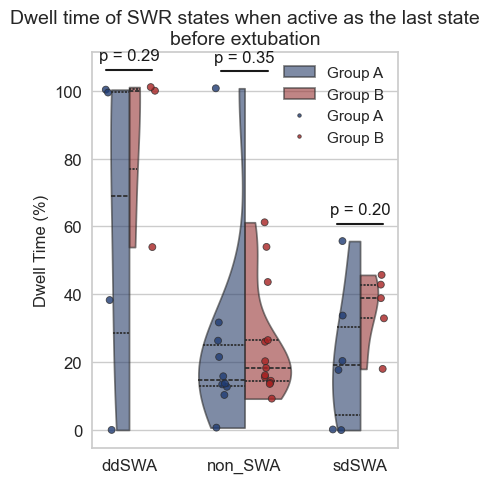

In [54]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

# Predefined variables
# ... (other necessary variables like groups, SWA_states, etc.)

# Helper function to eliminate states that last less than min_state_duration
# def eliminate_short_dwellings(state_array, min_state_duration):
#     cleaned_state_array = np.zeros_like(state_array)
#     current_state = state_array[0]
#     count = 0

#     for i in range(len(state_array)):
#         if state_array[i] == 1:
#             count += 1
#         else:
#             if count >= min_state_duration:
#                 cleaned_state_array[i - count:i] = current_state
#             current_state = state_array[i]
#             count = 1

#     # Final check for the last segment
#     if count >= min_state_duration:
#         cleaned_state_array[len(state_array) - count:] = current_state

#     return cleaned_state_array

def eliminate_short_dwellings(state_array, min_state_duration):
    """
    Replace contiguous stretches of ones that are shorter than min_state_duration with np.nan.
    
    Parameters:
        state_array (np.array): A one-dimensional array containing ones and zeros.
        min_state_duration (int): The minimum number of contiguous ones required to be kept.
        
    Returns:
        np.array: The updated array with short stretches of ones replaced with np.nan.
    """
    # Ensure the array is a float array so that np.nan can be assigned.
    state_array = state_array.astype(float)
    n = len(state_array)
    i = 0

    while i < n:
        if state_array[i] == 1:
            # Mark the start of a contiguous segment of ones.
            start = i
            # Advance through the contiguous ones.
            while i < n and state_array[i] == 1:
                i += 1
            duration = i - start  # Length of the current block of ones.
            if duration < min_state_duration:
                state_array[start:i] = np.nan
        else:
            i += 1

    return state_array

# Calculate dwell times as a percentage of the total time
def calculate_dwell_times(groups, SWA_states, min_state_duration=5):
    dwell_times = {"Group A": defaultdict(list), "Group B": defaultdict(list)}

    for group, group_name in zip([groups['A'], groups['B']], ["Group A", "Group B"]):
        for patient_id in group:
            if patient_id in SWA_states:
                for region in ['prefrontal']:  # You can modify this to include other regions if needed.
                    if region in SWA_states[patient_id]:
                        state_sequences = {state_name: SWA_states[patient_id][region][state_name].copy() for state_name in ['ddSWA', 'sdSWA', 'non_SWA']}
                        
                        # Combine weak_sdSWA with non_SWA
                        if 'weak_sdSWA' in SWA_states[patient_id][region]:
                            state_sequences['non_SWA'] += SWA_states[patient_id][region]['weak_sdSWA']
                        
                        # Eliminate short dwellings
                        for state_name in state_sequences:
                            state_sequences[state_name] = eliminate_short_dwellings(state_sequences[state_name], min_state_duration)

                        # Calculate dwell times as a percentage of total time
                        total_time = len(next(iter(state_sequences.values())))

                        # for state_name, state_sequence in state_sequences.items():
                        #     if state_sequence[-1] == 1: # only if it is the last state
                        #         dwell_time = np.sum(state_sequence) / total_time * 100
                        #         dwell_times[group_name][state_name].append(dwell_time)
                        #     # else:
                        #     #     dwell_times[group_name][state_name].append(0)

                        
                        # Detect the state with the last occurrence of ones.
                        last_occurrences = {}
                        for state_name, state_sequence in state_sequences.items():
                            # Find indices where the state is 1. (Ignore np.nan and zeros.)
                            indices = np.where(state_sequence == 1)[0]
                            if indices.size > 0:
                                last_occurrences[state_name] = indices[-1]

                        if last_occurrences:
                            # Get the state with the maximum (latest) occurrence index.
                            last_state = max(last_occurrences, key=last_occurrences.get)
                            
                            # Extract the sequence for the last state.
                            state_seq = state_sequences[last_state]
                            
                            # Determine the length of the last stretch of ones.
                            last_stretch_length = 0
                            # Iterate backwards from the end of the sequence.
                            for i in range(total_time - 1, -1, -1):
                                if state_seq[i] == 1:
                                    last_stretch_length += 1
                                else:
                                    break

                            # Calculate dwell time as the percentage of time occupied by the last stretch of ones.
                            dwell_time = (last_stretch_length / total_time) * 100
                            dwell_times[group_name][last_state].append(dwell_time)
        
    return dwell_times

# Function to set custom style (define styles separately if needed)
def set_custom_style_2():
    sns.set(style="whitegrid")
    plt.rcParams['axes.labelsize'] = 12
    plt.rcParams['axes.titlesize'] = 14
    plt.rcParams['xtick.labelsize'] = 12
    plt.rcParams['ytick.labelsize'] = 12

# Calculate dwell times
dwell_times = calculate_dwell_times(groups, SWA_states, min_state_duration=5)

# Calculate the percentage of patients in each group ending in each state.
end_state_frequencies = {"Group A": {}, "Group B": {}}

# Loop over groups in dwell_times.
for group_name, group_states in dwell_times.items():
    # Total number of patients in the group that have an ending state.
    total_patients = sum(len(times) for times in group_states.values())
    
    # Calculate the percentage for each state.
    for state in ['ddSWA', 'sdSWA', 'non_SWA']:
        state_count = len(group_states[state]) if state in group_states else 0
        percentage = (state_count / total_patients * 100) if total_patients > 0 else 0
        end_state_frequencies[group_name][state] = percentage

# Add jitter to dwell times
jitter_strength = 0.5  # Adjust the jitter strength as needed
for group_name in dwell_times:
    for state_name in dwell_times[group_name]:
        dwell_times[group_name][state_name] = [dwell_time + np.random.normal(0, jitter_strength) for dwell_time in dwell_times[group_name][state_name]]

# Prepare data for plotting
plot_data = []
for group_name in dwell_times:
    for state_name in dwell_times[group_name]:
        for dwell_time in dwell_times[group_name][state_name]:
            plot_data.append({
                "Group": group_name,
                "State": state_name,
                "Dwell Time (%)": dwell_time
            })

# Convert to DataFrame for seaborn plotting
df_plot = pd.DataFrame(plot_data)

# Plot violin plots
set_custom_style_2()
plt.figure(figsize=(4, 5))
sns.violinplot(x="State", y="Dwell Time (%)", hue="Group", data=df_plot, split=True, inner="quart", density_norm='count', cut=0, palette=[BLUE, RED], alpha=0.6)
sns.stripplot(x="State", y="Dwell Time (%)", hue="Group", data=df_plot, dodge=True, jitter=True, palette=[BLUE, RED], alpha=0.8, linewidth=0.6)

# Perform ranksum tests and annotate the plot
states = df_plot['State'].unique()
for state in states:
    group_a = df_plot[(df_plot['State'] == state) & (df_plot['Group'] == 'Group A')]['Dwell Time (%)']
    group_b = df_plot[(df_plot['State'] == state) & (df_plot['Group'] == 'Group B')]['Dwell Time (%)']

    if not group_a.empty and not group_b.empty:
        stat, p_value = ranksums(group_a, group_b)
        p_value_text = f"{p_value:.1e}" if p_value < 0.01 else f"{p_value:.2f}"

        # Calculate the position for the annotation
        y, h, col = max(group_a.max(), group_b.max()) + 5, 2, 'k'
        plt.plot([states.tolist().index(state) - 0.2, states.tolist().index(state) + 0.2], [y, y], lw=1.5, c=col)
        plt.text(states.tolist().index(state), y + h, f"p = {p_value_text}", ha='center', va='bottom', color=col)

plt.title("Dwell time of SWR states when active as the last state\nbefore extubation")
plt.xlabel("")
plt.ylabel("Dwell Time (%)")
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

##### Calculate the likeliest end state for each patient group 

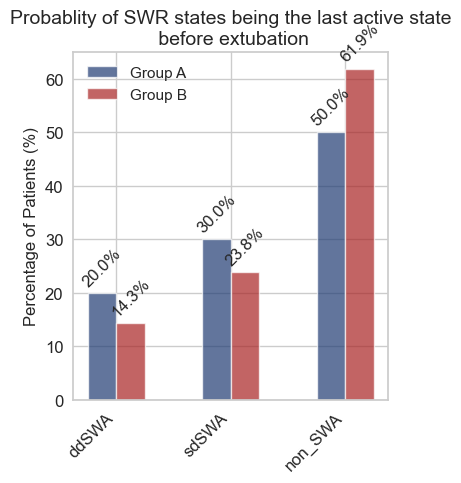

In [55]:
# from collections import Counter

# # Calculate end state frequencies for each patient group
# def calculate_end_state_frequencies(groups, SWA_states, num_end_windows=5):
#     end_state_frequencies = {"Group A": Counter(), "Group B": Counter()}

#     for group, group_name in zip([groups['A'], groups['B']], ["Group A", "Group B"]):
#         for patient_id in group:
#             if patient_id in SWA_states:
#                 for region in ['prefrontal']:# SWA_states[patient_id]

#                     # # Initialize a Counter for the last few time window states
#                     # state_names = ['ddSWA', 'sdSWA', 'weak_sdSWA', 'non_SWA']
#                     # stacked_state_arrays = np.vstack([SWA_states[patient_id][region][state_name] for state_name in state_names])

#                     # ## Considering the weak_sdSWA as non_SWA
#                     # last_two_sum = np.sum(stacked_state_arrays[-2:], axis=0)
#                     # stacked_state_arrays = np.vstack((stacked_state_arrays[:-2], last_two_sum))
#                     state_sequences = {state_name: SWA_states[patient_id][region][state_name].copy() for state_name in ['ddSWA', 'sdSWA', 'non_SWA']}
                        
#                     # Combine weak_sdSWA with non_SWA
#                     if 'weak_sdSWA' in SWA_states[patient_id][region]:
#                         state_sequences['non_SWA'] += SWA_states[patient_id][region]['weak_sdSWA']
                    
#                     # Eliminate short dwellings
#                     for state_name in state_sequences:
#                         state_sequences[state_name] = eliminate_short_dwellings(state_sequences[state_name], num_end_windows)

#                     if patient_id =='CA-05':
#                         aa = state_sequences

#                     end_state = None
#                     for state_idx, state_name in enumerate(["ddSWA", "sdSWA", "non_SWA"]):
#                         state_array = state_sequences[state_name] #stacked_state_arrays[state_idx]
#                         # Check if the state is sustained for at least min_end_windows at the end
#                         if np.all(state_array[-num_end_windows:] == 1):
#                             end_state = state_name
#                             break

#                     # Only consider the sustained end state
#                     if end_state:
#                         end_state_frequencies[group_name][end_state] += 1
#                     else:
#                         print(patient_id)
#                         end_state_frequencies[group_name]['uncertain'] += 1

#     return end_state_frequencies, aa

# end_state_frequencies, aa = calculate_end_state_frequencies(groups, SWA_states, num_end_windows=4)
# print("End state frequencies for Group A:", end_state_frequencies["Group A"])
# print("End state frequencies for Group B:", end_state_frequencies["Group B"])


# # Function to calculate percentage of patients for each end state
# def calculate_state_percentages(end_state_frequencies, groups):
#     state_percentages = {"Group A": {}, "Group B": {}}

#     for group_name in ["Group A", "Group B"]:
#         total_patients = len(groups[group_name[6].upper()])
#         for state, count in end_state_frequencies[group_name].items():
#             state_percentages[group_name][state] = (count / total_patients) * 100 if total_patients > 0 else 0

#     return state_percentages

# Plotting the bargraph
def plot_state_percentages(state_percentages):
    states = ['ddSWA', 'sdSWA', 'non_SWA'] 
    groups = ['Group A', 'Group B']
    bar_width = 0.25

    fig, ax = plt.subplots(figsize=(4, 5))
    index = np.arange(len(states))

    bar_group_a = [state_percentages['Group A'].get(state, 0) for state in states]
    bar_group_b = [state_percentages['Group B'].get(state, 0) for state in states]

    bars1 = ax.bar(index, bar_group_a, bar_width, label='Group A', color=BLUE, alpha=0.7)
    bars2 = ax.bar(index + bar_width, bar_group_b, bar_width, label='Group B', color=RED, alpha=0.7)

    ax.set_xlabel('')
    ax.set_ylabel('Percentage of Patients (%)')
    ax.set_title('Probablity of SWR states being the last active state\n before extubation')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(states, rotation=45, ha='right', va='top')
    ax.legend(loc='upper left')
    # ax.set_ylim([0, 50])

    def add_labels(bars):
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.1f}%',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom', rotation=45)

    add_labels(bars1)
    add_labels(bars2)

    plt.tight_layout()
    plt.show()


# # Calculate the state percentages
# state_percentages = calculate_state_percentages(end_state_frequencies, groups)

# Plot the state percentages
plot_state_percentages(end_state_frequencies)

In [18]:
end_state_frequencies

{'Group A': {'ddSWA': 15.0, 'sdSWA': 35.0, 'non_SWA': 50.0},
 'Group B': {'ddSWA': 23.809523809523807,
  'sdSWA': 42.857142857142854,
  'non_SWA': 33.33333333333333}}

#### Caclulate the freuency of state trajectory for each patient group

Trajectory frequencies for Group A: Counter({'T2': 6, 'T1': 5, 'T3': 3, 'T4': 2, 'uncertain': 2, 'T5': 1, 'T7': 1})
Trajectory frequencies for Group B: Counter({'T3': 8, 'T2': 5, 'T7': 3, 'T4': 2, 'T1': 2, 'uncertain': 1})


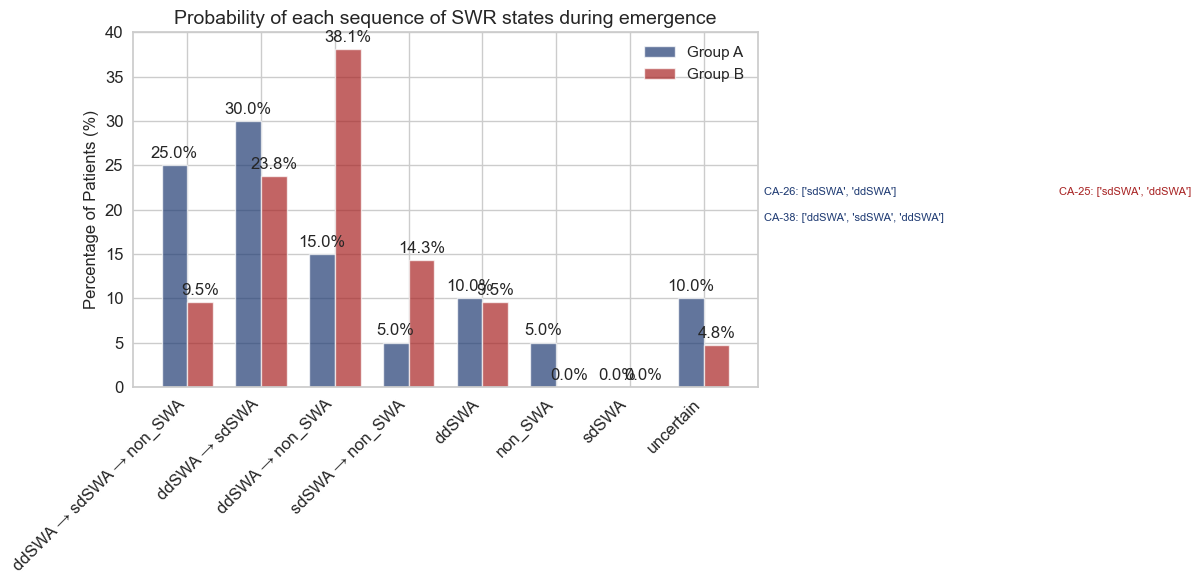

In [53]:
from collections import Counter

# Helper function to eliminate states that last less than min_state_duration
def eliminate_short_dwellings(state_array, min_state_duration):
    cleaned_state_array = np.zeros_like(state_array)
    current_state = state_array[0]
    count = 0

    for i in range(len(state_array)):
        if state_array[i] == current_state:
            count += 1
        else:
            if count >= min_state_duration:
                cleaned_state_array[i - count:i] = current_state
            current_state = state_array[i]
            count = 1

    # Final check for the last segment
    if count >= min_state_duration:
        cleaned_state_array[len(state_array) - count:] = current_state

    return cleaned_state_array

# Calculate trajectory frequencies for each patient group
uncertain_trajectory_sequences = {
    "Group A": {
        "prefrontal": {},
        "frontal": {},
        "parietal": {},
        "occipital": {},
        "temporal": {},
        "central": {}
    },
    "Group B": {
        "prefrontal": {},
        "frontal": {},
        "parietal": {},
        "occipital": {},
        "temporal": {},
        "central": {}
    }
}

def calculate_trajectory_frequencies(groups, SWA_states, trajectories, min_state_duration=5):
    trajectory_frequencies = {"Group A": Counter(), "Group B": Counter()}

    for group, group_name in zip([groups['A'], groups['B']], ["Group A", "Group B"]):
        for patient_id in group:
            if patient_id in SWA_states:
                # print(patient_id)
                for region in ['prefrontal']:  
                    state_sequences = {state_name: SWA_states[patient_id][region][state_name].copy() for state_name in ['ddSWA', 'sdSWA', 'non_SWA']} # , 'weak_sdSWA'
                    
                    ## Considering the weak_sdSWA as non_SWA

                    # state_sequences['non_SWA'] += state_sequences['weak_sdSWA']
                    # state_sequences.pop('weak_sdSWA', None)

                    # Eliminate short dwellings
                    for state_name in state_sequences:
                        state_sequences[state_name] = eliminate_short_dwellings(state_sequences[state_name], min_state_duration)
                    
                    # Calculate the state sequence
                    final_state_sequence = []
                    for t in range(len(next(iter(state_sequences.values())))):
                        active_states = [state for state in state_sequences if state_sequences[state][t] > 0]
                        if active_states:
                            final_state_sequence.append(active_states[0])

                    # Eliminate consecutive same states
                    final_state_sequence = [state for i, state in enumerate(final_state_sequence) if i == 0 or state != final_state_sequence[i-1]]
                    
                    # Look for the trajectories
                    seq_len = len(final_state_sequence)
                    
                    if seq_len == 1:
                        if final_state_sequence == trajectories['T4']:
                            trajectory_frequencies[group_name]['T4'] += 1
                        elif final_state_sequence == trajectories['T6']:
                            trajectory_frequencies[group_name]['T6'] += 1
                        elif final_state_sequence == trajectories['T5']:
                            trajectory_frequencies[group_name]['T5'] += 1

                    elif seq_len == 2:
                        if final_state_sequence == trajectories['T2']:
                            trajectory_frequencies[group_name]['T2'] += 1
                        elif final_state_sequence == trajectories['T3']:
                            trajectory_frequencies[group_name]['T3'] += 1
                        elif final_state_sequence == trajectories['T7']:
                            trajectory_frequencies[group_name]['T7'] += 1
                        else:
                            trajectory_frequencies[group_name]['uncertain'] += 1
                            uncertain_trajectory_sequences[group_name][region][patient_id] = final_state_sequence

                    elif seq_len >= 3:
                        # if trajectories['T1'] in [final_state_sequence[i:i+3] for i in range(len(final_state_sequence)-2)]:
                        if final_state_sequence[-3:] == trajectories['T1']:
                            trajectory_frequencies[group_name]['T1'] += 1
                        elif final_state_sequence[-2:] == trajectories['T2']:
                            trajectory_frequencies[group_name]['T2'] += 1
                        elif final_state_sequence[-2:] == trajectories['T3']:
                            trajectory_frequencies[group_name]['T3'] += 1
                        elif final_state_sequence[-2:] == trajectories['T7']:
                            trajectory_frequencies[group_name]['T7'] += 1
                        else:
                            trajectory_frequencies[group_name]['uncertain'] += 1
                            uncertain_trajectory_sequences[group_name][region][patient_id] = final_state_sequence
                        
    return trajectory_frequencies

state_names = ['ddSWA', 'sdSWA', 'non_SWA'] # , 'weak_sdSWA'
trajectories = {
        'T1': ['ddSWA', 'sdSWA', 'non_SWA'],
        'T2': ['ddSWA', 'sdSWA'],
        'T3': ['ddSWA', 'non_SWA'],
        'T7': ['sdSWA', 'non_SWA'],
        'T4': ['ddSWA'],
        'T5': ['non_SWA'],
        'T6': ['sdSWA'],
        'uncertain':['uncertain']
    }
trajectory_frequencies = calculate_trajectory_frequencies(groups, SWA_states, trajectories, min_state_duration=5)

print("Trajectory frequencies for Group A:", trajectory_frequencies["Group A"])
print("Trajectory frequencies for Group B:", trajectory_frequencies["Group B"])



# Calculate the percentage of patients for each trajectory
def calculate_trajectory_percentages(trajectory_frequencies, groups):
    trajectory_percentages = {"Group A": {}, "Group B": {}}

    for group_name in ["Group A", "Group B"]:
        total_patients = len(groups[group_name[6].upper()])
        for trajectory, count in trajectory_frequencies[group_name].items():
            trajectory_percentages[group_name][trajectory] = (count / total_patients) * 100 if total_patients > 0 else 0

    return trajectory_percentages

# Plot the trajectory percentages
def plot_trajectory_percentages(trajectory_percentages, trajectories):

    trajcetory_names = []
    for traj in trajectories:
        curr_traj_name = trajectories[traj][0]
        for state in trajectories[traj][1:]:
            curr_traj_name = curr_traj_name + " → " + state
        trajcetory_names.append(curr_traj_name)

    bar_width = 0.35

    fig, ax = plt.subplots(figsize=(14, 6))
    index = np.arange(len(trajectories))

    bar_group_a = [trajectory_percentages['Group A'].get(trajectory, 0) for trajectory in trajectories]
    bar_group_b = [trajectory_percentages['Group B'].get(trajectory, 0) for trajectory in trajectories]

    bars1 = ax.bar(index, bar_group_a, bar_width, label='Group A', color=BLUE, alpha=0.7)
    bars2 = ax.bar(index + bar_width, bar_group_b, bar_width, label='Group B', color=RED, alpha=0.7)

    ax.set_xlabel('')
    ax.set_ylabel('Percentage of Patients (%)')
    ax.set_title('Probability of each sequence of SWR states during emergence')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(trajcetory_names, rotation=45, ha='right', va='top')
    ax.legend()

    # add texts on top of the uncertain bar, list of patients together with their uncertain trajectories, separately for each group
    for group_name, group_uncertain_trajectroies in uncertain_trajectory_sequences.items():
        if group_uncertain_trajectroies:
            for patient_idx, (patient_id, trajectory) in enumerate(group_uncertain_trajectroies['prefrontal'].items()):
                ax.text(8 if 'A' in group_name else 12, 22-patient_idx*3, f"{patient_id}: {trajectory}", fontsize=8, color=BLUE if 'A' in group_name else RED, ha='left', va='center')



    def add_labels(bars):
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.1f}%',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    add_labels(bars1)
    add_labels(bars2)

    plt.tight_layout()
    plt.show()


# Calculate the trajectory percentages
trajectory_percentages = calculate_trajectory_percentages(trajectory_frequencies, groups)

# Plot the trajectory percentages
plot_trajectory_percentages(trajectory_percentages, trajectories)

C:\Users\Kourosh\AppData\Local\Temp\ipykernel_1676\2448805139.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  curr_ax.set_xticklabels(states, rotation=45, ha='right', va='top', fontsize=5)


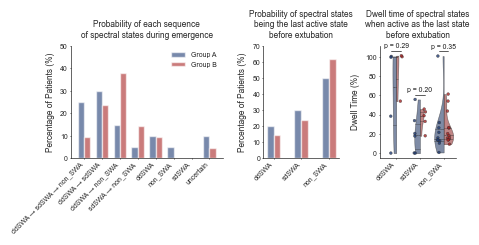

In [57]:
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.stats import ranksums

import matplotlib.pyplot as plt

set_custom_style()

# Create a figure with one row and three subplots
fig, axs = plt.subplots(1, 3, figsize=(5.13, 2.5), width_ratios=[2,1,1])  # Half of A4 width and full height

# Plot 1: Dwell time of SWR states when active as the last state
curr_ax = axs[2]
states = ['ddSWA', 'sdSWA', 'non_SWA']

sns.violinplot(x="State", y="Dwell Time (%)", hue="Group", data=df_plot, order=states, split=True, inner="quart", density_norm='count', cut=0, palette=[BLUE, RED], linewidth=0.4, alpha=0.6, ax=axs[2])
sns.stripplot(x="State", y="Dwell Time (%)", hue="Group", data=df_plot, order=states, dodge=True, jitter=True, size=2, palette=[BLUE, RED], alpha=0.8, linewidth=0.3, ax=axs[2])

# Perform ranksum tests and annotate the plot
for state in states:
    group_a = df_plot[(df_plot['State'] == state) & (df_plot['Group'] == 'Group A')]['Dwell Time (%)']
    group_b = df_plot[(df_plot['State'] == state) & (df_plot['Group'] == 'Group B')]['Dwell Time (%)']

    if not group_a.empty and not group_b.empty:
        stat, p_value = ranksums(group_a, group_b)
        p_value_text = f"{p_value:.1e}" if p_value < 0.01 else f"{p_value:.2f}"

        # Calculate the position for the annotation
        y, h, col = max(group_a.max(), group_b.max()) + 5, 2, 'k'
        curr_ax.plot([states.index(state) - 0.2, states.index(state) + 0.2], [y, y], lw=0.5, c=col)
        curr_ax.text(states.index(state), y + h, f"p = {p_value_text}", ha='center', va='bottom', color=col, fontsize=5)

curr_ax.set_xlim([-0.7, 2.5])
curr_ax.set_xticklabels(states, rotation=45, ha='right', va='top', fontsize=5)
curr_ax.set_title("Dwell time of spectral states\nwhen active as the last state\nbefore extubation", fontsize=6)
curr_ax.set_xlabel("")
curr_ax.set_ylabel("Dwell Time (%)", fontsize=6)
curr_ax.tick_params(axis='both', which='major', labelsize=5)

handles, labels = curr_ax.get_legend_handles_labels()
handles = handles[:2]  # Keep only the first two handles (violin plot handles)
labels = labels[:2]    # Keep only the first two labels (violin plot labels)
# curr_ax.legend(handles, labels, fontsize=5, loc='upper right')
curr_ax.legend([])

# Plot 2: Probability of SWR states being the last active state before extubation
curr_ax = axs[1]
bar_width = 0.25
index = np.arange(len(states))

bar_group_a = [end_state_frequencies['Group A'].get(state, 0) for state in states]
bar_group_b = [end_state_frequencies['Group B'].get(state, 0) for state in states]

bars1 = curr_ax.bar(index, bar_group_a, bar_width, label='Group A', color=BLUE, alpha=0.6)
bars2 = curr_ax.bar(index + bar_width, bar_group_b, bar_width, label='Group B', color=RED, alpha=0.6)

curr_ax.set_xlabel('')
curr_ax.set_ylabel('Percentage of Patients (%)', fontsize=6)
curr_ax.set_title('Probability of spectral states\nbeing the last active state\nbefore extubation', fontsize=6)
curr_ax.set_xticks(index + bar_width / 2)
curr_ax.set_xticklabels(states, rotation=45, ha='right', va='top', fontsize=5)
curr_ax.tick_params(axis='both', which='major', labelsize=5)
# curr_ax.legend(fontsize=5, loc='upper left')
curr_ax.set_ylim([0, 70])

def add_labels(bars, ax):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.1f}%',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', rotation=45, fontsize=4)

# add_labels(bars1, curr_ax)
# add_labels(bars2, curr_ax)

# Plot 3: Probability of each sequence of SWR states during emergence
curr_ax = axs[0]

trajcetory_names = []
for traj in trajectories:
    curr_traj_name = trajectories[traj][0]
    for state in trajectories[traj][1:]:
        curr_traj_name = curr_traj_name + " → " + state
    trajcetory_names.append(curr_traj_name)

bar_width = 0.35
index = np.arange(len(trajectories))

bar_group_a = [trajectory_percentages['Group A'].get(trajectory, 0) for trajectory in trajectories]
bar_group_b = [trajectory_percentages['Group B'].get(trajectory, 0) for trajectory in trajectories]

bars1 = curr_ax.bar(index, bar_group_a, bar_width, label='Group A', color=BLUE, alpha=0.6)
bars2 = curr_ax.bar(index + bar_width, bar_group_b, bar_width, label='Group B', color=RED, alpha=0.6)

curr_ax.set_ylim([0, 50])

curr_ax.set_xlabel('')
curr_ax.set_ylabel('Percentage of Patients (%)', fontsize=6)
curr_ax.set_title('Probability of each sequence\nof spectral states during emergence', fontsize=6)
curr_ax.set_xticks(index + bar_width / 2)
curr_ax.set_xticklabels(trajcetory_names, rotation=45, ha='right', va='top', fontsize=5)
curr_ax.tick_params(axis='both', which='major', labelsize=5)
curr_ax.legend(fontsize=5)

# add_labels(bars1, curr_ax)
# add_labels(bars2, curr_ax)

plt.subplots_adjust(left=0.15, right= 0.9, bottom=0.35, top=0.8, wspace=0.4, hspace=0.2)


main_dir = 'D:/Anesthesia_Research_Fellow/analysis_results'
filename = 'spectral_state_trajectory_analysis.pdf'

file_path = os.path.join(main_dir, filename)
plt.savefig(file_path, format='pdf', dpi=300)


plt.show()

##### Conscious versus unconscious comparison of the distributions of the spectral properties

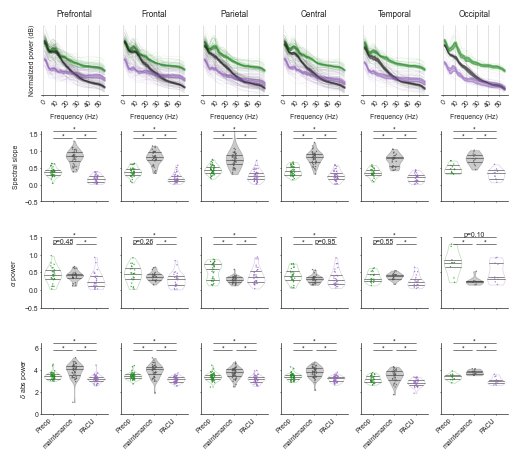

In [175]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon

# Set custom colors
green = "#228B22"
purple = "#9467bd"
gray = "#535353"  # Gray color for violin plots

fregs = loaded_power_spectral.frequencies

def extract_psds(region):
    preop_psds = {}
    emergence_psds = {}
    pacu_psds = {}
    for p in win_center:
        if group_label[p] == 'A' or group_label[p] == 'B':
            preop_psd = psd[p][region]['preop_rest'].flatten()
            pacu_psd = psd[p][region]['pacu_rest'].flatten()
            maintenance_psd = np.nanmean(psd[p][region]['emergence'], axis=1).flatten()

            preop_psd[preop_psd == 0] = 1e-16
            pacu_psd[pacu_psd == 0] = 1e-16
            maintenance_psd[maintenance_psd == 0] = 1e-16

            preop_psd = 10 * np.log10(preop_psd)
            pacu_psd = 10 * np.log10(pacu_psd)
            maintenance_psd = 10 * np.log10(maintenance_psd)

            if not np.isnan(preop_psd).any() and not np.isnan(pacu_psd).any() and not np.isnan(maintenance_psd).any() and (preop_psd > 0).all() and (pacu_psd > 0).all() and (maintenance_psd > 0).all():
                preop_psds[p] = preop_psd
                emergence_psds[p] = maintenance_psd
                pacu_psds[p] = pacu_psd

    return preop_psds, emergence_psds, pacu_psds

def extract_spectral_properties(region):
    preop_spectral_prop = {}
    emergence_spectral_prop = {}
    pacu_spectral_prop = {}
    for p in win_center:
        if group_label[p] == 'A' or group_label[p] == 'B':
            preop_prop = spectral_prop[p][region]['preop_rest']
            emergence_prop = spectral_prop[p][region]['emergence'][0]
            pacu_prop = spectral_prop[p][region]['pacu_rest']

            if preop_prop > 0.01 and pacu_prop > 0.01 and emergence_prop > 0.01:
                preop_spectral_prop[p] = preop_prop
                emergence_spectral_prop[p] = emergence_prop
                pacu_spectral_prop[p] = pacu_prop

    return preop_spectral_prop, emergence_spectral_prop, pacu_spectral_prop


spectral_prop_labels = {
    'reg_fit_slope': 'Spectral slope',
    'fband_power_fooof_alpha': r'$\alpha$ power',
    'fband_power_abs_delta': r'$\delta$ abs power',
}

psd = patients_pooled_data['psd']

# Define figure properties
set_custom_style()

plot_width = 70 * len(region_names)
plot_height = 400  # Adjusted height to fit 4 rows

fig, axs = plt.subplots(4, len(region_names), figsize=(plot_width / 72, plot_height / 72))

# Loop over each region
for i, region in enumerate(region_names):
    preop_psds, emergence_psds, pacu_psds = extract_psds(region)

    # Processing PSD data
    preop_data = np.vstack(list(preop_psds.values()))
    preop_med_psd = np.nanmedian(preop_data, axis=0)
    preop_sem_psd = bootstrap_sem(preop_data)

    emergence_data = np.vstack(list(emergence_psds.values()))
    emergence_med_psd = np.nanmedian(emergence_data, axis=0)
    emergence_sem_psd = bootstrap_sem(emergence_data)

    pacu_data = np.vstack(list(pacu_psds.values()))
    pacu_med_psd = np.nanmedian(pacu_data, axis=0)
    pacu_sem_psd = bootstrap_sem(pacu_data)

    # Plot the PSDs
    ax = axs[0, i]
    
    for p, p_psd in preop_psds.items():
        ax.plot(fregs, p_psd + 6, green, alpha=0.1, linewidth=0.3)
    ax.plot(fregs, preop_med_psd + 6, green, linewidth=0.3, alpha=0.7)
    ax.fill_between(fregs, preop_med_psd - preop_sem_psd + 6, preop_med_psd + preop_sem_psd + 6, color=green, alpha=0.5)
    
    for p, p_psd in emergence_psds.items():
        ax.plot(fregs, p_psd, 'k', alpha=0.1, linewidth=0.3)
    ax.plot(fregs, emergence_med_psd, 'k', linewidth=0.3, alpha=0.7)
    ax.fill_between(fregs, emergence_med_psd - emergence_sem_psd, emergence_med_psd + emergence_sem_psd, color='k', alpha=0.5)
    
    for p, p_psd in pacu_psds.items():
        ax.plot(fregs, p_psd - 6, purple, alpha=0.1, linewidth=0.3)
    ax.plot(fregs, pacu_med_psd - 6, purple, linewidth=0.3, alpha=0.7)
    ax.fill_between(fregs, pacu_med_psd - pacu_sem_psd - 6, pacu_med_psd + pacu_sem_psd - 6, color=purple, alpha=0.5)
    
    ax.set_ylim([0, 55])
    ax.set_title(f'{region.capitalize()}')
    ax.set_xlabel('Frequency (Hz)')
    if i == 0:
        ax.set_ylabel('Normalized power (dB)')
    if i > 0:
        ax.set_yticklabels("")
    ax.spines['left'].set_visible(False)
    ax.yaxis.set_ticks([])

    ax.set_xticks(np.arange(0, 55, 10))
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

    ax.grid(axis='x', linestyle='-', alpha=0.8, linewidth=0.5)  # Add x-grid only

    # Plot the spectral properties
    for j, (prop_key, prop_label) in enumerate(spectral_prop_labels.items()):
        ax = axs[j + 1, i]

        spectral_prop = patients_pooled_data[prop_key]
        preop_spectral_prop_dict, emergence_spectral_prop_dict, pacu_spectral_prop_dict = extract_spectral_properties(region)  

        preop_prop_vals = [v for p, v in preop_spectral_prop_dict.items()]
        emergence_prop_vals = [v for p, v in emergence_spectral_prop_dict.items()]
        pacu_prop_vals = [v for p, v in pacu_spectral_prop_dict.items()]

        preop_spectral_prop = np.vstack(preop_prop_vals).flatten()
        emergence_spectral_prop = np.vstack(emergence_prop_vals).flatten()
        pacu_spectral_prop = np.vstack(pacu_prop_vals).flatten()

        # Combine all three epochs in a single subplot
        parts = sns.violinplot(
            data=[preop_spectral_prop, emergence_spectral_prop, pacu_spectral_prop], 
            ax=ax, 
            cut=0, 
            inner='quart', 
            density_norm='area', 
            split=False,  
            palette=['w', gray, 'w'], 
            linewidth=0.5, 
            alpha=0.3
        )

        # Customize the violin plots' edge colors
        for k, violin in enumerate(parts.collections[:len(region_names)]):
            if k == 0:
                violin.set_edgecolor(green)
            elif k == 2:
                violin.set_edgecolor(purple)
        
        sns.stripplot(
            data=[preop_spectral_prop, emergence_spectral_prop, pacu_spectral_prop], 
            ax=ax, 
            jitter=True, 
            edgecolor='auto', 
            size=1, 
            palette=[green, gray, purple], 
            alpha=0.8
        )

        if 'slope' in prop_key:
            yl = [-0.5, 1.6]
        elif 'alpha' in prop_key:
            yl = [-0.5, 1.5]
        elif 'delta' in prop_key:
            yl = [0, 6.5]

        ax.set_ylim(yl)


        # Add significance lines and annotations
        
        #preop vs emergence
        try:
            y=yl[0] + 0.9*(yl[1]-yl[0])
            ax.plot([0, .9], [y, y], color='k', lw=0.5)
            p_value = wilcoxon(preop_spectral_prop, emergence_spectral_prop).pvalue
            if p_value < 0.05:
                ax.text(0.5, y - 0.01, '*', ha='center', fontsize=5)
            else:
                ax.text(0.5, y + 0.02, f'p={p_value:.2f}', ha='center', fontsize=5)
        except:
            pass

        #pacy vs emergence
        try:
            y=yl[0] + 0.9*(yl[1]-yl[0])
            ax.plot([1.1, 2], [y, y], color='k', lw=0.5)
            p_value = wilcoxon(pacu_spectral_prop, emergence_spectral_prop).pvalue
            if p_value < 0.05:
                ax.text(1.5, y - 0.01, '*', ha='center', fontsize=5)
            else:
                ax.text(1.5, y + 0.02, f'p={p_value:.2f}', ha='center', fontsize=5)
        except:
            pass

        #preop vs pacu
        try:
            y = yl[0] + 1*(yl[1]-yl[0])
            ax.plot([0, 2], [y, y], color='k', lw=0.5)
            p_value = wilcoxon(pacu_spectral_prop, preop_spectral_prop).pvalue
            if p_value < 0.05:
                ax.text(1, y - 0.01, '*', ha='center', fontsize=5)
            else:
                ax.text(1, y + 0.02, f'p={p_value:.2f}', ha='center', fontsize=5)
        except:
            pass


        for line in ax.lines:
            line.set_linestyle('-')
            line.set_linewidth(0.4)

        ax.set_xticks([0, 1, 2])
        if j == len(spectral_prop_labels) - 1:
            ax.set_xticklabels(['Preop', 'maintenance', 'PACU'], rotation=45, va='top', ha='right')
        else:
            ax.set_xticklabels('')

        if i == 0:
            ax.set_ylabel(prop_label)
        if i > 0:
            ax.set_yticklabels("")

        ax.grid(False)


plt.tight_layout()
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.9, wspace=0.2, hspace=0.5)

main_dir = 'D:/Anesthesia_Research_Fellow/analysis_results'
filename = 'power_spectral_slope_conscious_vs_unconscious.pdf'
file_path = os.path.join(main_dir, filename)
plt.savefig(file_path, format='pdf', dpi=300)

plt.show()

##### An elaboration of the above analysis by computing the distributions separately for each patient group

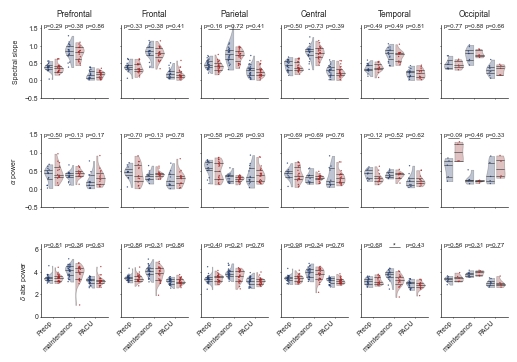

In [182]:
import numpy as np
import seaborn as sns
from scipy.stats import ranksums

import matplotlib.pyplot as plt

# Set custom colors
green = "#228B22"
purple = "#9467bd"
gray = "#535353"  # Gray color for violin plots

fregs = loaded_power_spectral.frequencies

def extract_psds(region):
    preop_psds = {}
    emergence_psds = {}
    pacu_psds = {}
    for p in win_center:
        if group_label[p] == 'A' or group_label[p] == 'B':
            preop_psd = psd[p][region]['preop_rest'].flatten()
            pacu_psd = psd[p][region]['pacu_rest'].flatten()
            maintenance_psd = np.nanmean(psd[p][region]['emergence'], axis=1).flatten()

            preop_psd[preop_psd == 0] = 1e-16
            pacu_psd[pacu_psd == 0] = 1e-16
            maintenance_psd[maintenance_psd == 0] = 1e-16

            preop_psd = 10 * np.log10(preop_psd)
            pacu_psd = 10 * np.log10(pacu_psd)
            maintenance_psd = 10 * np.log10(maintenance_psd)

            if not np.isnan(preop_psd).any() and not np.isnan(pacu_psd).any() and not np.isnan(maintenance_psd).any() and (preop_psd > 0).all() and (pacu_psd > 0).all() and (maintenance_psd > 0).all():
                preop_psds[p] = preop_psd
                emergence_psds[p] = maintenance_psd
                pacu_psds[p] = pacu_psd

    return preop_psds, emergence_psds, pacu_psds

def extract_spectral_properties(region):
    preop_spectral_prop_A = {}
    emergence_spectral_prop_A = {}
    pacu_spectral_prop_A = {}
    preop_spectral_prop_B = {}
    emergence_spectral_prop_B = {}
    pacu_spectral_prop_B = {}
    for p in win_center:
        if group_label[p] == 'A':
            preop_prop = spectral_prop[p][region]['preop_rest']
            emergence_prop = spectral_prop[p][region]['emergence'][0]
            pacu_prop = spectral_prop[p][region]['pacu_rest']

            if preop_prop > 0.01 and pacu_prop > 0.01 and emergence_prop > 0.01:
                preop_spectral_prop_A[p] = preop_prop
                emergence_spectral_prop_A[p] = emergence_prop
                pacu_spectral_prop_A[p] = pacu_prop
        elif group_label[p] == 'B':
            preop_prop = spectral_prop[p][region]['preop_rest']
            emergence_prop = spectral_prop[p][region]['emergence'][0]
            pacu_prop = spectral_prop[p][region]['pacu_rest']

            if preop_prop > 0.01 and pacu_prop > 0.01 and emergence_prop > 0.01:
                preop_spectral_prop_B[p] = preop_prop
                emergence_spectral_prop_B[p] = emergence_prop
                pacu_spectral_prop_B[p] = pacu_prop

    return preop_spectral_prop_A, emergence_spectral_prop_A, pacu_spectral_prop_A, preop_spectral_prop_B, emergence_spectral_prop_B, pacu_spectral_prop_B


spectral_prop_labels = {
    'reg_fit_slope': 'Spectral slope',
    'fband_power_fooof_alpha': r'$\alpha$ power',
    'fband_power_abs_delta': r'$\delta$ abs power',
}

psd = patients_pooled_data['psd']

# Define figure properties
set_custom_style()

plot_width = 70 * len(region_names)
plot_height = 300 

fig, axs = plt.subplots(3, len(region_names), figsize=(plot_width / 72, plot_height / 72))

# Loop over each region
for i, region in enumerate(region_names):
   
    # Plot the spectral properties
    for j, (prop_key, prop_label) in enumerate(spectral_prop_labels.items()):
        ax = axs[j , i]

        spectral_prop = patients_pooled_data[prop_key]
        preop_spectral_prop_A, emergence_spectral_prop_A, pacu_spectral_prop_A, preop_spectral_prop_B, emergence_spectral_prop_B, pacu_spectral_prop_B = extract_spectral_properties(region)  

        preop_prop_vals_A = [v for p, v in preop_spectral_prop_A.items()]
        emergence_prop_vals_A = [v for p, v in emergence_spectral_prop_A.items()]
        pacu_prop_vals_A = [v for p, v in pacu_spectral_prop_A.items()]

        preop_prop_vals_B = [v for p, v in preop_spectral_prop_B.items()]
        emergence_prop_vals_B = [v for p, v in emergence_spectral_prop_B.items()]
        pacu_prop_vals_B = [v for p, v in pacu_spectral_prop_B.items()]

        preop_spectral_prop_A = np.vstack(preop_prop_vals_A).flatten()
        emergence_spectral_prop_A = np.vstack(emergence_prop_vals_A).flatten()
        pacu_spectral_prop_A = np.vstack(pacu_prop_vals_A).flatten()

        preop_spectral_prop_B = np.vstack(preop_prop_vals_B).flatten()
        emergence_spectral_prop_B = np.vstack(emergence_prop_vals_B).flatten()
        pacu_spectral_prop_B = np.vstack(pacu_prop_vals_B).flatten()

        # Combine all three epochs in a single subplot
        parts = sns.violinplot(
            data=[preop_spectral_prop_A, preop_spectral_prop_B, emergence_spectral_prop_A, emergence_spectral_prop_B, pacu_spectral_prop_A, pacu_spectral_prop_B], 
            ax=ax, 
            cut=0, 
            inner='quart', 
            density_norm='area', 
            split=True,  
            palette=[BLUE, RED, BLUE, RED, BLUE, RED], 
            linewidth=0.5, 
            alpha=0.3
        )

        sns.stripplot(
            data=[preop_spectral_prop_A, preop_spectral_prop_B, emergence_spectral_prop_A, emergence_spectral_prop_B, pacu_spectral_prop_A, pacu_spectral_prop_B], 
            ax=ax, 
            jitter=True, 
            edgecolor='auto', 
            size=1, 
            palette=[BLUE, RED, BLUE, RED, BLUE, RED], 
            alpha=0.8
        )

        if 'slope' in prop_key:
            yl = [-0.5, 1.6]
        elif 'alpha' in prop_key:
            yl = [-0.5, 1.5]
        elif 'delta' in prop_key:
            yl = [0, 6.5]

        ax.set_ylim(yl)

        # Add significance lines and annotations

        y = yl[0] + 0.95 * (yl[1] - yl[0])
        # preop
        try:
            ax.plot([0, 1], [y, y], color='k', lw=0.5)
            p_value = ranksums(preop_spectral_prop_A, preop_spectral_prop_B).pvalue
            if p_value < 0.05:
                ax.text(.5, y - 0.01, '*', ha='center', fontsize=5)
            else:
                ax.text(.5, y + 0.04, f'p={p_value:.2f}', ha='center', fontsize=4.5)
        except:
            pass

        # emergence
        try:
            ax.plot([2, 3], [y, y], color='k', lw=0.5)
            p_value = ranksums(emergence_spectral_prop_A, emergence_spectral_prop_B).pvalue
            if p_value < 0.05:
                ax.text(2.5, y - 0.01, '*', ha='center', fontsize=5)
            else:
                ax.text(2.5, y + 0.04, f'p={p_value:.2f}', ha='center', fontsize=4.5)
        except:
            pass

        # pacu
        try:
            ax.plot([4, 5], [y, y], color='k', lw=0.5)
            p_value = ranksums(pacu_spectral_prop_A, pacu_spectral_prop_B).pvalue
            if p_value < 0.05:
                ax.text(4.5, y - 0.01, '*', ha='center', fontsize=5)
            else:
                ax.text(4.5, y + 0.04, f'p={p_value:.2f}', ha='center', fontsize=4.5)
        except:
            pass

        for line in ax.lines:
            line.set_linestyle('-')
            line.set_linewidth(0.4)

        ax.set_xticks([0.5, 2.5, 4.5])
        if j == len(spectral_prop_labels) - 1:
            ax.set_xticklabels(['Preop', 'maintenance', 'PACU'], rotation=45, va='top', ha='right')
        else:
            ax.set_xticklabels('')

        if i == 0:
            ax.set_ylabel(prop_label)
        if i > 0:
            ax.set_yticklabels("")

        ax.grid(False)

        if j==0:
            ax.set_title(f'{region.capitalize()}')

plt.tight_layout()
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.9, wspace=0.2, hspace=0.5)

main_dir = 'D:/Anesthesia_Research_Fellow/analysis_results'
filename = 'power_spectral_slope_conscious_vs_unconscious_split_violin.pdf'
file_path = os.path.join(main_dir, filename)
plt.savefig(file_path, format='pdf', dpi=300)

plt.show()

##### Plot PSDs for conscious versus unconscious states, separted by each patient group

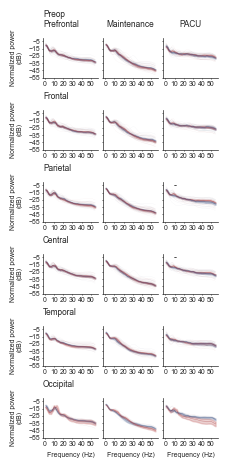

In [ ]:
from scipy.stats import wilcoxon

# orange = "#ff7f0e"
green = "#228B22"
purple = "#9467bd"
gray = "#535353"  # Gray Color for Violin Plots

freqs = loaded_power_spectral.frequencies

def extract_psds_group_averages(region):
    preop_psds = {}
    maintenance_psds = {}
    pacu_psds = {}
    for p in win_center:
        # Group A or B
        # Extracting and processing PSDs
        preop_psd = psd[p][region]['preop_rest'].flatten()
        pacu_psd = psd[p][region]['pacu_rest'].flatten()
        maintenance_psd = np.nanmean(psd[p][region]['emergence'], axis=1).flatten()
        if (group_label[p] == 'A' or group_label[p] == 'B') and np.sum(preop_psd) > 1 and np.sum(pacu_psd) > 1 and np.sum(maintenance_psd) > 1:    

            preop_psd = preop_psd/np.nansum(preop_psd)
            pacu_psd = pacu_psd/np.nansum(pacu_psd)
            maintenance_psd = maintenance_psd/np.nansum(maintenance_psd)

            preop_psd[preop_psd == 0] = 1e-16
            pacu_psd[pacu_psd == 0] = 1e-16
            maintenance_psd[maintenance_psd == 0] = 1e-16

            preop_psds[p] = 10*np.log10(preop_psd)
            pacu_psds[p] = 10*np.log10(pacu_psd)
            maintenance_psds[p] = 10*np.log10(maintenance_psd)

    # Processing PSD data for group A and B pateint data
    # preop
    groupA_preop_psds = {p: preop_psds[p] for p in group_label if group_label[p] == 'A' and p in preop_psds}
    groupA_preop_data = np.vstack(list(groupA_preop_psds.values()))
    groupA_preop_med_psd = np.nanmedian(groupA_preop_data, axis=0)
    groupA_preop_sem_psd = bootstrap_sem(groupA_preop_data)

    groupB_preop_psds = {p: preop_psds[p] for p in group_label if group_label[p] == 'B' and p in preop_psds}
    groupB_preop_data = np.vstack(list(groupB_preop_psds.values()))
    groupB_preop_med_psd = np.nanmedian(groupB_preop_data, axis=0)
    groupB_preop_sem_psd = bootstrap_sem(groupB_preop_data)

    # maintenace 
    groupA_maintenance_psds = {p: maintenance_psds[p] for p in group_label if group_label[p] == 'A' and p in preop_psds}
    groupA_maintenance_data = np.vstack(list(groupA_maintenance_psds.values()))
    groupA_maintenance_med_psd = np.nanmedian(groupA_maintenance_data, axis=0)
    groupA_maintenance_sem_psd = bootstrap_sem(groupA_maintenance_data)

    groupB_maintenance_psds = {p: maintenance_psds[p] for p in group_label if group_label[p] == 'B' and p in preop_psds}
    groupB_maintenance_data = np.vstack(list(groupB_maintenance_psds.values()))
    groupB_maintenance_med_psd = np.nanmedian(groupB_maintenance_data, axis=0)
    groupB_maintenance_sem_psd = bootstrap_sem(groupB_maintenance_data)

    # PACU
    groupA_pacu_psds = {p: pacu_psds[p] for p in group_label if group_label[p] == 'A' and p in preop_psds}
    groupA_pacu_data = np.vstack(list(groupA_pacu_psds.values()))
    groupA_pacu_med_psd = np.nanmedian(groupA_pacu_data, axis=0)
    groupA_pacu_sem_psd = bootstrap_sem(groupA_pacu_data)

    groupB_pacu_psds = {p: pacu_psds[p] for p in group_label if group_label[p] == 'B' and p in preop_psds}
    groupB_pacu_data = np.vstack(list(groupB_pacu_psds.values()))
    groupB_pacu_med_psd = np.nanmedian(groupB_pacu_data, axis=0)
    groupB_pacu_sem_psd = bootstrap_sem(groupB_pacu_data)

    return (
        groupA_preop_psds, groupA_preop_med_psd, groupA_preop_sem_psd, 
        groupB_preop_psds, groupB_preop_med_psd, groupB_preop_sem_psd,
        groupA_maintenance_psds, groupA_maintenance_med_psd, groupA_maintenance_sem_psd, 
        groupB_maintenance_psds, groupB_maintenance_med_psd, groupB_maintenance_sem_psd,
        groupA_pacu_psds, groupA_pacu_med_psd, groupA_pacu_sem_psd, 
        groupB_pacu_psds, groupB_pacu_med_psd, groupB_pacu_sem_psd,
    )

# Define figure properties
set_custom_style()

plot_width = 60 * 3
plot_height = 80 * len(region_names)

fig, axs = plt.subplots(len(region_names), 3, figsize=(plot_width/72 , plot_height/72))

# Loop over each region
for region_idx, region in enumerate(region_names):
    
    (
        groupA_preop_psds, groupA_preop_med_psd, groupA_preop_sem_psd, 
        groupB_preop_psds, groupB_preop_med_psd, groupB_preop_sem_psd,
        groupA_maintenance_psds, groupA_maintenance_med_psd, groupA_maintenance_sem_psd, 
        groupB_maintenance_psds, groupB_maintenance_med_psd, groupB_maintenance_sem_psd,
        groupA_pacu_psds, groupA_pacu_med_psd, groupA_pacu_sem_psd, 
        groupB_pacu_psds, groupB_pacu_med_psd, groupB_pacu_sem_psd,
    ) = extract_psds_group_averages(
        region
    )
    

    # Plot the preop PSDs for group A and B
    ax = axs[region_idx, 0]

    # group A:
    for p, p_psd in groupA_preop_psds.items():
        ax.plot(freqs, p_psd, BLUE, alpha=0.1, linewidth = 0.1)
    
    # group B:
    for p, p_psd in groupB_preop_psds.items():
        ax.plot(freqs, p_psd, RED, alpha=0.1, linewidth = 0.1)
    
    ax.plot(freqs, groupA_preop_med_psd, BLUE, linewidth=0.3, alpha=0.5)
    ax.fill_between(freqs, groupA_preop_med_psd - groupA_preop_sem_psd, groupA_preop_med_psd + groupA_preop_sem_psd, color=BLUE, alpha=0.2)

    ax.plot(freqs, groupB_preop_med_psd, RED, linewidth=0.3, alpha=0.5)
    ax.fill_between(freqs, groupB_preop_med_psd - groupB_preop_sem_psd, groupB_preop_med_psd + groupB_preop_sem_psd, color=RED, alpha=0.2)
    
    ax.set_xticks(np.arange(0, 55, 10))

    ax.set_ylim([-55, 0])
    # ax.set_ylim([0, 50])
    yl = ax.get_ylim()
    ax.set_yticks(np.arange(yl[0], yl[1], 10))
    if region_idx == 0:
        ax.set_title(f'Preop\n{region.capitalize()}', va = 'bottom', ha = 'left', loc='left')
    else:
        ax.set_title(f'{region.capitalize()}', va = 'bottom', ha = 'left', loc = 'left')
    
    if region_idx== 5:
        ax.set_xlabel('Frequency (Hz)')
    
    ax.set_ylabel('Normalized power\n(dB)')

    y=-5
    groupA_psds = np.vstack(list(groupA_preop_psds.values()))
    groupB_psds = np.vstack(list(groupB_preop_psds.values()))
    for freq_idx , freq in enumerate(freqs):
        p_value = ranksums(groupA_psds[:, freq_idx], groupB_psds[:, freq_idx]).pvalue
        if p_value < 0.05:
            ax.plot([freq-0.1, freq+0.1], [y, y], color='k', lw=0.5)


    # Plot the maintenance PSDs for group A and B
    ax = axs[region_idx, 1]

    # group A:
    for p, p_psd in groupA_maintenance_psds.items():
        ax.plot(freqs, p_psd, BLUE, alpha=0.1, linewidth = 0.1)
    
    # group B:
    for p, p_psd in groupB_maintenance_psds.items():
        ax.plot(freqs, p_psd, RED, alpha=0.1, linewidth = 0.1)
    
    ax.plot(freqs, groupA_maintenance_med_psd, BLUE, linewidth=0.3, alpha=0.5)
    ax.fill_between(freqs, groupA_maintenance_med_psd - groupA_maintenance_sem_psd, groupA_maintenance_med_psd + groupA_maintenance_sem_psd, color=BLUE, alpha=0.2)
    
    ax.plot(freqs, groupB_maintenance_med_psd, RED, linewidth=0.3, alpha=0.5)
    ax.fill_between(freqs, groupB_maintenance_med_psd - groupB_maintenance_sem_psd, groupB_maintenance_med_psd + groupB_maintenance_sem_psd, color=RED, alpha=0.2)

    ax.set_xticks(np.arange(0, 55, 10))

    ax.set_ylim([-55, 0])
    # ax.set_ylim([0, 50])
    yl = ax.get_ylim()
    ax.set_yticks(np.arange(yl[0], yl[1], 10))    
    if region_idx== 5:
        ax.set_xlabel('Frequency (Hz)')    
    ax.set_yticklabels("")

    if region_idx == 0:
        ax.set_title('Maintenance', va = 'bottom', ha = 'center', loc='center')

    groupA_psds = np.vstack(list(groupA_maintenance_psds.values()))
    groupB_psds = np.vstack(list(groupB_maintenance_psds.values()))
    for freq_idx , freq in enumerate(freqs):
        p_value = ranksums(groupA_psds[:, freq_idx], groupB_psds[:, freq_idx]).pvalue
        if p_value < 0.05:
            ax.plot([freq-0.1, freq+0.1], [y, y], color='k', lw=0.5)


    # Plot the PACU PSDs for group A and B
    ax = axs[region_idx, 2]

    # group A:
    for p, p_psd in groupA_pacu_psds.items():
        ax.plot(freqs, p_psd, BLUE, alpha=0.1, linewidth = 0.1)
    
    # group B:
    for p, p_psd in groupB_pacu_psds.items():
        ax.plot(freqs, p_psd, RED, alpha=0.1, linewidth = 0.1)

    ax.plot(freqs, groupB_pacu_med_psd, RED, linewidth=0.3, alpha=0.5)
    ax.fill_between(freqs, groupB_pacu_med_psd - groupB_pacu_sem_psd, groupB_pacu_med_psd + groupB_pacu_sem_psd, color=RED, alpha=0.2)

    ax.plot(freqs, groupA_pacu_med_psd, BLUE, linewidth=0.3, alpha=0.5)
    ax.fill_between(freqs, groupA_pacu_med_psd - groupA_pacu_sem_psd, groupA_pacu_med_psd + groupA_pacu_sem_psd, color=BLUE, alpha=0.2)

    ax.set_xticks(np.arange(0, 55, 10))

    ax.set_ylim([-55, 0])
    # ax.set_ylim([0, 50])
    yl = ax.get_ylim()
    ax.set_yticks(np.arange(yl[0], yl[1], 10))
    if region_idx == 5:
        ax.set_xlabel('Frequency (Hz)')    
    ax.set_yticklabels("")
    if region_idx == 0:
        ax.set_title('PACU', va = 'bottom', ha = 'center', loc='center')

    groupA_psds = np.vstack(list(groupA_pacu_psds.values()))
    groupB_psds = np.vstack(list(groupB_pacu_psds.values()))
    for freq_idx , freq in enumerate(freqs):
        p_value = ranksums(groupA_psds[:, freq_idx], groupB_psds[:, freq_idx]).pvalue
        if p_value < 0.05:
            ax.plot([freq-0.1, freq+0.1], [y, y], color='k', lw=0.5)

plt.tight_layout()
plt.subplots_adjust(left=0.2, right= 0.9, bottom=0.2, top=0.8, wspace=0.1, hspace=0.8)

main_dir = 'E:/Caffeine_data/'
filename = 'PSDs_groupA_vs_B_normalized.pdf'
file_path = os.path.join(main_dir, filename)
plt.savefig(file_path, format='pdf', dpi=300)

plt.show()

### Trash

In [ ]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
import os
from scipy.stats import ranksums
from matplotlib.patches import Rectangle

# Set the normalization flags
NORMALIZE_AMP = True
NORMALIZE_TIME = True

spectral_metric = reg_fit_slope 
min_acceptable_vlue = 0.01

blue = "#1f3b73"  # Dark Blue
red = "#a82323"  # Dark Red

def calculate_normalization_factor(win_center_dic, slope_dict):
    pre_infusion_mean_std = {}
    for p, times in win_center_dic.items():
        times = np.asarray(times).flatten()
        slopes = np.asarray(slope_dict[p]).flatten()
        if np.sum(slopes) > min_acceptable_vlue:  # Ensure the slopes are not entirely zero
            # Calculate mean and std of slopes with window_center less than 600
            slopes_less_600 = slopes[times < 600]
            # pre_infusion_mean_std[p] = (np.nanmean(slopes_less_600), np.nanstd(slopes_less_600))
            pre_infusion_mean_std[p] = (np.nanmax(slopes_less_600), np.nan)
        else:
            pre_infusion_mean_std[p] = (np.nan, np.nan)
            
    return pre_infusion_mean_std

def normalize_time(win_center_dict, slope_dict):
    max_patient = max(win_center_dict, key=lambda k: len(win_center_dict[k]))
    num_time_points = len(win_center_dict[max_patient])
    
    max_time = win_center_dict[max_patient][-1]
    
    all_win_centers = np.linspace(0, max_time, num_time_points)

    slope_dict_normal_time = {}
    win_center_normal_time = {}
    for p, times in win_center_dict.items():
        win_center_normal_time[p] = all_win_centers

        times = np.asarray(times).flatten()
        slopes = np.asarray(slope_dict[p]).flatten()
        
        # Interpolate slopes to match the new time points
        new_times = np.linspace(times[0], times[-1], num_time_points)
        slopes = np.interp(new_times, times, slopes)
        slope_dict_normal_time[p] = slopes

    return win_center_normal_time, slope_dict_normal_time

def bootstrap_sem(data, num_bootstrap=1000):
    n = data.shape[1]
    boot_medians = np.zeros((num_bootstrap, n))
    for i in range(num_bootstrap):
        samples = np.random.choice(data.shape[0], size=data.shape[0], replace=True)
        boot_medians[i, :] = np.nanmedian(data[samples, :], axis=0)
    return np.nanstd(boot_medians, axis=0, ddof=1)

def align_and_average(win_center_dict, slope_dict, normalize_factor):

    all_win_centers = sorted(set().union(*win_center_dict.values()))
        
    avg_dict = {}
    for p, times in win_center_dict.items():
        try:
            times = np.asarray(times).flatten()
            slopes = np.asarray(slope_dict[p]).flatten()
            if np.sum(slopes) > 0.1:  # Ensure the slopes are not entirely zero
                interpolated_slopes = np.interp(all_win_centers, times, slopes)
                interpolated_slopes[all_win_centers > times[-1]] = np.nan
                
                if NORMALIZE_AMP:
                    # Normalize slopes
                    # slopes = z_score(slopes, normalize_factor[p])
                    mean, _ = normalize_factor[p]
                    interpolated_slopes = interpolated_slopes / mean
                    
                avg_dict[p] = interpolated_slopes
        except Exception as e:
            warnings.warn(f"Warning: An error occurred while aligning and averaging for patient {p}: {e}", UserWarning)
    
    # Stack all patient data together
    data = np.vstack(list(avg_dict.values()))
    
    # Non-parametric median
    median_all = np.nanmedian(data, axis=0)
    
    # Bootstrapped SEM
    sem_all = bootstrap_sem(data)
    
    return np.array(all_win_centers), median_all, sem_all

# def align_and_average(win_center_dict, slope_dict, normalize_factor):

#     all_win_centers = sorted(set().union(*win_center_dict.values()))
        
#     avg_dict = {}
#     for p, times in win_center_dict.items():
#         try:
#             times = np.asarray(times).flatten()
#             slopes = np.asarray(slope_dict[p]).flatten()
#             if np.sum(slopes) > 0.1:  # Ensure the slopes are not entirely zero
#                 if NORMALIZE_AMP:
#                     # Normalize slopes
#                     slopes = z_score(slopes, normalize_factor[p])
#                 else:
#                     interpolated_slopes = np.interp(all_win_centers, times, slopes)
#                     interpolated_slopes[all_win_centers > times[-1]] = np.nan
#                     slopes = interpolated_slopes
                    
#                 avg_dict[p] = slopes
#         except Exception as e:
#             warnings.warn(f"Warning: An error occurred while aligning and averaging for patient {p}: {e}", UserWarning)
            
#     avg_all = np.nanmean(np.vstack(list(avg_dict.values())), axis=0)
#     sem_all = np.nanstd(np.vstack(list(avg_dict.values())), axis=0) / np.sqrt(len(avg_dict))
    
#     return np.array(all_win_centers), avg_all, sem_all

def flatten_and_filter(data):
    flatten_data = []
    for sublist in data:
        if isinstance(sublist, (list, np.ndarray)):
            for item in sublist:
                if item is not None: 
                    flatten_data.append(item)
        elif isinstance(sublist, (float, int, np.float64, np.int64)):  
            flatten_data.append(sublist)
    return flatten_data

def z_score(data, mean_std):
    mean, std = mean_std
    return (data - mean) / std

def apply_normalization(data, mean_std):
    if NORMALIZE_AMP:
        mean, _ = mean_std
        return data/mean
        # return z_score(data, mean_std)
    return data

# Define figure properties
plot_width = 250
plot_height = 100 * len(region_names)
set_custom_style()
fig, axs = plt.subplots(len(region_names), 3, figsize=(plot_width/72, plot_height/72), gridspec_kw={'width_ratios': [0.1, 1, 0.1]})

if len(region_names) == 1:
    axs = [axs]  # Ensure axs is iterable when there is only one region

# Loop over each region
for idx, region in enumerate(region_names):
    win_center_emergence = {p: win_center[p][region]['emergence'] for p in win_center if np.sum(spectral_metric[p][region]['emergence']) > min_acceptable_vlue}
    reg_fit_slope_emergence = {p: spectral_metric[p][region]['emergence'] for p in spectral_metric if np.sum(spectral_metric[p][region]['emergence']) > min_acceptable_vlue}

    if NORMALIZE_TIME:
        win_center_emergence, reg_fit_slope_emergence =  normalize_time( win_center_emergence, reg_fit_slope_emergence)

    # Calculate normalization factor for each patient
    normalize_factor = calculate_normalization_factor(win_center_emergence, reg_fit_slope_emergence)

    # Plot preop_rest violin and strip plots
    ax_preop = axs[idx, 0]
    preop_rest_groupA = [apply_normalization(spectral_metric[p][region]['preop_rest'], normalize_factor[p]) for p in group_label if group_label[p] == 'A' and p in normalize_factor and spectral_metric[p][region]['preop_rest'] > min_acceptable_vlue]
    preop_rest_groupB = [apply_normalization(spectral_metric[p][region]['preop_rest'], normalize_factor[p]) for p in group_label if group_label[p] == 'B' and p in normalize_factor and spectral_metric[p][region]['preop_rest'] > min_acceptable_vlue]
    preop_rest_groupA = flatten_and_filter(preop_rest_groupA)
    preop_rest_groupB = flatten_and_filter(preop_rest_groupB)
    
    sns.violinplot(data=[preop_rest_groupA, preop_rest_groupB], ax=ax_preop, cut=0, inner='quart', density_norm='area', split=True, palette=[blue, red], linewidth=0.5, alpha=0.3)
    sns.stripplot(data=[preop_rest_groupA, preop_rest_groupB], ax=ax_preop, jitter=True, edgecolor='auto', size=1, palette=[blue, red], alpha=0.8)
    
    ax_preop.set_xticks([0, 1])
    ax_preop.set_xticklabels(['Group A', 'Group B'], rotation=45)
    ax_preop.set_ylim([0, 1.6])
    ax_preop.set_title(f"{region.capitalize()}\nPreop-Rest")
    if NORMALIZE_AMP:
        ax_preop.set_ylabel('Spectral slope\n(normalized)')
    else:
        ax_preop.set_ylabel('Spectral slope\n(dB/Hz)')

    ax_preop.spines['top'].set_visible(False)
    ax_preop.spines['right'].set_visible(False)

    for line in ax_preop.lines:
        line.set_linestyle('-')
        line.set_linewidth(0.4)

    # Perform ranksum test and add significance line
    y = 1.5
    ax_preop.plot([0, 1], [y, y], color='k', lw=0.5)
    p_value = ranksums(preop_rest_groupA, preop_rest_groupB).pvalue
    ax_preop.text(0.5, y + 0.05, f'{p_value:.2f}', ha='center', fontsize=5)
    
    # Plot emergence line plots
    ax_emergence = axs[idx, 1]
    for p in win_center_emergence:
        times = np.asarray(win_center_emergence[p]).flatten()
        slopes = np.asarray(reg_fit_slope_emergence[p]).flatten()
            
        norm_slopes = apply_normalization(slopes, normalize_factor[p])
        
        if group_label[p] == 'A':
            ax_emergence.plot(times - 600, norm_slopes, '-', color=blue, label='Group A' if 'Group A' not in ax_emergence.get_legend_handles_labels()[1] else "", linewidth=0.25, alpha=0.2)
        elif group_label[p] == 'B':
            ax_emergence.plot(times - 600, norm_slopes, '-', color=red, label='Group B' if 'Group B' not in ax_emergence.get_legend_handles_labels()[1] else "", linewidth=0.25, alpha=0.2)

    # Split data by group
    groupA_prefrontal_data = {p: win_center_emergence[p] for p in group_label if group_label[p] == 'A' and p in win_center_emergence}
    groupB_prefrontal_data = {p: win_center_emergence[p] for p in group_label if group_label[p] == 'B' and p in win_center_emergence}
    groupA_slope_data = {p: reg_fit_slope_emergence[p] for p in group_label if group_label[p] == 'A' and p in reg_fit_slope_emergence}
    groupB_slope_data = {p: reg_fit_slope_emergence[p] for p in group_label if group_label[p] == 'B' and p in reg_fit_slope_emergence}

    avg_win_centers_A, avg_slopes_A, sem_A = align_and_average(groupA_prefrontal_data, groupA_slope_data, normalize_factor)
    avg_win_centers_B, avg_slopes_B, sem_B = align_and_average(groupB_prefrontal_data, groupB_slope_data, normalize_factor)

    # Plot averages with SEM
    ax_emergence.plot(avg_win_centers_A - 600, avg_slopes_A, '-', color=blue, linewidth=0.5, label='Avg Group A')
    ax_emergence.fill_between(avg_win_centers_A - 600, avg_slopes_A - sem_A, avg_slopes_A + sem_A, color=blue, alpha=0.5)
    # ax_emergence.plot(avg_win_centers_A - 600, avg_slopes_A + sem_A, color=blue, linestyle='--', linewidth=0.3)
    # ax_emergence.plot(avg_win_centers_A - 600, avg_slopes_A - sem_A, color=blue, linestyle='--', linewidth=0.3)

    ax_emergence.plot(avg_win_centers_B - 600, avg_slopes_B, '-', color=red, linewidth=0.5, label='Avg Group B')
    ax_emergence.fill_between(avg_win_centers_B - 600, avg_slopes_B - sem_B, avg_slopes_B + sem_B, color=red, alpha=0.5)
    # ax_emergence.plot(avg_win_centers_B - 600, avg_slopes_B + sem_B, color=red, linestyle='--', linewidth=0.3)
    # ax_emergence.plot(avg_win_centers_B - 600, avg_slopes_B - sem_B, color=red, linestyle='--', linewidth=0.3)


    ax_emergence.set_title('Peri-drug infusion')
    ax_emergence.set_xticks(np.arange(0, win_center_emergence['CA-01'][-1], 1000))
    ax_emergence.set_xlabel('Time (sec)')
    ax_emergence.set_yticklabels('')

    if idx == 0:
        ax_legend = fig.add_subplot([0.65, 0.88, 0.1, 0.05])
        legend_lines, legend_labels = ax_emergence.get_legend_handles_labels()
        ax_legend.legend(legend_lines, legend_labels, loc='center', fontsize=5)
        ax_legend.spines['bottom'].set_visible(False)
        ax_legend.spines['left'].set_visible(False)
        ax_legend.set_xticks([])
        ax_legend.set_yticks([])
        ax_legend.tick_params(bottom=False, left=False)
        ax_legend.set_facecolor('none')

    ax_emergence.set_ylim([0, 1.6])
    ax_emergence.set_xlim([-700, win_center_emergence['CA-01'][-1]])

    if NORMALIZE_AMP:
        start_time = -600
        end_time = 0
        yl = ax_emergence.get_ylim()
        rect = Rectangle((start_time, yl[0]), end_time - start_time, yl[1]-yl[0], facecolor='gray', alpha=0.2)
        ax_emergence.add_patch(rect)

    ax_emergence.spines['top'].set_visible(False)
    ax_emergence.spines['right'].set_visible(False)
    
    # Perform ranksum test for each time point and add significance asterisks
    diff_time = avg_win_centers_A[1] - avg_win_centers_A[0]
    for i, time_point in enumerate(avg_win_centers_A):
        groupA_at_time = [apply_normalization(reg_fit_slope_emergence[p][np.argmin(np.abs(win_center_emergence[p] - time_point))], normalize_factor[p]) for p in groupA_prefrontal_data if time_point in win_center_emergence[p]]
        groupB_at_time = [apply_normalization(reg_fit_slope_emergence[p][np.argmin(np.abs(win_center_emergence[p] - time_point))], normalize_factor[p]) for p in groupB_prefrontal_data if time_point in win_center_emergence[p]]
        if groupA_at_time and groupB_at_time:
            p_value = ranksums(groupA_at_time, groupB_at_time).pvalue
            if p_value < 0.05:
                ax_emergence.plot([time_point-600-(diff_time/2), time_point-600+(diff_time/2)], [y, y], color='k', lw=0.5)

    # Plot pacu_rest violin and strip plots
    ax_pacu = axs[idx, 2]
    pacu_rest_groupA = [apply_normalization(spectral_metric[p][region]['pacu_rest'], normalize_factor[p]) for p in group_label if group_label[p] == 'A' and p in normalize_factor and spectral_metric[p][region]['pacu_rest'] > min_acceptable_vlue]
    pacu_rest_groupB = [apply_normalization(spectral_metric[p][region]['pacu_rest'], normalize_factor[p]) for p in group_label if group_label[p] == 'B' and p in normalize_factor and spectral_metric[p][region]['pacu_rest'] > min_acceptable_vlue]
    pacu_rest_groupA = flatten_and_filter(pacu_rest_groupA)
    pacu_rest_groupB = flatten_and_filter(pacu_rest_groupB)
    
    sns.violinplot(data=[pacu_rest_groupA, pacu_rest_groupB], ax=ax_pacu, cut=0, inner='quart', density_norm='area', split=True, palette=[blue, red], linewidth=0.5, alpha=0.3)
    sns.stripplot(data=[pacu_rest_groupA, pacu_rest_groupB], ax=ax_pacu, jitter=True, edgecolor='auto', size=1, palette=[blue, red], alpha=0.8)
    
    ax_pacu.set_xticks([0, 1])
    ax_pacu.set_xticklabels(['Group A', 'Group B'], rotation=45)
    ax_pacu.set_yticklabels('')
    ax_pacu.set_ylim([0, 1.6])

    ax_pacu.set_title('PACU-rest')

    ax_pacu.spines['top'].set_visible(False)
    ax_pacu.spines['right'].set_visible(False)

    for line in ax_pacu.lines:
        line.set_linestyle('-')
        line.set_linewidth(0.4)

    # Perform ranksum test and add significance line
    ax_pacu.plot([0, 1], [y, y], color='k', lw=0.5)
    p_value = ranksums(pacu_rest_groupA, pacu_rest_groupB).pvalue
    ax_pacu.text(0.5, y + 0.05, f'{p_value:.2f}', ha='center', fontsize=5)

plt.tight_layout()
plt.subplots_adjust(left=0.1, right= 0.9, bottom=0.1, top=0.9, wspace=0.05)

main_dir = 'E:/Caffeine_data/'

filename = 'power_spectral_slope_groupA_vs_groupB'
if NORMALIZE_AMP:
    filename += '_normalized_to_pre_infusion'
if NORMALIZE_TIME:
    filename += '_time_normalized'
filename += '.pdf'

file_path = os.path.join(main_dir, filename)
plt.savefig(file_path, format='pdf', dpi=300)

plt.show()

#### Generate the violinplots corresponding to emergence divisions 

In [ ]:
# Function to calculate quartiles
def calculate_quartiles(data_dict, times_dict, start_time=600):
    quartile_data = {}
    for p, data in data_dict.items():
        times = np.asarray(times_dict[p])
        relevant_data = data[times > start_time]
        relevant_data = apply_normalization(relevant_data, normalize_factor[p])
        num_quartiles = num_emergence_divisions
        if len(relevant_data) >= num_quartiles:
            quartiles = np.array_split(relevant_data, num_quartiles)
            quartile_avg = [np.nanmean(q) for q in quartiles]
        else:
            quartile_avg = [np.nan] * num_quartiles
        quartile_data[p] = quartile_avg
    return quartile_data

def remove_outliers(data, method='iqr', threshold=1.5):
    """
    Remove outliers from a list of data using the specified method.
    Supports 'iqr' (Interquartile Range) or 'std' (Standard Deviation).
    """
    data = np.array(data)
    if method == 'iqr':
        # IQR method
        q1, q3 = np.nanpercentile(data, [25, 75])
        iqr = q3 - q1
        lower_bound = q1 - threshold * iqr
        upper_bound = q3 + threshold * iqr
    elif method == 'std':
        # Standard Deviation method
        mean = np.nanmean(data)
        std_dev = np.nanstd(data)
        lower_bound = mean - threshold * std_dev
        upper_bound = mean + threshold * std_dev
    else:
        raise ValueError("Invalid method. Choose 'iqr' or 'std'.")
    
    # Filter data
    return data[(data >= lower_bound) & (data <= upper_bound)]

num_emergence_divisions = 5

# # Create a new figure for violin plots
# plot_width = 200
# plot_height = 100 * len(region_names)
# fig_violin, axs = plt.subplots(len(region_names), 3, figsize=(plot_width / 72, plot_height / 72), gridspec_kw={'width_ratios': [0.2, 1, 0.2]})


# Define figure properties
ncols = 3
nrows = int(np.ceil(len(region_names) / ncols)) * (len(spectral_prop_labels)+1)
plot_width = 170 * ncols 
plot_height = 80 * nrows

set_custom_style()  # Assuming this is defined separately

fig, axs = plt.subplots(
    nrows=nrows, 
    ncols=ncols, 
    figsize=(plot_width / 72, plot_height / 72), 
    # sharex=True, 
    height_ratios=[1,1,1,1,0.25,1,1,1,1,0.25],
)
axs = axs.flatten()  # Flatten the axes for easier indexing

# Loop over each region for violin plots
for region_idx, region in enumerate(region_names): 
    for sp_idx, spectral_prop_name in enumerate(spectral_prop_labels):

        # print(spectral_prop_name)

        col = region_idx % ncols  # Column index
        row = (region_idx // ncols) * (len(spectral_prop_labels)+1) + sp_idx   # Row index
        curr_ax = axs[row * ncols + col]  # Access the subplot
        
        win_center_emergence = win_center_emergence_all_regions[spectral_prop_name][region]
        spectral_prop_time_course_emergence = spectral_prop_time_course_emergence_all_regions[spectral_prop_name][region]
        
        # Calculate normalization factor for each patient
        normalize_factor = calculate_normalization_factor(win_center_emergence, spectral_prop_time_course_emergence)
        
        # Calculate quartile data
        quartile_data_A = calculate_quartiles({p: spectral_prop_time_course_emergence[p] for p in group_label if group_label[p] == 'A' and p in spectral_prop_time_course_emergence}, win_center_emergence)
        quartile_data_B = calculate_quartiles({p: spectral_prop_time_course_emergence[p] for p in group_label if group_label[p] == 'B' and p in spectral_prop_time_course_emergence}, win_center_emergence)

        # Combine data so the order is Q1 A and B, Q2 A and B, etc.
        combined_quartiles = []
        colors = []
        for q in range(num_emergence_divisions):
            quartile_A = [quartile_data_A[p][q] for p in quartile_data_A]
            quartile_B = [quartile_data_B[p][q] for p in quartile_data_B]
            quartile_A = remove_outliers(quartile_A)
            quartile_B = remove_outliers(quartile_B)
            combined_quartiles.append(quartile_A)
            combined_quartiles.append(quartile_B)
            colors.extend([BLUE, RED])

        # Plot quartile emergence data
        sns.violinplot(data=combined_quartiles, ax=curr_ax, cut=0, inner='quart', density_norm='area', palette=colors, linewidth=0.5, alpha=0.4, split=True)
        sns.stripplot(data=combined_quartiles, ax=curr_ax, jitter=True, edgecolor='auto', size=1, palette=colors, alpha=0.8)
        curr_ax.set_xticks(np.arange(0.5, 8.6, 2))
        if sp_idx == len(spectral_prop_labels)-1:
            curr_ax.set_xticklabels([f'E{div}' for div in range(num_emergence_divisions)])
        else:
            curr_ax.set_xticklabels('')

        for line in curr_ax.lines:
            line.set_linestyle('-')
            line.set_linewidth(0.4)

        if sp_idx == 0:
            curr_ax.set_title(f"{region.capitalize()}", loc='left', fontweight='bold', y=1.1)

        if NORMALIZE_AMP:
            curr_ax.set_ylabel(f'{spectral_prop_labels[spectral_prop_name]}\n(normalized)')
        else:
            if spectral_prop_name == 'reg_fit_slope':
                curr_ax.set_ylabel(f'{spectral_prop_labels[spectral_prop_name]}\n(dB/Hz)')
            else:
                curr_ax.set_ylabel(f'{spectral_prop_labels[spectral_prop_name]}\n(dB)')

        curr_ax.set_ylim([ylim_lower_bound[spectral_prop_name], ylim_upper_bound[spectral_prop_name]])

        # Perform ranksum test and add significance line for each quartile
        significance_line_y=1 * (ylim_upper_bound[spectral_prop_name] - ylim_lower_bound[spectral_prop_name]) + ylim_lower_bound[spectral_prop_name]
        for i in range(num_emergence_divisions):
            quartile_A = [quartile_data_A[p][i] for p in quartile_data_A]
            quartile_B = [quartile_data_B[p][i] for p in quartile_data_B]
            try:
                quartile_A = [x for x in quartile_A if ~np.isnan(x)]
                quartile_B = [x for x in quartile_B if ~np.isnan(x)]
                p_value_quartile = ranksums(quartile_A, quartile_B).pvalue
                curr_ax.plot([i * 2, (i * 2) + 1], [significance_line_y, significance_line_y], color='k', lw=0.5)
                curr_ax.text(i * 2 + 0.5, significance_line_y * 1.02, f'p={p_value_quartile:.2f}', ha='center', fontsize=5)
            except ValueError:
                continue

    row = (region_idx // ncols) * (len(spectral_prop_labels)+1) + len(spectral_prop_labels) # Row index
    curr_ax = axs[row * ncols + col]  # Access the subplot
    curr_ax.remove()

        
plt.tight_layout()
plt.subplots_adjust(left=0.15, right= 0.9, bottom=0.1, top=0.9, wspace=0.4, hspace=0.25)

main_dir = 'D:/Anesthesia_Research_Fellow/analysis_results'
filename = f'violinplots_emergence_quartiles_groupA_vs_groupB'
if NORMALIZE_AMP:
    filename += '_normalized_to_pre_infusion'
# if NORMALIZE_TIME:
#     filename += '_time_normalized'
filename += '.pdf'

file_path = os.path.join(main_dir, filename)
plt.savefig(file_path, format='pdf', dpi=300)

plt.show()

##### Calculate a decay time constant for the time courses of the spectral props

In [ ]:
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit, OptimizeWarning
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
from numpy.linalg import LinAlgError

# Function to smooth the data
def smooth_data(data, polyorder=3):
    try:
        if len(data) < 3 or np.isnan(data).any():
            return data  # Not enough data points to smooth, return as is
        window_length = min(5, len(data) if len(data) % 2 == 1 else len(data) - 1)
        return savgol_filter(data, window_length=window_length, polyorder=polyorder, mode='interp')
    except (LinAlgError, ValueError):
        return data  # Return the data as is if smoothing fails

# Exponential decay model function
def exponential_decay(t, a, b):
    return a * np.exp(-b * t)

# Function to calculate the decay time constant
from scipy.optimize import curve_fit
import numpy as np

# Exponential decay model
def exponential_decay(t, A, k):
    return A * np.exp(-k * t)

# Function to calculate the decay time constant
def calculate_decay_time_constant(times, data, threshold):
    max_value = np.max(data)
    max_index = np.argmax(data)

    # Reference value for the decay threshold
    decay_threshold = max_value * threshold

    # Restrict decay points to those after the maximum
    decay_points = times[(data < decay_threshold) & (np.arange(len(data)) > max_index)]

    if len(decay_points) == 0:
        decay_index = len(times) - 1  # Use the last time point if no decay below the threshold
    else:
        decay_index = np.where(times == decay_points[0])[0][0]

    if decay_index == 0 or len(data[:decay_index]) < 2:
        return np.nan  # Not enough data points to fit a reliable curve

    try:
        # Fit the exponential decay model on the data till the decay index
        popt, _ = curve_fit(exponential_decay, times[:decay_index], data[:decay_index], p0=(max_value, 0.01))
        return 1 / popt[1]  # Return the decay time constant
    except (RuntimeError, OptimizeWarning):
        return np.nan  # Handle cases where the fit fails


# Normalization functions
def calculate_normalization_factors(win_center_dic, slope_dict):
    mean_std_600 = {}
    for p, times in win_center_dic.items():
        times = np.asarray(times).flatten()
        slopes = np.asarray(slope_dict[p]).flatten()
        if np.sum(slopes) > MIN_ACCEPTABLE_VALUE:
            slopes_less_600 = slopes[times < 600]
            mean_std_600[p] = (np.nanmean(slopes_less_600), np.nanstd(slopes_less_600), np.nanmean(slopes_less_600))
        else:
            mean_std_600[p] = (np.nan, np.nan, np.nan)
    return mean_std_600

def z_score(data, mean_std):
    mean, std = mean_std[:2]
    return (data - mean) / std

# Set the normalization flag
NORMALIZE = True

# Number of regions for plotting
num_regions = len(region_names)
fig, axes = plt.subplots(nrows=num_regions, figsize=(3, 2*num_regions))

if num_regions == 1:
    axes = [axes]  # Make axes iterable if there's only one region

for i, region in enumerate(region_names):
    win_center_emergence = {p: win_center[p][region]['emergence'] for p in win_center if np.sum(spectral_prop[p][region]['emergence']) > MIN_ACCEPTABLE_VALUE}
    reg_fit_slope_emergence = {p: spectral_prop[p][region]['emergence'] for p in spectral_prop if np.sum(spectral_prop[p][region]['emergence']) > MIN_ACCEPTABLE_VALUE}

    # Calculate normalization factor for each patient
    mean_std_600 = calculate_normalization_factors(win_center_emergence, reg_fit_slope_emergence)

    groupA_decay_constants = []
    groupB_decay_constants = []

    decay_threshold = 0.1

    for p in win_center_emergence:
        times = np.asarray(win_center_emergence[p]).flatten()
        slopes = np.asarray(reg_fit_slope_emergence[p]).flatten()
        
        if slopes.size == 0 or times.size == 0:
            decay_constant = np.nan
        else:
            # normalized_slopes = z_score(slopes, mean_std_600[p])
            smoothed_slopes = smooth_data(slopes)
            # mean_value = mean_std_600[p][2]
            decay_constant = calculate_decay_time_constant(times-600, smoothed_slopes, decay_threshold)
        
        if group_label[p] == 'A':
            groupA_decay_constants.append(decay_constant)
        elif group_label[p] == 'B':
            groupB_decay_constants.append(decay_constant)
    
    decay_constants_flat_A = [item for item in groupA_decay_constants if not np.isnan(item)]
    decay_constants_flat_B = [item for item in groupB_decay_constants if not np.isnan(item)]

    ax = axes[i]

    sns.violinplot(data=[decay_constants_flat_A, decay_constants_flat_B], cut=0, inner='quart', palette=["#1f3b73", "#a82323"], ax=ax, alpha = 0.1)
    sns.stripplot(data=[decay_constants_flat_A, decay_constants_flat_B], jitter=True, edgecolor='auto', size=5, palette=["#1f3b73", "#a82323"], ax=ax)

    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Group A', 'Group B'], rotation=45)
    ax.set_title(f'{region.capitalize()}')
    ax.set_ylabel('Time Constant (s)')
    # ax.set_ylim(bottom=0)  # Assuming no negative time constants

plt.tight_layout()
plt.show()

#### The previous versions for plotting the average time-frequency maps

##### Version 1

In [ ]:
from matplotlib.gridspec import GridSpec
from src.eeg_analysis.visualization.plots import plot_continuous_epochs
import seaborn as sns
from scipy.stats import ranksums

def gen_significance_string(p_value):
    if p_value < 0.001:
        return '***'
    elif p_value < 0.01:
        return '**'
    elif p_value < 0.05:
        return '*'
    else:
        return 'n.s.'

set_custom_style()

BLUE = "#1f3b73"  # Dark Blue
RED = "#a82323"  # Dark Red

curr_regions = ['prefrontal', 'frontal', 'parietal']

rows = len(curr_regions)
cols = 7
fig = plt.figure(figsize=(8, 2.5))
gs = GridSpec(rows, cols, figure=fig, hspace=0.3, wspace=0.3, width_ratios=[0.8, 0.8, 0.4, 0.4, .3, .3, .3])

for region_idx , region in enumerate(curr_regions):
    for group_idx, (group, group_name) in enumerate(zip([groups['A'], groups['B']], ["Group A", "Group B"])):
            
        ax_tfr = fig.add_subplot(gs[region_idx, group_idx])

        curr_tfr = group_avg_tfr[group_name][region] #_pre_drug_normalized
        times = curr_tfr.times
        im = plot_continuous_epochs(
            curr_tfr, 
            ax=ax_tfr, 
            vmin=0, 
            vmax=45,
            # vmin=-5, 
            # vmax=8, 
            cmap="inferno", 
            title=f"{p_name} TFR"
        ) 


        ax_tfr.plot(times, conv_band_powers_stats['delta'][group_name][region]['median']/15000+1, color='c', linewidth=0.3, alpha=0.7, label=r'$\delta$ power ' + f'({fbands['delta'][0]} - {fbands['delta'][1]} Hz)')
        ax_tfr.fill_between(
            times,
            (conv_band_powers_stats['delta'][group_name][region]['median'] - conv_band_powers_stats['delta'][group_name][region]['sem'])/15000+1,
            (conv_band_powers_stats['delta'][group_name][region]['median'] + conv_band_powers_stats['delta'][group_name][region]['sem'])/15000+1,
            color='c', alpha=0.5, linewidth=0
        )

        ax_tfr.plot(times, conv_band_powers_stats['alpha'][group_name][region]['median']/8000+13, color='white', linewidth=0.3, alpha=0.7, label=r'$\alpha$ power ' + f'({fbands['alpha'][0]} - {fbands['alpha'][1]} Hz)')
        ax_tfr.fill_between(
            times,
            (conv_band_powers_stats['alpha'][group_name][region]['median'] - conv_band_powers_stats['alpha'][group_name][region]['sem'])/8000+13,
            (conv_band_powers_stats['alpha'][group_name][region]['median'] + conv_band_powers_stats['alpha'][group_name][region]['sem'])/8000+13,
            color='white', alpha=0.5, linewidth=0
        )

        ax_tfr.plot(times, conv_band_powers_stats['beta'][group_name][region]['median']/1000+25, color='m', linewidth=0.3, alpha=0.7, label=r'$\beta$ power ' + f'({fbands['beta'][0]} - {fbands['beta'][1]} Hz)')
        ax_tfr.fill_between(
            times,
            (conv_band_powers_stats['beta'][group_name][region]['median'] - conv_band_powers_stats['beta'][group_name][region]['sem'])/1000+25,
            (conv_band_powers_stats['beta'][group_name][region]['median'] + conv_band_powers_stats['beta'][group_name][region]['sem'])/1000+25,
            color='m', alpha=0.5, linewidth=0
        )
        
        if group_idx != 0:
            ax_tfr.set_yticklabels([])

        if group_idx == 0:
            ax_tfr.set_ylabel("Frequency (Hz)", fontsize=5)

        ax_tfr.set_xticks(np.arange(0, 1.01, 0.2))
        if region_idx < len(curr_regions)-1:
            ax_tfr.set_xticklabels([])

        if region_idx == len(curr_regions)-1:
            ax_tfr.set_xlabel('Time (normalized)')
        
        for spine in ax_tfr.spines.values():
            spine.set_linewidth(0.5)
        # 
        ax_tfr.grid(False)
        ax_tfr.set_ylim([0.5, 35])
        
        # if region_idx == 0:
        #     ax_tfr.set_title(f'{group_name}\n\n{region.capitalize()}', pad = 0.5, fontsize=6, color=BLUE if 'A' in group_name else RED, fontweight='bold', loc='left')
        # else:
        #     ax_tfr.set_title(region.capitalize(), pad = 0.5, fontsize=6, color=BLUE if 'A' in group_name else RED, fontweight='bold', loc='left')
        if region_idx == 0:
            ax_tfr.set_title(f'{group_name}', pad = 5, fontsize=6, color=BLUE if 'A' in group_name else RED, fontweight='bold', loc='left')

        if group_idx == 0:
            current_ax_pos = ax_tfr.get_position().bounds
            region_label_pos = [current_ax_pos[0]-0.05, current_ax_pos[1]+current_ax_pos[3]/2, 0.1, 0.1]
            ax_tfr.text(
                region_label_pos[0], region_label_pos[1], region.capitalize(), 
                fontsize=6, color='black', fontweight='bold', ha='center', va='center', transform=fig.transFigure
            )

        ax_tfr.tick_params(axis='both', which='major', labelsize=5, length=2, width=0.5, pad=0.5)

        ax_tfr.yaxis.grid(True, which='both', linestyle='--', linewidth=0.3)

        if region_idx == 0 and group_idx == 0:
            legend_lines, legend_labels = ax_tfr.get_legend_handles_labels()

        # plot the start and end median plus bootstrap_sem emergence PSD for each group
        ax_psd = fig.add_subplot(gs[region_idx, group_idx+2])
        median, sem = calculate_statistics(10*np.log10(group_start_emergence_psd[group_name][region]))
        ax_psd.plot(freqs, median, color=BLUE if 'A' in group_name else RED, label='Start', linewidth=0.5, alpha = 1)
        ax_psd.fill_between(freqs, median-sem, median+sem, color=BLUE if 'A' in group_name else RED, alpha=0.6, linewidth=0)

        median, sem = calculate_statistics(10*np.log10(group_end_emergence_psd[group_name][region]))
        ax_psd.plot(freqs, median, color=BLUE if 'A' in group_name else RED, label='Start', linewidth=0.5, alpha=0.7)
        ax_psd.fill_between(freqs, median-sem, median+sem, color=BLUE if 'A' in group_name else RED, alpha=0.4, linewidth=0)

        ax_psd.set_xticks(np.arange(0, 51, 10))
        if region_idx == len(curr_regions)-1:
            ax_psd.set_xlabel('Frequency (Hz)', fontsize=5)
            ax_psd.set_xticklabels(np.arange(0, 51, 10), fontsize=4)
        else:
            ax_psd.set_xticklabels([])

        ax_psd.set_yticks(np.arange(0, 45, 10))
        ax_psd.set_ylabel('Power (dB)', fontsize=5, labelpad=0)

        ax_psd.grid(True, which='both', linestyle='--', linewidth=0.3, color='gray')

        # # plot the scatterplot of start and end band power for each group
        # ax_band_power = fig.add_subplot(gs[region_idx, group_idx+4])
        # ax_band_power.scatter(
        #     10*np.log10(group_emergence_start_band_powers['delta'][group_name][region]), 
        #     10*np.log10(group_emergence_start_band_powers['alpha'][group_name][region]), 
        #     color=BLUE if 'A' in group_name else RED, s=2, alpha=0.7, marker='.', label='Start'
        # )
        # ax_band_power.scatter(
        #     10*np.log10(group_emergence_end_band_powers['delta'][group_name][region]), 
        #     10*np.log10(group_emergence_end_band_powers['alpha'][group_name][region]), 
        #     color=BLUE if 'A' in group_name else RED, s=2, alpha=0.7, marker='+', label='End'
        # )
        # ax_band_power.set_xlim([30, 65])
        # ax_band_power.set_ylim([20, 60])
 
    # frequency band power
    for fband_idx, fband in enumerate(['delta', 'alpha', 'beta']):
        
        ax_band_power = fig.add_subplot(gs[region_idx, fband_idx+4])

        # start and end band power for each group
        # Group A
        start_A_values = group_emergence_start_band_powers[fband]['Group A'][region]
        end_A_values = group_emergence_end_band_powers[fband]['Group A'][region]

        accepted_A_values = np.logical_and(start_A_values > 0.1, end_A_values > 0.1)
        # start_A_values = 10*np.log10(start_A_values[accepted_A_values])
        # end_A_values = 10*np.log10(end_A_values[accepted_A_values])
        start_A_values = start_A_values[accepted_A_values]
        end_A_values = end_A_values[accepted_A_values]

        # Group B
        start_B_values = group_emergence_start_band_powers[fband]['Group B'][region]
        end_B_values = group_emergence_end_band_powers[fband]['Group B'][region]

        accepted_B_values = np.logical_and(start_B_values > 0.1, end_B_values > 0.1)
        # start_B_values = 10*np.log10(start_B_values[accepted_B_values])
        # end_B_values = 10*np.log10(end_B_values[accepted_B_values])
        start_B_values = start_B_values[accepted_B_values]
        end_B_values = end_B_values[accepted_B_values]


        sns.violinplot(
            data=[
                start_A_values, 
                end_A_values,
                start_B_values,
                end_B_values
            ], 
            split=True,
            cut=0,
            inner='quart',
            palette=[BLUE, BLUE, RED, RED],
            alpha=0.7,
            linewidth=0.5,
            ax=ax_band_power,
            edgecolor='white'
        )

        ax_band_power.set_xticks(np.arange(0, 4, 1))
        if region_idx == len(curr_regions)-1:  
            ax_band_power.set_xticklabels(['Start A', 'End A', 'Start B', 'End B'], fontsize=4, rotation=35, va = 'top', ha='right')
        else:
            ax_band_power.set_xticklabels([])
        ax_band_power.set_ylabel(rf'$\{fband}$ power (dB)', fontsize=5, labelpad=0)

        # Perform statistical tests
        yl = ax_band_power.get_ylim()
        
        # # comparing start band power between two groups
        # A_vs_B_start_comparison_stat, A_vs_B_start_comparison_pval = ranksums(start_A_values, start_B_values)
        # y = yl[1] - 0*(yl[1] - yl[0])
        # ax_band_power.plot([0, 1], [y, y], color='black', linewidth=0.5)
        # ax_band_power.text(0.5, y+0.04*(yl[1]- yl[0]), f'p={A_vs_B_start_comparison_pval:.3f}', ha='center', fontsize=4)

        # # comparing end band power between two groups
        # A_vs_B_end_comparison_stat, A_vs_B_end_comparison_pval = ranksums(end_A_values, end_B_values)
        # y = yl[1] - 0*(yl[1] - yl[0])
        # ax_band_power.plot([2, 3], [y, y], color='black', linewidth=0.5)
        # ax_band_power.text(2.5, y+0.04*(yl[1]-yl[0]), f'p={A_vs_B_end_comparison_pval:.3f}', ha='center', fontsize=4)

        # Comparing start and end band power for each group
        A_start_vs_end_comparison_stat, A_start_vs_end_comparison_pval = ranksums(start_A_values, end_A_values)
        
        y = yl[1] + 0*(yl[1] - yl[0])
        ax_band_power.plot([0, 1], [yl[1], yl[1]], color='black', linewidth=0.5)
        p_val_string = gen_significance_string(A_start_vs_end_comparison_pval)
        ax_band_power.text(0.5, y+0.04*(yl[1] - yl[0]), f'{p_val_string}', ha='center', fontsize=4)

        B_start_vs_end_comparison_stat, B_start_vs_end_comparison_pval = ranksums(start_B_values, end_B_values)

        y = yl[1] + 0*(yl[1] - yl[0])
        ax_band_power.plot([2, 3], [yl[1], yl[1]], color='black', linewidth=0.5)
        p_val_string = gen_significance_string(B_start_vs_end_comparison_pval)
        ax_band_power.text(2.5, y+0.04*(yl[1] - yl[0]), f'{p_val_string}', ha='center', fontsize=4)

        # Comparing decrease from start to end in band power between two groups
        decrease_A = start_A_values - end_A_values
        decrease_B = start_B_values - end_B_values

        A_vs_B_decrease_comparison_stat, A_vs_B_decrease_comparison_pval = ranksums(decrease_A, decrease_B)
        
        y = yl[1] + 0.17*(yl[1] - yl[0])
        ax_band_power.plot([0.5, 2.5], [y, y], color='black', linewidth=0.5)
        p_val_string = gen_significance_string(A_vs_B_decrease_comparison_pval)
        ax_band_power.text(1.5, y+0.05*(yl[1] - yl[0]), rf'$\Delta$A vs $\Delta$B {p_val_string}', ha='center', fontsize=4)

plt.subplots_adjust(left=0.15, right= 0.9, bottom=0.1, top=0.85, wspace=0.4, hspace=0.25)

ax_legend = fig.add_subplot([0.4, 0.9, 0.1, 0.05])
ax_legend.legend(legend_lines, legend_labels, loc='center', fontsize=5, facecolor = 'black')
ax_legend.spines['bottom'].set_visible(False)
ax_legend.spines['left'].set_visible(False)
ax_legend.set_xticks([])
ax_legend.set_yticks([])
ax_legend.tick_params(bottom=False, left=False)
ax_legend.set_facecolor = 'gray'


main_dir = 'D:/Anesthesia_Research_Fellow/analysis_results'
filename = 'tfr_avg_groupA_vs_groupB_three_regions_2'
if AS_FRACTION_OF_POWER:
    filename += '_fraction_of_power'
filename += '.pdf'

file_path = os.path.join(main_dir, filename)
plt.savefig(file_path, format='pdf', dpi=300)

plt.show()

##### Version 2

In [ ]:
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from src.eeg_analysis.visualization.plots import plot_continuous_epochs
import seaborn as sns
from scipy.stats import ranksums

def gen_significance_string(p_value):
    if p_value < 0.001:
        return '***'
    elif p_value < 0.01:
        return '**'
    elif p_value < 0.05:
        return '*'
    else:
        return 'n.s.'

set_custom_style()

DB_BEFORE_AVG = True

BLUE = "#1f3b73"  # Dark Blue
RED = "#a82323"  # Dark Red

curr_regions = ['prefrontal', 'frontal', 'parietal']

fbands = {
        'alpha': [7, 14] , 
        'delta': [0.5, 4], 
        # 'theta': [4, 7], 
        'beta': [18, 35], 
        # 'gamma': [35, 50]
    }
fband_names = ['delta', 'alpha', 'beta']

color = {'delta': 'c',
         'alpha': 'gray',
         'beta': 'm'}

if DB_BEFORE_AVG:
    divide_factor = {'delta': 2,
                    'alpha': 2,
                    'beta': 2}
    offsets = {'delta': -20,
            'alpha': -5,
            'beta': 10}
else:
    divide_factor = {'delta': 15000,
                    'alpha': 8000,
                    'beta': 1000}
    offsets = {'delta': 1,
            'alpha': 13,
            'beta': 25}


rows = 8
cols = len(curr_regions)
fig = plt.figure(figsize=(7, 5))
gs = GridSpec(rows, cols, figure=fig, hspace=0.2, wspace=0.2, height_ratios=[1]*2 + [0.15] + [0.6] + [0.15] + [0.6]*3)

for region_idx , region in enumerate(curr_regions):
    for group_idx, (group, group_name) in enumerate(zip([groups['A'], groups['B']], ["Group A", "Group B"])):
            
        ax_tfr = fig.add_subplot(gs[group_idx, region_idx])

        if DB_BEFORE_AVG:
            curr_tfr = group_avg_tfr_db[group_name][region]
            db_plot = False # avoid further transformation to dB inside the plot function
        else:
            curr_tfr = group_avg_tfr[group_name][region]
            db_plot = True
        
        times = curr_tfr.times
        
        im = plot_continuous_epochs(
            curr_tfr, 
            ax=ax_tfr,
            db = db_plot,
            vmin=0, 
            vmax=40,
            # vmin=-5, 
            # vmax=8, 
            cmap="inferno", 
            # title=f"{p_name} TFR"
        ) 

        for fband in fband_names:
            data = np.array([
                    conv_band_powers_smoothed[fband][p_name][region] 
                    for p_name in group 
                    if conv_band_powers_smoothed[fband][p_name][region] is not None and np.any(conv_band_powers_smoothed[fband][p_name][region] > 0.01) 
                ])

            if data.size > 0:
                if DB_BEFORE_AVG:
                    data[data == 0] = 10^-16
                    data = 10*np.log10(data)
                    median, sem = calculate_statistics(data)
                else:
                    median, sem = calculate_statistics(data)

                conv_band_powers_stats[fband][group_name][region] = {'median': median, 'sem': sem}

            ax_tfr.plot(times, conv_band_powers_stats[fband][group_name][region]['median']/divide_factor[fband]+offsets[fband], color=color[fband], linewidth=0.3, alpha=0.7, label=rf'$\{fband}$ power ' + f'({fbands[fband][0]} - {fbands[fband][1]} Hz)')
            ax_tfr.fill_between(
                times,
                (conv_band_powers_stats[fband][group_name][region]['median'] - conv_band_powers_stats[fband][group_name][region]['sem'])/divide_factor[fband]+offsets[fband],
                (conv_band_powers_stats[fband][group_name][region]['median'] + conv_band_powers_stats[fband][group_name][region]['sem'])/divide_factor[fband]+offsets[fband],
                color=color[fband], alpha=0.5, linewidth=0
            )
         
        ax_tfr.set_ylabel("Frequency (Hz)", fontsize=5)

        ax_tfr.set_xticks(np.arange(0, 1.01, 0.2))
        if group_idx == 0:
            ax_tfr.set_xticklabels([])

        if group_idx == 1:
            ax_tfr.set_xlabel('Time (normalized)', labelpad=0)
        
        for spine in ax_tfr.spines.values():
            spine.set_linewidth(0.5)
        # 
        ax_tfr.grid(False)
        ax_tfr.set_ylim([0.5, 35])
        ax_tfr.set_yticks(np.arange(0, 35, 10))
        
        if group_idx == 0:
            ax_tfr.set_title(region.capitalize(), pad = 5, fontsize=6, color='k', fontweight='bold', loc='center')

        if region_idx == 0:
            current_ax_pos = ax_tfr.get_position().bounds
            region_label_pos = [current_ax_pos[0]-0.07, current_ax_pos[1]+current_ax_pos[3]/2, 0.1, 0.1]
            ax_tfr.text(
                region_label_pos[0], region_label_pos[1], group_name, 
                fontsize=6, color=BLUE if 'A' in group_name else RED, fontweight='bold', ha='center', va='center', transform=fig.transFigure
            )

        ax_tfr.tick_params(axis='both', which='major', labelsize=5, length=2, width=0.5, pad=0.5)

        ax_tfr.yaxis.grid(True, which='both', linestyle='--', linewidth=0.3)

        if region_idx == 0 and group_idx == 0:
            legend_lines, legend_labels = ax_tfr.get_legend_handles_labels()


        ## plot for each emergence division the median and bootstrap_sem of the PSD for each group
        ax_psd = fig.add_subplot(gs[3, region_idx])
        # partition the ax_psd into num_divisions subplots
        gs_psd = GridSpecFromSubplotSpec(1, num_divisions, subplot_spec=ax_psd, hspace=0.1)
        ax_psd.set_axis_off()
        for i in range(num_divisions):
            div_ax_psd = fig.add_subplot(gs_psd[0, i])

            median_A, sem_A = calculate_statistics(10*np.log10(group_emergnece_division_psd['Group A'][region][i]))
            median_B, sem_B = calculate_statistics(10*np.log10(group_emergnece_division_psd['Group B'][region][i]))


            div_ax_psd.plot(freqs, median_A, color=BLUE, label=f'{i+1}', linewidth=0.5, alpha = 0.7)
            div_ax_psd.fill_between(freqs, median_A-sem_A, median_A+sem_A, color=BLUE, alpha=0.3, linewidth=0)
            div_ax_psd.plot(freqs, median_B, color=RED, label=f'{i+1}', linewidth=0.5, alpha = 0.7)
            div_ax_psd.fill_between(freqs, median_B-sem_B, median_B+sem_B, color=RED, alpha=0.3, linewidth=0)

            if i == num_divisions//2:
                div_ax_psd.set_xlabel('Frequency (Hz)', fontsize=5, labelpad=0)
            
            div_ax_psd.set_xticks(np.arange(0, 51, 10))
            
            xtls = div_ax_psd.get_xticklabels()
            xtls_new = ['']*len(xtls)
            xtls_new[0] = xtls[0]
            xtls_new[-1] = xtls[-1]
            div_ax_psd.set_xticklabels(xtls_new)

            div_ax_psd.set_yticks(np.arange(0, 45, 10))
            if i == 0:
                div_ax_psd.set_ylabel('Power (dB)', fontsize=5)
            else:
                div_ax_psd.set_yticklabels([])

            div_ax_psd.grid(True, which='both', linestyle='--', linewidth=0.3, color='gray')
    

    # frequency band power
    for fband_idx, fband in enumerate(fband_names):
        ax_band_power = fig.add_subplot(gs[5+fband_idx, region_idx])

        # emergence division band powers for each group
        # A
        group_A_division_band_powers = group_emergence_division_band_powers[fband]['Group A'][region]
        accepted_A_group_patients = [np.all(patients_div_values > 0.1) for patients_div_values in group_A_division_band_powers]
        
        if DB_BEFORE_AVG: 
            group_A_division_band_powers = 10*np.log10(group_A_division_band_powers[accepted_A_group_patients])
        else:
            group_A_division_band_powers = group_A_division_band_powers[accepted_A_group_patients]

        # B
        group_B_division_band_powers = group_emergence_division_band_powers[fband]['Group B'][region]
        accepted_B_group_patients = [np.all(patients_div_values > 0.1) for patients_div_values in group_B_division_band_powers]

        if DB_BEFORE_AVG:
            group_B_division_band_powers = 10*np.log10(group_B_division_band_powers[accepted_B_group_patients])
        else:
            group_B_division_band_powers = group_B_division_band_powers[accepted_B_group_patients]


        data = []
        for i in range(num_divisions):
            data.append(group_A_division_band_powers[:, i])
            data.append(group_B_division_band_powers[:, i])


        sns.violinplot(
            data = data,
            split=True,
            cut=0,
            inner='quart',
            palette = [BLUE, RED]*num_divisions,
            alpha=0.7,
            linewidth=0.5,
            ax=ax_band_power,
            edgecolor='white',
            width=0.7
        )
        if DB_BEFORE_AVG == False:
            ax_band_power.set_yscale('log')
            ax_band_power.minorticks_off()


        ax_band_power.set_ylabel(rf'$\{fband}$ power (dB)', fontsize=5, labelpad=0)

        ax_band_power.set_xticks(np.arange(0, 10, 2)+0.5)
        if fband_idx == len(fband_names)-1:  
            ax_band_power.set_xticklabels(['E1', 'E2', 'E3', 'E4', 'E5'], fontsize=4, rotation=35, va = 'top', ha='right')
        else:
            ax_band_power.set_xticklabels([])

        ax_band_power.set_xlim([-0.5, len(data)-0.5])

        # Perform statistical tests
        yl = ax_band_power.get_ylim()
        y = yl[1] - 0*(yl[1] - yl[0])
        for i in range(num_divisions):
            A_vs_B_comparison_stat, A_vs_B_comparison_pval = ranksums(group_A_division_band_powers[:, i], group_B_division_band_powers[:, i])
            
            ax_band_power.plot([i*2, i*2+1], [y, y], color='black', linewidth=0.5)
            ax_band_power.text(i*2+0.5, y+0.04*(yl[1]- yl[0]), f'p={A_vs_B_comparison_pval:.3f}', ha='center', fontsize=4)


ax_legend = fig.add_subplot([0.3, 0.93, 0.1, 0.05])
ax_legend.legend(legend_lines, legend_labels, loc='center', fontsize=5, facecolor = 'black')
ax_legend.spines['bottom'].set_visible(False)
ax_legend.spines['left'].set_visible(False)
ax_legend.set_xticks([])
ax_legend.set_yticks([])
ax_legend.tick_params(bottom=False, left=False)
ax_legend.set_facecolor = 'gray'


main_dir = 'D:/Anesthesia_Research_Fellow/analysis_results'
filename = 'tfr_avg_groupA_vs_groupB_three_regions_v2'
if AS_FRACTION_OF_POWER:
    filename += '_fraction_of_power'
if DB_BEFORE_AVG:
    filename += 'db_before_average'
filename += '.pdf'

file_path = os.path.join(main_dir, filename)
plt.savefig(file_path, format='pdf', dpi=300)

plt.show()

#### Previous version of the code for comparing the absolute values of the spectral properties between conscious (preop/PACU) and unconscious (maintenance/predrug infusion) states

In [ ]:
from scipy.stats import wilcoxon

# orange = "#ff7f0e"
green = "#228B22"
purple = "#9467bd"
gray = "#535353"  # Gray Color for Violin Plots

fregs = loaded_power_spectral.frequencies

def extract_psds_spectral_prop(region):
    preop_psds = {}
    emergence_psds = {}
    pacu_psds = {}
    preop_spectral_prop = {}
    emergence_spectral_prop = {}
    pacu_spectral_prop = {}
    for p in win_center:
        # Group A or B
        if group_label[p] == 'A' or group_label[p] == 'B':
            
            # Extracting and processing PSDs
            preop_psd = psd[p][region]['preop_rest'].flatten()
            pacu_psd = psd[p][region]['pacu_rest'].flatten()
            maintenance_psd = np.nanmean(psd[p][region]['emergence'], axis=1).flatten()

            # preop_psd = preop_psd/np.nansum(preop_psd)
            # pacu_psd = pacu_psd/np.nansum(pacu_psd)
            # maintenance_psd = maintenance_psd/np.nansum(maintenance_psd)

            preop_psd[preop_psd == 0] = 1e-16
            pacu_psd[pacu_psd == 0] = 1e-16
            maintenance_psd[maintenance_psd == 0] = 1e-16

            preop_psd = 10*np.log10(preop_psd)
            pacu_psd = 10*np.log10(pacu_psd)
            maintenance_psd = 10*np.log10(maintenance_psd)

            # Extracting the spectral prop extracted from the PSDs
            preop_prop = spectral_prop[p][region]['preop_rest']
            emergence_prop = spectral_prop[p][region]['emergence'][0]
            pacu_prop = spectral_prop[p][region]['pacu_rest']

            if (not np.isnan(preop_psd).any() and not np.isnan(pacu_psd).any() and not np.isnan(maintenance_psd).any() and
                preop_prop > 0.01 and pacu_prop > 0.01 and emergence_prop > 0.01):
                
                # Stroing PSD data
                preop_psds[p] = preop_psd
                emergence_psds[p] = maintenance_psd
                pacu_psds[p] = pacu_psd

                # Storing Spectral porp data
                preop_spectral_prop[p] = preop_prop
                emergence_spectral_prop[p] = emergence_prop
                pacu_spectral_prop[p] = pacu_prop

    # Processing PSD data
    preop_data = np.vstack(list(preop_psds.values()))
    preop_med_psd = np.nanmedian(preop_data, axis=0)
    preop_sem_psd = bootstrap_sem(preop_data)

    emergence_data = np.vstack(list(emergence_psds.values()))
    emergence_med_psd = np.nanmedian(emergence_data, axis=0)
    emergence_sem_psd = bootstrap_sem(emergence_data)

    pacu_data = np.vstack(list(pacu_psds.values()))
    pacu_med_psd = np.nanmedian(pacu_data, axis=0)
    pacu_sem_psd = bootstrap_sem(pacu_data)

    return (
        preop_psds, preop_med_psd, preop_sem_psd, preop_spectral_prop,
        emergence_psds, emergence_med_psd, emergence_sem_psd, emergence_spectral_prop,
        pacu_psds, pacu_med_psd, pacu_sem_psd, pacu_spectral_prop
    )


spectral_prop_labels = {
    'reg_fit_slope': 'Spectral slope',
    'fband_power_fooof_alpha': r'$\alpha$ power',
    'fband_power_abs_delta': r'$\delta$ abs power',
    # 'fband_power_fooof_beta': r'$\beta$ power',
    # 'fband_power_fooof_gamma': r'$\gamma$ power',
    # 'fband_central_freq_alpha': r'$\alpha$ central freq.',
}

psd = patients_pooled_data['psd']
spectral_prop = patients_pooled_data['reg_fit_slope']


# Define figure properties
set_custom_style()

plot_width = 70 * len(region_names)
plot_height = 200

fig, axs = plt.subplots(2, len(region_names), figsize=(plot_width/72 , plot_height/72))

# Loop over each region
for i, region in enumerate(region_names):

    (preop_psds, preop_med_psd, preop_sem_psd, preop_spectral_prop_dict,   
    emergence_psds, emergence_med_psd, emergence_sem_psd, emergence_spectral_prop_dict, 
    pacu_psds, pacu_med_psd, pacu_sem_psd, pacu_spectral_prop_dict) = extract_psds_spectral_prop(region)

    # preop_spectral_prop, emergence_spectral_prop, pacu_spectral_prop = extract_spectral_prop(region)

    # Plot the PSDs
    ax = axs[0, i]
    
    for p, p_psd in preop_psds.items():
        ax.plot(fregs, p_psd+6, green, alpha=0.1, linewidth = 0.3)
    ax.plot(fregs, preop_med_psd+6, green, linewidth=0.3, alpha=0.7)
    ax.fill_between(fregs, preop_med_psd - preop_sem_psd + 6, preop_med_psd + preop_sem_psd + 6, color=green, alpha=0.5)

    # ax.plot(preop_med_psd - preop_sem_psd, green, linewidth=0.3, linestyle='--', alpha=0.7)
    # ax.plot(preop_med_psd + preop_sem_psd, green, linewidth = 0.3,linestyle='--', alpha=0.7)
    
    for p, p_psd in emergence_psds.items():
        ax.plot(fregs, p_psd, 'k', alpha=0.1, linewidth = 0.3)
    ax.plot(fregs, emergence_med_psd, 'k', linewidth=0.3, alpha=0.7)
    ax.fill_between(fregs, emergence_med_psd - emergence_sem_psd, emergence_med_psd + emergence_sem_psd, color='k', alpha=0.5)

    # ax.plot(emergence_med_psd - emergence_sem_psd, 'k', linewidth=0.3, linestyle='--', alpha=0.7)
    # ax.plot(emergence_med_psd + emergence_sem_psd, 'k', linewidth = 0.3,linestyle='--', alpha=0.7)

    for p, p_psd in pacu_psds.items():
        ax.plot(fregs, p_psd - 6, purple, alpha=0.1, linewidth = 0.3)
    ax.plot(fregs, pacu_med_psd - 6, purple, linewidth=0.3, alpha=0.7)
    ax.fill_between(fregs, pacu_med_psd - pacu_sem_psd - 6, pacu_med_psd + pacu_sem_psd - 6, color=purple, alpha=0.5)

    # ax.plot(pacu_med_psd - pacu_sem_psd, purple, linewidth=0.3, linestyle='--', alpha=0.7)
    # ax.plot(pacu_med_psd + pacu_sem_psd, purple, linewidth = 0.3,linestyle='--', alpha=0.7)
    
    ax.set_ylim([0, 55])
    ax.set_title(f'{region.capitalize()}')
    ax.set_xlabel('Frequency (Hz)')
    if i == 0:
        ax.set_ylabel('Normalized power (dB)')
    if i > 0:
        ax.set_yticklabels("")
    # ax.get_yaxis().set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.yaxis.set_ticks([])

    ax.set_xticks(np.arange(0, 55, 10))
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

    ax.grid(axis='x', linestyle='-', alpha=0.8, linewidth=0.5)  # Add x-grid only



    # Generate the violinplots of spectral prop such as slope
    ax = axs[1, i]

    preop_spectral_prop = np.vstack(list(preop_spectral_prop_dict.values())).flatten()
    emergence_spectral_prop = np.vstack(list(emergence_spectral_prop_dict.values())).flatten()
    pacu_spectral_prop = np.vstack(list(pacu_spectral_prop_dict.values())).flatten()

    # Combine all three epochs in a single subplot
    parts = sns.violinplot(
        data=[preop_spectral_prop, emergence_spectral_prop, pacu_spectral_prop], 
        ax=ax, 
        cut=0, 
        inner='quart', 
        density_norm='area', 
        split=False,  
        palette=['w', gray, 'w'], 
        linewidth=0.5, 
        alpha=0.3
    )
    # Customize the violin plots' edge colors
    for j, violin in enumerate(parts.collections[:len(region_names)]):
        if j == 0:
            violin.set_edgecolor(green)
        elif j == 2:
            violin.set_edgecolor(purple)

    sns.stripplot(
        data=[preop_spectral_prop, emergence_spectral_prop, pacu_spectral_prop], 
        ax=ax, 
        jitter=True, 
        edgecolor='auto', 
        size=1, 
        palette=[green, gray, purple], 
        alpha=0.8
    )
    
    #preop vs emergence
    try:
        y = 1.3
        ax.plot([0, .9], [y, y], color='k', lw=0.5)
        p_value = wilcoxon(preop_spectral_prop, emergence_spectral_prop).pvalue
        if p_value < 0.05:
            ax.text(0.5, y - 0.01, '*', ha='center', fontsize=5)
        else:
            ax.text(0.5, y + 0.02, f'p={p_value:.2f}', ha='center', fontsize=5)
    except:
        pass

    #pacy vs emergence
    try:
        y = 1.3
        ax.plot([1.1, 2], [y, y], color='k', lw=0.5)
        p_value = wilcoxon(pacu_spectral_prop, emergence_spectral_prop).pvalue
        if p_value < 0.05:
            ax.text(1.5, y - 0.01, '*', ha='center', fontsize=5)
        else:
            ax.text(1.5, y + 0.02, f'p={p_value:.2f}', ha='center', fontsize=5)
    except:
        pass

    #preop vs pacu
    try:
        y = 1.5
        ax.plot([0, 2], [y, y], color='k', lw=0.5)
        p_value = wilcoxon(pacu_spectral_prop, preop_spectral_prop).pvalue
        if p_value < 0.05:
            ax.text(1, y - 0.01, '*', ha='center', fontsize=5)
        else:
            ax.text(1, y + 0.02, f'p={p_value:.2f}', ha='center', fontsize=5)
    except:
        pass


    for line in ax.lines:
        line.set_linestyle('-')
        line.set_linewidth(0.4)

    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(['Preop', 'maintenance', 'PACU'], rotation = 45, va='top', ha='right')
    if i == 0:
        ax.set_ylabel('Spectral slope (dB/Hz)')
    if i > 0:
        ax.set_yticklabels("")

    # ax.set_xticks(np.arange(0, 55, 10))

    ax.grid(False)
    ax.set_ylim([-0.5, 1.6])


plt.tight_layout()
plt.subplots_adjust(left=0.1, right= 0.9, bottom=0.2, top=0.9, wspace=0.2, hspace=0.5)

main_dir = 'D:/Anesthesia_Research_Fellow/analysis_results'
filename = 'power_spectral_slope_conscious_vs_unconscious.pdf'
file_path = os.path.join(main_dir, filename)
plt.savefig(file_path, format='pdf', dpi=300)

plt.show()

#### Linear regression slope  

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ranksums, chi2_contingency
from scipy.stats import t
from sklearn.linear_model import LinearRegression

# Function to calculate linear regression slopes using scikit-learn
# def calculate_slopes(data_dict, times_dict, start_time=600, alpha=0.05):
#     slope_data = {}
#     significance = {}
#     for p, data in data_dict.items():
#         times = np.asarray(times_dict[p])
#         relevant_data = data[times > start_time]
#         relevant_times = times[times > start_time].reshape(-1, 1)

#         # Replacing the Nans (when no significant power was detected) with zeros
#         if any(np.isnan(relevant_data)):
#             relevant_data[np.isnan(relevant_data)] = 0

#         if len(relevant_data) > 1:
#             model = LinearRegression().fit(relevant_times, relevant_data)
#             slope = model.coef_[0]

#             # Calculate t-statistic
#             predict = model.predict(relevant_times)
#             residuals = relevant_data - predict
#             residual_std_error = np.sqrt(np.sum(residuals ** 2) / (len(relevant_data) - 2))
#             x_std = np.std(relevant_times, ddof=1)
#             t_stat = slope / (residual_std_error / x_std)
#             p_value = 2 * (1 - t.cdf(np.abs(t_stat), df=len(relevant_data) - 2))
#             significance[p] = p_value < alpha
#         else:
#             slope = np.nan
#             significance[p] = False
#         slope_data[p] = slope
#     return slope_data, significance


# Function to calculate linear regression slopes using scikit-learn
def calculate_slope(data, times, start_time=0):
    relevant_data = data[times > start_time]
    relevant_times = times[times > start_time].reshape(-1, 1)

    # Replacing the Nans (when no significant power was detected) with zeros
    if any(np.isnan(relevant_data)):
        relevant_data[np.isnan(relevant_data)] = 0

    if len(relevant_data) > 1:
        model = LinearRegression().fit(relevant_times, relevant_data)
        slope = model.coef_[0]

        # Monte Carlo significance testing
        shuffled_slopes = []
        for _ in range(num_permutations):
            shuffled_data = np.random.permutation(relevant_data)
            shuffled_model = LinearRegression().fit(relevant_times, shuffled_data)
            shuffled_slope = shuffled_model.coef_[0]
            shuffled_slopes.append(shuffled_slope)
        
        shuffled_slopes = np.array(shuffled_slopes)
        p_value = np.mean(np.abs(shuffled_slopes) >= np.abs(slope))
        # sig = p_value < alpha
    else:
        slope = np.nan
        p_value = np.nan
        # sig = False

    return {'val': slope, 'p_value': p_value}


spectral_prop_labels = {
    'reg_fit_slope': 'Spectral slope',
    'fband_power_fooof_alpha': r'$\alpha$ power',
    'fband_power_abs_delta': r'$\delta$ abs power',
    # 'fband_power_fooof_beta': r'$\beta$ power',
    # 'fband_power_fooof_gamma': r'$\gamma$ power',
    # 'fband_central_freq_alpha': r'$\alpha$ central freq.',
}

# Extract emergence time courese of spectral properties
win_center_emergence_all_regions_no_normalization = {}
spectral_prop_time_course_emergence_all_regions_no_normalization = {}
for spectral_prop_name in spectral_prop_labels:
    spectral_prop = patients_pooled_data[spectral_prop_name]

    win_center_emergence_all_regions_no_normalization[spectral_prop_name] = {}
    spectral_prop_time_course_emergence_all_regions_no_normalization[spectral_prop_name] = {}
    
    region_ylim = {}
    for region in region_names:
         
        win_center_emergence = {
            p: win_center[p][region]['emergence']
            for p in win_center
            if np.nansum(spectral_prop[p][region]['emergence']) > MIN_ACCEPTABLE_VALUE
        }
        spectral_prop_time_course_emergence = {
            p: spectral_prop[p][region]['emergence']
            for p in spectral_prop
            if np.nansum(spectral_prop[p][region]['emergence']) > MIN_ACCEPTABLE_VALUE
        }        
        win_center_emergence_all_regions_no_normalization[spectral_prop_name][region] = win_center_emergence
        spectral_prop_time_course_emergence_all_regions_no_normalization[spectral_prop_name][region] = spectral_prop_time_course_emergence


ncols = 6
nrows = int(np.ceil(len(region_names) / ncols)) * (len(spectral_prop_labels) + 1)
plot_width = 80 * ncols
plot_height = 80 * nrows

# Scatters
markersize=2
jitter_strength = 0.2

# P-value of linear regresssion
num_permutations = 500
alpha = 0.05

set_custom_style() 

fig, axs = plt.subplots(
    nrows=nrows, 
    ncols=ncols, 
    figsize=(plot_width / 72, plot_height / 72), 
)
axs = axs.flatten()  # Flatten the axes for easier indexing


# store slopes
all_slopes = {}

for region_idx, region in enumerate(region_names):
    print(region)

    for sp_idx, spectral_prop_name in enumerate(spectral_prop_labels):

        col = region_idx % ncols  # Column index
        row = (region_idx // ncols) * (len(spectral_prop_labels) + 1) + sp_idx   # Row index
        curr_ax = axs[row * ncols + col]  # Access the subplot
        
        # spectral_prop[p][region]['emergence']

        win_center_emergence = win_center_emergence_all_regions_no_normalization[spectral_prop_name][region]
        spectral_prop_time_course_emergence = spectral_prop_time_course_emergence_all_regions_no_normalization[spectral_prop_name][region]

        # Calculate slopes for all patients first
        slopes = {}
        for p in win_center_emergence:
            slope_info = calculate_slope(spectral_prop_time_course_emergence[p], win_center_emergence[p])
            if p not in all_slopes:
                all_slopes[p] = {}
            if region not in all_slopes[p]:
                all_slopes[p][region] = {}
            all_slopes[p][region][spectral_prop_name] = slope_info
            slopes[p] = slope_info

        # Split slopes into groups
        slopes_A = {p: slope_info for p, slope_info in slopes.items() if group_label[p] == 'A'}
        slopes_B = {p: slope_info for p, slope_info in slopes.items() if group_label[p] == 'B'}
        
        # # Calculate slopes
        # slopes_A, sig_A = calculate_slopes_monte_carlo(
        #     {p: spectral_prop_time_course_emergence[p] for p in group_label if group_label[p] == 'A' and p in spectral_prop_time_course_emergence}, 
        #     win_center_emergence, 
        #     num_permutations=num_permutations, 
        #     alpha=alpha
        # )
        # slopes_B, sig_B = calculate_slopes_monte_carlo(
        #     {p: spectral_prop_time_course_emergence[p] for p in group_label if group_label[p] == 'B' and p in spectral_prop_time_course_emergence}, 
        #     win_center_emergence,
        #     num_permutations=num_permutations, 
        #     alpha=alpha
        # )

        # Combine data
        combined_slopes = []
        colors = []
        # slopes_A_clean = remove_outliers(list(slopes_A.values()))
        # slopes_B_clean = remove_outliers(list(slopes_B.values()))
        slopes_A_clean = remove_outliers([info['val'] for info in slopes_A.values()])
        slopes_B_clean = remove_outliers([info['val'] for info in slopes_B.values()])
        combined_slopes.append(slopes_A_clean)
        combined_slopes.append(slopes_B_clean)
        colors.extend([BLUE, RED])

        
        # Plot slope data
        sns.violinplot(data=combined_slopes, ax=curr_ax, cut=0, inner='quart', density_norm='area', palette=colors, linewidth=0.5, alpha=0.4, split=True)
        
        # Add strip plot with different markers for significance
        for group_idx, (color, group) in enumerate(zip([BLUE, RED], [slopes_A, slopes_B])):
            for p, slope_info in group.items():
                if np.isnan(slope_info['val']):
                    continue
                jittered_x = group_idx + np.random.normal(0, jitter_strength)
                if slope_info['p_value'] < alpha:
                    if slope_info['val'] > 0:
                        curr_ax.scatter(jittered_x, slope_info['val'], color=color, marker='D', s=markersize, linewidths=0, alpha = 0.7)  # Diamond for significant positive
                    else:
                        curr_ax.scatter(jittered_x, slope_info['val'], color=color, marker='o', s=markersize, linewidths=0, alpha=0.7)  # Solid dot for significant negative
                else:
                    curr_ax.scatter(jittered_x, slope_info['val'], facecolors='none', edgecolors=color, marker='o', s=markersize, linewidths=0.2)  # Hollow circle for non-significant


        # Adjust y-axis to scientific notation
        curr_ax.ticklabel_format(style='scientific', axis='y', scilimits=(0, 0))

        # sns.stripplot(data=combined_slopes, ax=curr_ax, jitter=True, edgecolor='auto', size=1, palette=colors, alpha=0.8)
        
        if sp_idx == 0:
            curr_ax.set_title(f"{region.capitalize()}", loc='left', fontweight='bold', y=1.1)

        if NORMALIZE_AMP:
            curr_ax.set_ylabel(f'{spectral_prop_labels[spectral_prop_name]}\n(normalized)')
        else:
            if spectral_prop_name == 'reg_fit_slope':
                curr_ax.set_ylabel(f'{spectral_prop_labels[spectral_prop_name]}\n(dB/Hz)')
            else:
                curr_ax.set_ylabel(f'{spectral_prop_labels[spectral_prop_name]}\n(dB)')

        # curr_ax.set_ylim([ylim_lower_bound[spectral_prop_name], ylim_upper_bound[spectral_prop_name]])
        
        # Perform ranksum test and add significance line
        # significance_line_y = 1 * (ylim_upper_bound[spectral_prop_name] - ylim_lower_bound[spectral_prop_name]) + ylim_lower_bound[spectral_prop_name]
        yl = curr_ax.get_ylim()
        significance_line_y = 1 * (yl[1] - yl[0]) + yl[0]
        try:
            slopes_A_clean = [x for x in slopes_A_clean if ~np.isnan(x)]
            slopes_B_clean = [x for x in slopes_B_clean if ~np.isnan(x)]
            p_value = ranksums(slopes_A_clean, slopes_B_clean).pvalue
            curr_ax.plot([0, 1], [significance_line_y, significance_line_y], color='k', lw=0.5)
            curr_ax.text(0.5, significance_line_y * 1.05, f'p={p_value:.2f}', ha='center', fontsize=5)
        except ValueError:
            continue

        # Count significant positive and negative slopes
        num_positive_A = sum(1 for info in slopes_A.values() if info['p_value'] < alpha and info['val'] > 0)
        num_negative_A = sum(1 for info in slopes_A.values() if info['p_value'] < alpha and info['val'] < 0)
        num_positive_B = sum(1 for info in slopes_B.values() if info['p_value'] < alpha and info['val'] > 0)
        num_negative_B = sum(1 for info in slopes_B.values() if info['p_value'] < alpha and info['val'] < 0)

        curr_ax.text(1.5, .1 * (yl[1] - yl[0]) + yl[0], f'+:{num_positive_A}\n-:{num_negative_A}', ha='center', color=BLUE, fontsize=5)
        curr_ax.text(2, .1 * (yl[1] - yl[0]) + yl[0], f'+:{num_positive_B}\n-:{num_negative_B}', ha='center', color=RED, fontsize=5)
        curr_ax.set_xticklabels('')

        # Create the contingency table for the chi-square test
        contingency_table = np.array([[num_negative_A, len(slopes_A) - num_negative_A],
                                      [num_negative_B, len(slopes_B) - num_negative_B]])
        
        # Perform the chi-square test
        chi2, p_chi2, _, _ = chi2_contingency(contingency_table)
        curr_ax.text(1.75, .02 * (yl[1] - yl[0]) + yl[0], f'Chi2 p={p_chi2:.2f}', ha='right', fontsize=4, color='gray')


    row = (region_idx // ncols) * (len(spectral_prop_labels) + 1) + len(spectral_prop_labels)  # Row index
    curr_ax = axs[row * ncols + col]  # Access the subplot
    curr_ax.remove()


plt.tight_layout()
plt.subplots_adjust(left=0.15, right=0.9, bottom=0.1, top=0.9, wspace=1.2, hspace=0.25)

main_dir = 'D:/Anesthesia_Research_Fellow/analysis_results'
filename = 'spectral_props_regression_slopes_groupA_vs_groupB_2'
if NORMALIZE_AMP:
    filename += '_normalized_to_pre_infusion'
filename += '_abs_delta_power.pdf'

file_path = os.path.join(main_dir, filename)
plt.savefig(file_path, format='pdf', dpi=300)

plt.show()